In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import pandas as pd
from datetime import timedelta as td
import ruptures as rpt
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.importer.xes import importer as xes_importer
from datetime import date
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import seaborn as sns
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
import pm4py
import random

import datetime
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import tree,metrics
from imblearn.over_sampling import RandomOverSampler,ADASYN,SMOTE

weighingtimedict={}

C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


# Inputs

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

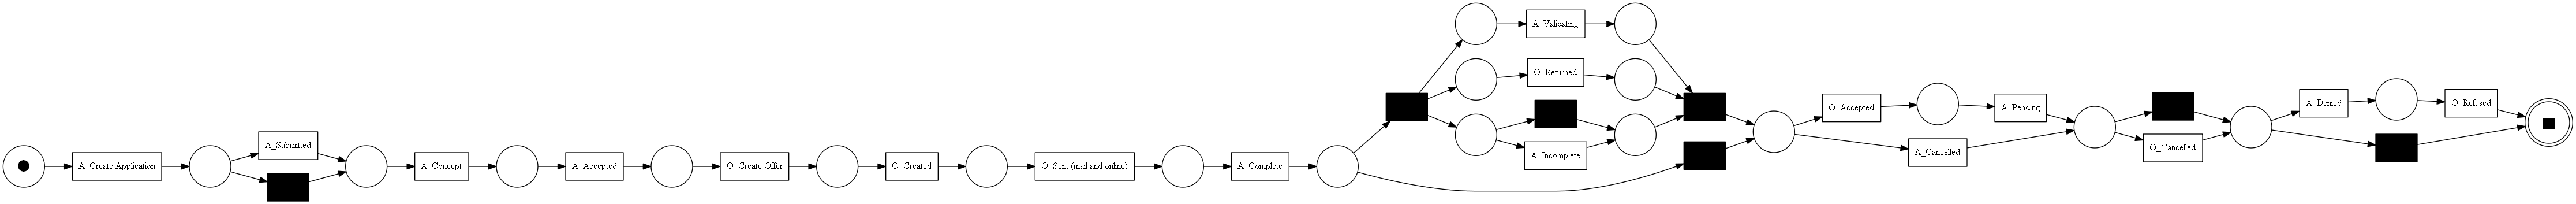

In [2]:

log = xes_importer.apply('../data/WorkflowlessBPIChallenge2017Fit.xes')
net, initial_marking, final_marking = pnml_importer.apply("../data/Workflowlesspetrinetbpi2017.pnml")    

gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)

In [3]:
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

In [4]:
net

places: [ n1, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19, n2, n20, n21, n3, n4, n5, n6, n7, n8, n9 ]
transitions: [ (n22, 'A_Create Application'), (n23, None), (n24, 'A_Submitted'), (n25, 'A_Concept'), (n26, 'A_Accepted'), (n27, 'O_Create Offer'), (n28, 'O_Created'), (n29, 'O_Sent (mail and online)'), (n30, 'A_Complete'), (n31, None), (n32, None), (n33, None), (n34, 'A_Validating'), (n35, 'O_Returned'), (n36, None), (n37, 'A_Incomplete'), (n38, 'O_Accepted'), (n39, 'A_Pending'), (n40, 'A_Cancelled'), (n41, None), (n42, 'O_Cancelled'), (n43, None), (n44, 'A_Denied'), (n45, 'O_Refused') ]
arcs: [ (n22, 'A_Create Application')->n3, (n23, None)->n4, (n24, 'A_Submitted')->n4, (n25, 'A_Concept')->n5, (n26, 'A_Accepted')->n6, (n27, 'O_Create Offer')->n7, (n28, 'O_Created')->n8, (n29, 'O_Sent (mail and online)')->n9, (n30, 'A_Complete')->n10, (n31, None)->n11, (n32, None)->n12, (n32, None)->n14, (n32, None)->n16, (n33, None)->n11, (n34, 'A_Validating')->n13, (n35, 'O_Returned')->n15, (n3

# Generic Methods

In [6]:
##usage= get_labels_set(input_transition_set)
def get_labels_set(input_transition_set):
    label_set=set()
    for transition in input_transition_set:
        label_set.add(transition._Transition__get_label())
    return label_set

##usage= get_input_transitions('n4')
def get_initial_start(intial_place):
    for place in net.places:
        if place._Place__get_name()==intial_place:
            initial_start=place
    return initial_start

##usage= get_input_transitions(net,initial_start)
def get_input_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_target()==place:
                if arc._Arc__get_source()._Transition__get_label() is None:
                    transition.append(arc._Arc__get_source())
                    for new_place in arc._Arc__get_source()._Transition__get_in_arcs():
                        transition.extend(get_input_transitions(net,new_place._Arc__get_source()))
                else:
                    transition.append(arc._Arc__get_source())
        return transition
    else:
        return None
    
##usage= get_output_transitions(net,initial_start)
def get_output_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_source()==place:
                transition.append(arc._Arc__get_target())
        return transition
    else:
        return None
    
def filter_none(input_transition_set):
    transition_set=set()
    for transition in input_transition_set:
        if transition._Transition__get_label() is not None:
            transition_set.add(transition)
    return transition_set

In [7]:
def listweightingtime(log, event):
    if event in weighingtimedict:
        return weighingtimedict[event]
    waitingtime=[]
    for case in log:
        time=None
        lasttime=None
        for events in case:
            if events['concept:name']==event:
                time=events['time:timestamp']
                break
            else :
                lasttime=events['time:timestamp']
        if time is not None and lasttime is not None:
            waitingtime.append(pd.to_datetime(time, utc=True)-pd.to_datetime(lasttime, utc=True))
    weighingtimedict[event]=waitingtime
    return waitingtime

def fit(net,aligned_traces,log):
    iter=0
    index=1
    for trace,login in zip(aligned_traces,log):
        iter=0
        print(index)
        index=index+1
        if trace['fitness']<1:
            for item in trace['alignment']:
            #move on model- adding an activity
                if (item[0]!=item[1]) and item[0]=='>>' and item[1] is not None:
                    print('adding:',item[1])
                    newitem=lastitem.__copy__()
                    print(len(login))
                    if len(login)<iter:
                        nextitemtime=login.__getitem__(iter).__getitem__('time:timestamp')
                    else :
                        nextitemtime=0
                    newitem.__setitem__('concept:name',item[1])
                    time=lastitem.__getitem__('time:timestamp')
                    weightingtime=random.choices(listweightingtime(log,item[1]))[0]
                    print(weightingtime)
                    if nextitemtime==0 or nextitemtime-time>weightingtime:
                        newitem.__setitem__('time:timestamp',time+weightingtime)
                    else :
                        print("here:",(nextitemtime-time)/2)
                        newitem.__setitem__('time:timestamp',time+(nextitemtime-time)/2)
                    login.insert(iter,newitem)
                    iter=iter+1
            #move on log- deleting an activity
                elif (item[0]!=item[1]) and item[1]=='>>' and item[0] is not None:
                    print('deleting',item[0],"-",iter)
                    login.__getitem__(iter).__setitem__('concept:name','readytodelete')
                #login.__setitem__(iter,None)
                #print(login)
                if item[0]!='>>' and item[0]!='readytodelete' and item[0] is not None:
                    lastitem=login.__getitem__(iter)
                    iter=iter+1
    log = pm4py.filter_event_attribute_values(log, "concept:name", ["readytodelete"], level="event", retain=False)
    return log

# Log fitness

In [11]:
aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, initial_marking, final_marking)


aligning log, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

In [25]:
weighingtimedict={}
newlog=fit(net,aligned_traces,log)

1
deleting A_Validating - 8
2
deleting A_Validating - 8
adding: A_Cancelled
11
5 days 05:31:05.953000
3
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 10
deleting O_Sent (mail and online) - 11
deleting A_Validating - 12
4
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
5
6
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
7
8
adding: A_Cancelled
12
30 days 17:43:36.639000
9
10
11
deleting A_Validating - 8
12
13
deleting A_Validating - 8
14
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
15
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
16
17
adding: A_Cancelle

0 days 00:00:02.106000
deleting O_Cancelled - 18
99
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 20
100
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 23
deleting O_Cancelled - 24
101
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
102
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
103
deleting A_Validating - 8
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Incomplete - 16
104
deleting O_Cre

deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
198
adding: A_Cancelled
12
3 days 18:51:36.070000
199
deleting A_Validating - 7
200
201
adding: A_Cancelled
12
30 days 20:35:39.787000
202
deleting A_Validating - 7
deleting A_Incomplete - 9
203
adding: A_Cancelled
11
35 days 22:40:55.166000
204
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting A_Incomplete - 21
deleting A_Validating - 22
deleting O_Cancelled - 26
deleting O_Cancelled - 27
205
deleting A_Validating - 7
206
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13


deleting O_Refused - 16
279
adding: A_Cancelled
10
30 days 12:35:26.351000
280
deleting A_Validating - 7
281
282
283
adding: A_Cancelled
12
30 days 13:36:14.410000
284
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting A_Validating - 19
deleting A_Incomplete - 23
deleting O_Cancelled - 27
deleting O_Cancelled - 28
deleting O_Cancelled - 29
285
286
287
deleting A_Validating - 8
deleting A_Incomplete - 12
288
deleting A_Validating - 8
289
290
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
291
292
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Creat

deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
deleting O_Cancelled - 26
deleting O_Cancelled - 27
441
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
442
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
deleting A_Validating - 15
443
adding: A_Cancelled
12
30 days 14:50:34.341000
444
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
445
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Cancelled - 12
446
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
adding: O_Returned
16
0 days 00:00:06.611000
447
deleting A_Validating - 7
448
deleting A_Validati

617
adding: A_Cancelled
12
30 days 19:20:58.536000
618
619
620
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
621
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
622
623
624
625
adding: A_Cancelled
12
0 days 00:01:51.710000
626
627
deleting A_Validating - 8
628
629
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
630
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
631
adding: A_Cancelled
12
30 days 22:32:18.082000
632
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
633
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
634
deleting A_Validating 

deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting O_Sent (mail and online) - 19
deleting A_Validating - 20
deleting O_Returned - 21
deleting A_Incomplete - 22
deleting O_Cancelled - 29
deleting O_Cancelled - 30
deleting O_Cancelled - 31
751
752
753
754
755
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
756
adding: A_Cancelled
12
30 days 14:46:43.645000
757
758
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
759
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
adding: A_Cancelled
17
30 days 16:47:15.376000
deleting O_Refused - 17
760
deleting A_Validating - 8
761
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
762
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleti

deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
939
940
941
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 18
deleting O_Cancelled - 19
deleting O_Cancelled - 20
942
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
943
944
945
adding: O_Returned
11
0 days 00:02:0

deleting O_Sent (mail and online) - 13
1113
1114
1115
1116
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
1117
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting O_Cancelled - 18
1118
adding: A_Cancelled
12
30 days 22:05:18.197000
1119
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 12
1120
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Cancelled - 17
1121
adding: A_Cancelled
12
9 days 06:09:59.601000
1122
deleting O_Cancelled - 8
1123
deleting O_Create Offer - 8
deleting O_Created - 9
de

1324
1325
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 17
deleting O_Cancelled - 19
deleting O_Cancelled - 20
1326
1327
deleting A_Validating - 7
1328
1329
deleting A_Validating - 7
1330
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 15:42:29.920000
1331
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1332
adding: A_Cancelled
12
30 days 15:33:20.370000
1333
1334
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
1335
1336
1337
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1338
1339
1340
1341
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail an

deleting O_Cancelled - 22
deleting O_Create Offer - 23
deleting O_Created - 24
deleting O_Sent (mail and online) - 25
deleting O_Cancelled - 30
deleting O_Cancelled - 31
deleting O_Cancelled - 32
1411
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
1412
1413
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Create Offer - 19
deleting O_Created - 20
deleting O_Sent (mail and online) - 21
deleting O_Sent (mail and online) - 22
deleting O_Create Offer - 23
deleting O_Created - 24
deleting O_Create Offer - 25
deleting O_Created - 26
deleting O_Sent (mail and online) - 27
deleting O_Sent (mail and online) - 28
deleting O_Cancelled - 31
deleting O_Cancelled - 32
deletin

deleting O_Cancelled - 29
deleting O_Cancelled - 30
deleting O_Cancelled - 31
1499
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
1500
1501
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1502
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
1503
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:42.350000
deleting A_Validating - 10
1504
deleting A_Validating - 8
1505
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Returned - 15
1506
1507
1508
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sen

deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 13
deleting O_Sent (mail and online) - 14
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting A_Validating - 22
deleting O_Cancelled - 26
deleting O_Cancelled - 27
deleting O_Cancelled - 28
1585
1586
adding: A_Cancelled
12
30 days 16:30:37.942000
1587
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Returned - 12
deleting A_Validating - 14
1588
1589
adding: A_Cancelled
10
30 days 19:02:45.245000
1590
1591
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled
20
30 days 21:59:20.922000
deleting O_Refused - 19
deleting O_Refused - 20
1592
1593
1594
1595
1596
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting 

deleting O_Returned - 13
1658
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
1659
1660
deleting A_Validating - 8
1661
deleting A_Validating - 8
1662
adding: A_Cancelled
12
30 days 19:09:45.219000
1663
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1664
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1665
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
1666
1667
1668
deleting A_Validating - 8
1669
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1670
1671
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1672
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 6
del

deleting O_Create Offer - 29
deleting O_Created - 30
deleting O_Sent (mail and online) - 31
deleting A_Validating - 35
deleting O_Cancelled - 38
deleting O_Cancelled - 39
deleting O_Cancelled - 40
deleting O_Cancelled - 41
deleting O_Cancelled - 42
1747
deleting A_Validating - 7
1748
1749
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1750
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
1751
1752
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
1753
adding: A_Cancelled
12
30 days 17:40:42.268000
1754
1755
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deletin

deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
deleting A_Incomplete - 20
deleting A_Validating - 21
deleting A_Incomplete - 22
deleting A_Validating - 23
deleting O_Cancelled - 27
deleting O_Cancelled - 28
1819
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Returned - 15
adding: A_Cancelled
21
4 days 00:03:54.825000
deleting O_Refused - 20
deleting O_Refused - 21
1820
deleting A_Validating - 7
1821
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Incomplete - 16
deleting A_Validating - 17
1822
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Returned - 15
d

deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
1881
1882
deleting A_Validating - 8
1883
1884
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Cancelled - 14
deleting O_Cancelled - 15
1885
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
1886
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
1887
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
deleting A_Incomplete - 13
deleting A_Validating - 17
deleting A_Incomplete - 18
1888
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 

deleting A_Validating - 8
2001
deleting O_Sent (online only) - 6
adding: O_Sent (mail and online)
10
0 days 00:00:09.191000
2002
2003
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
2004
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
2005
2006
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
2007
deleting A_Validating - 8
2008
2009
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Sent (mail and online) - 17
deleting O_Cancelled - 20
2010
2011
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer -

deleting A_Incomplete - 12
2104
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
9
0 days 00:00:10.451000
2105
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled
20
30 days 14:08:00.469000
deleting O_Refused - 19
deleting O_Refused - 20
2106
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
adding: A_Cancelled
19
11 days 16:55:44.880000
deleting O_Refused - 18
deleting O_Refused - 19
2107
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
2108
adding: A_Cancelled
11
27 days 22:23:04.072000
2109
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 

deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 19
2361
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
2362
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 9
2363
2364
2365
deleting A_Validating - 8
2366
deleting A_Validating - 8
2367
deleting A_Validating - 7
2368
deleting A_Validating - 8
2369
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 13:45:48.519000
2370
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 12
2371
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
2372
deleting A_Validating - 8
deleting A_Incomp

deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
2621
deleting A_Validating - 8
deleting A_Incomplete - 12
2622
adding: A_Cancelled
12
30 days 21:31:26.088000
2623
2624
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
2625
2626
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 16
deleting O_Cancelled - 22
2627
adding: A_Cancelled
11
30 days 20:12:45.006000
2628
2629
2630
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
2631
deleting A_Validating - 7
2632
deleting A_Validating - 7
2633
2634
adding: A_Cancelled
12
1 days 21:47:17.725000
2635
2636
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Crea

deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
2896
deleting A_Validating - 8
2897
2898
2899
2900
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
2901
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
2902
2903
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
adding: A_Cancelled
17
30 days 16:44:27.991000
deleting O_Refused - 17
2904
deleting A_Validating - 8
2905
2906
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
2907
deleting A_Validating - 7
2908
2909
deleting A_Validating - 7
2910
2911
deleting O_Sent (online only) - 6
deleting A_Complete - 7
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
adding: A_Complete
18
0 days 00:00:00.026000
deleting A_Validating - 16
2912
deleting O_Create Of

deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
0 days 20:42:47.116000
deleting O_Refused - 16
3126
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 18
3127
3128
3129
deleting A_Validating - 8
3130
adding: A_Cancelled
12
30 days 17:11:54.091000
3131
adding: A_Cancelled
11
30 days 20:03:19.340000
3132
3133
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
3134
adding: A_Cancelled
12
7 days 00:18:39.595000
3135
deleting A_Validating - 7
3136
3137
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
3138
3139
3140
3141
deleting A_Validating - 7
3142
deleting A_Validating - 8
3143
adding: A_Cancelled
12
30 days 22:03:10.951000
3144


deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
3369
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
3370
3371
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
3372
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
3373
3374
deleting A_Validating - 7
3375
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 19
3376
3377
deleting A_Validating - 7
3378
3379
3380
3381
3382
3383
3384
3385
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:00:

deleting O_Cancelled - 12
3521
3522
deleting A_Validating - 8
3523
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 16:41:17.977000
3524
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (online only) - 18
deleting A_Validating - 19
deleting A_Incomplete - 20
deleting A_Validating - 24
deleting O_Cancelled - 28
3525
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting A_Validating - 16
3526
deleting A_Validating - 7
3527
3528
deleting A_Validating - 7
3529
adding: A_Cancelled
12
30 days 22:03:55.225000
3530
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_

deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
3651
3652
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
3653
3654
3655
deleting A_Validating - 7
deleting A_Incomplete - 9
3656
3657
3658
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
3659
adding: A_Cancelled
11
30 days 22:27:40.311000
3660
deleting A_Validating - 7
deleting A_Incomplete - 9
3661
3662
3663
deleting A_Validating - 7
deleting A_Incomplete - 9
3664
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
3665
deleting A_Validating - 8
3666
3667
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 14
3668
3669
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
3670
3671
3672
3673
3674
deleting O_Cancelled - 8
deleting O_Create

deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
3799
deleting O_Cancelled - 10
3800
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
3801
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
3802
3803
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
3804
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Incomplete - 16
deleting A_Validating - 17
3805
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (online only) - 19
deleting O_Cancelled - 22
deleting O_Cancelled - 23
3806
3807
deleting O_Create Offer - 11


deleting O_Sent (online only) - 10
adding: A_Cancelled
16
30 days 11:37:33.663000
deleting O_Refused - 16
3899
3900
deleting A_Validating - 8
deleting A_Incomplete - 12
3901
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 20
3902
3903
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
3904
deleting A_Validating - 8
3905
3906
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
3907
3908
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (online only) - 6
deleting A_Complete - 7
adding: A_Complete
14
0 days 00:00:00.040000
deleting O_Cancelled - 14
3909
3910
adding: A_Cancelled
12
30 days 20:19:14.688000
3911
3912
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
3913
3914
deleting A_Validating - 8

deleting A_Validating - 8
deleting A_Incomplete - 12
4188
4189
4190
4191
4192
4193
4194
deleting A_Validating - 8
4195
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
4196
deleting A_Validating - 8
4197
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
4198
4199
4200
deleting A_Validating - 8
4201
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (online only) - 16
deleting O_Cancelled - 18
deleting O_Cancelled - 19
4202
4203
adding: A_Cancelled
12
30 days 18:24:11.825000
4204
4205
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
4206
4207
4208
4209
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Va

deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
deleting O_Cancelled - 17
4325
4326
4327
deleting A_Validating - 7
4328
4329
4330
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
4331
deleting A_Validating - 8
deleting A_Incomplete - 12
4332
4333
4334
4335
4336
4337
4338
deleting A_Validating - 8
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Incomplete - 16
4339
4340
4341
4342
4343
4344
4345
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Cancelled - 11
deleting O_Cancelled - 12
deleting A_Validating - 16
4346
4347
adding: A_Cancelled
12
30 days 15:04:22.398000
4348
4349
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 17:22:05.60000

deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 8
deleting A_Validating - 11
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Incomplete - 18
deleting O_Returned - 19
4607
4608
deleting A_Validating - 7
4609
4610
4611
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
4612
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
4613
4614
4615
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Sent (mail and online) - 8
deleting A_Validating - 12
deleting A_Incomplete - 13
4616
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 15
4617
4618
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 14:40:44.431000
4619
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 

14
30 days 16:38:43.431000
4784
4785
4786
4787
4788
deleting A_Validating - 8
4789
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Returned - 13
4790
4791
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
4792
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
4793
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
4794
4795
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
4796
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 17
deleting O_Cancelled - 18
deleting O_Cancelled - 19
4797
deleting A_Va

deleting A_Validating - 14
deleting O_Cancelled - 21
4911
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting A_Validating - 14
deleting O_Returned - 15
deleting A_Incomplete - 16
deleting O_Cancelled - 17
deleting O_Create Offer - 18
deleting O_Created - 19
deleting O_Sent (mail and online) - 20
deleting A_Validating - 21
4912
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
4913
adding: A_Cancelled
12
30 days 18:48:20.965000
4914
deleting A_Validating - 8
4915
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
4916
4917
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
4918
4919
deleting A_Validating - 8
4920
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:04:27.838000
deleting A_Validating - 8
4921
4922
deleting A_Validating - 8
4923
4924


deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
5196
deleting A_Validating - 7
adding: A_Cancelled
10
30 days 13:14:19.939000
5197
5198
deleting A_Validating - 8
5199
deleting A_Validating - 8
deleting A_Incomplete - 12
5200
5201
deleting A_Validating - 7
5202
deleting A_Validating - 8
5203
5204
deleting A_Validating - 7
deleting A_Incomplete - 9
5205
deleting A_Validating - 7
5206
5207
deleting A_Validating - 7
5208
5209
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
5210
5211
5212
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 11:16:47.334000
5213
5214
5215
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 10
deleting O_Sent (mail and online) - 11
deleting O_Cancelled - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
5216
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validati

deleting A_Validating - 11
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
5420
5421
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Cancelled - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
deleting O_Cancelled - 23
5422
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (online only) - 18
deleting O_Cancelled - 23
5423
deleting A_Validating - 8
5424
5425
5426
5427
5428
deleting A_Validating - 7
deleting A_Incomplete - 9
5429
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and onl

deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
5564
5565
deleting A_Validating - 7
deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 21
5566
deleting A_Validating - 7
5567
5568
5569
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
5570
5571
5572
5573
deleting A_Validating - 8
5574
5575
5576
5577
5578
deleting A_Validating - 8
5579
5580
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
5581
5582
5583
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting A_Validating - 11
5584
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting A_Validating - 12
deleting A_Incomplete - 14
5585
5586
deleting O_Create O

deleting O_Sent (online only) - 13
deleting O_Returned - 15
5744
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
5745
5746
5747
5748
deleting A_Validating - 8
5749
5750
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 17
5751
deleting A_Validating - 8
5752
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
5753
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
5754
deleting A_Validating - 7
5755
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Cancelled - 9
deleting O_Sent (mail and onli

deleting A_Validating - 7
5888
5889
5890
5891
5892
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Returned - 15
5893
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
5894
adding: A_Cancelled
9
30 days 17:01:02.094000
5895
5896
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Cancelled - 15
deleting O_Cancelled - 16
deleting O_Sent (mail and online) - 17
deleting O_Sent (mail and online) - 18
deleting O_Cancelled - 21
5897
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
5898
5899
adding: A_Cancelled
11
30 days 22:44:30.991000
5900
5901
5902
deleting O_Create Offer - 7
deleting O_Created -

deleting A_Validating - 21
deleting O_Cancelled - 25
6025
6026
6027
deleting A_Validating - 7
6028
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
6029
6030
6031
6032
6033
deleting A_Validating - 8
6034
adding: A_Cancelled
12
0 days 02:41:58.537000
6035
6036
6037
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
6038
adding: A_Cancelled
12
1 days 20:30:09.463000
6039
6040
6041
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
6042
deleting A_Validating - 8
6043
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
6044
deleting A_Validating - 8
6045
6046
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create O

deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
6196
6197
6198
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
6199
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
6200
6201
deleting A_Validating - 8
6202
adding: A_Cancelled
12
30 days 21:44:03.412000
6203
6204
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
6205
6206
6207
deleting A_Validating - 8
deleting A_Incomplete - 12
6208
6209
6210
deleting A_Validating - 8
deleting A_Incomplete - 12
6211
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
adding: A_Ca

30 days 20:25:06.592000
6351
6352
deleting A_Validating - 8
6353
adding: A_Cancelled
12
30 days 14:06:55.796000
6354
6355
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
6356
deleting A_Validating - 8
deleting A_Incomplete - 12
6357
deleting A_Validating - 7
deleting A_Incomplete - 8
6358
6359
deleting A_Validating - 7
6360
6361
deleting A_Validating - 7
6362
6363
6364
6365
6366
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
6367
6368
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting O_Cancelled - 20
6369
6370
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
6371
6372
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
de

deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting A_Validating - 11
6594
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
6595
deleting A_Validating - 8
6596
adding: A_Cancelled
11
6 days 20:08:45.793000
6597
6598
deleting A_Validating - 7
6599
6600
deleting A_Validating - 7
adding: A_Cancelled
13
3 days 17:18:25.843000
6601
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
deleting A_Incomplete - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (online only) - 16
deleting A_Validating - 17
6602
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Returned - 15
6603
deleting A_Validating - 8
6604
6605
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 22:29:48.

deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 13
deleting O_Sent (mail and online) - 14
deleting O_Cancelled - 18
deleting O_Cancelled - 19
deleting O_Cancelled - 20
6881
6882
deleting A_Validating - 8
6883
deleting A_Validating - 8
6884
adding: A_Cancelled
11
30 days 18:16:09.557000
6885
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting O_Cancelled - 20
6886
deleting A_Validating - 8
deleting A_Incomplete - 12
6887
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting A_Incomplete - 17
6888
adding: A_Cancelled
11
30 days 15:04:25.240000
6889
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancel

7040
deleting A_Validating - 7
7041
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
7042
deleting A_Validating - 8
7043
deleting A_Validating - 8
deleting A_Incomplete - 12
7044
7045
7046
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
7047
7048
adding: A_Cancelled
12
35 days 09:34:13.396000
7049
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
7050
7051
7052
deleting A_Validating - 8
7053
7054
7055
7056
deleting A_Validating - 8
7057
deleting A_Validating - 8
7058
adding: A_Cancelled
12
30 days 21:02:25.500000
7059
7060
deleting A_Validating - 8
7061
7062
7063
adding: A_Cancelled
12
1 days 19:06:28.636000
7064
deleting A_Validating - 8
7065
7066
7067
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online

deleting O_Cancelled - 19
7206
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
7207
deleting A_Validating - 8
7208
7209
deleting A_Validating - 7
7210
deleting A_Validating - 7
7211
adding: A_Cancelled
11
30 days 14:55:13.965000
7212
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
7213
7214
7215
adding: A_Cancelled
13
30 days 20:10:53.133000
7216
deleting A_Validating - 8
7217
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
7218
7219
7220
deleting A_Validating - 7
7221
7222
deleting A_Validating - 7
7223
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 13
deleting A_Incomplete - 15
deleting A_Validating - 16
7224
7225
d

deleting A_Validating - 16
7487
7488
7489
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 20
7490
7491
7492
deleting A_Validating - 8
7493
deleting A_Validating - 8
deleting A_Incomplete - 12
7494
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
7495
7496
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
7497
7498
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (online only) - 6
deleting A_Complete - 7
adding: A_Complete
14
0 days 00:00:00.022000
deleting O_Cancelled - 14
7499
7500
7501
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
del

deleting A_Incomplete - 24
deleting A_Validating - 25
deleting O_Cancelled - 29
7618
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
7619
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
7620
adding: A_Cancelled
12
2 days 19:12:55.742000
7621
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
7622
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
7623
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 19:09:54.269000
7624
adding: A_Cancelled
12
30 days 19:22:26.421000
7625
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 1

deleting A_Validating - 8
7727
7728
adding: A_Cancelled
12
30 days 16:21:09.565000
7729
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
7730
7731
deleting A_Validating - 8
7732
7733
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 14
7734
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
adding: A_Cancelled
16
30 days 19:27:54.221000
deleting O_Refused - 16
7735
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 18
deleting O_Cre

12
30 days 15:39:25.301000
7953
deleting A_Validating - 8
7954
7955
7956
deleting A_Validating - 8
7957
7958
7959
adding: A_Cancelled
12
30 days 16:20:00.441000
7960
7961
7962
7963
7964
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
7965
7966
7967
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
7968
deleting A_Validating - 8
7969
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Cancelled - 9
deleting O_Sent (mail and online) - 10
7970
7971
deleting O_Sent (online only) - 6
adding: O_Sent (mail and online)
10
0 days 00:00:15.336000
7972
7973
7974
7975
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting A_Incomplete - 20
7976
7977
7978
deleting A_Validating - 7
7979
7980


deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 20
8119
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 16:44:47.089000
deleting O_Refused - 16
8120
8121
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
8122
8123
8124
8125
8126
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
8127
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
8128
adding: O_Sent (mail and online)
7
0 days 00:00:26.260000
adding: A_Complete
8
0 days 00:00:00.025000
8129
8130
deleting O_Sent (online only) - 5
adding: O_S

deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
8255
8256
8257
deleting A_Validating - 8
8258
deleting A_Validating - 7
8259
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
8260
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
8261
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
8262
8263
8264
deleting A_Validating - 7
8265
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
9
0 days 00:00:51.395000
8266
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
8267
8268
8269
8270
8271
8272
8273
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 

deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Returned - 15
8402
8403
adding: A_Cancelled
12
30 days 20:50:46.011000
8404
adding: A_Cancelled
12
30 days 12:26:24.915000
8405
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
8406
deleting O_Cancelled - 6
deleting O_Create Offer - 7
deleting O_Created - 8
8407
deleting A_Validating - 7
8408
deleting A_Validating - 7
8409
8410
8411
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
8412
8413
8414
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
adding: A_Cancelled
19
30 days 19:44:07.923000
deleting O_Refused - 19
8415
deleting O_Create Offer - 8
deleting O_Created - 9


deleting A_Incomplete - 17
8541
deleting A_Validating - 8
8542
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Cancelled - 16
8543
adding: A_Cancelled
12
30 days 16:54:15.015000
8544
deleting A_Validating - 8
adding: A_Cancelled
14
2 days 19:42:37.784000
8545
deleting A_Validating - 8
8546
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
8547
8548
deleting A_Validating - 8
8549
8550
8551
8552
deleting A_Validating - 8
8553
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Cancelled - 18
deleting O_Create Offer - 19
deleting O_Created - 20
deleting O_Sent (mail and online) - 21
deleting O_Cancelled - 22
deleting O_Cancelled 

deleting O_Cancelled - 25
8662
8663
8664
8665
8666
8667
deleting A_Validating - 8
8668
8669
adding: A_Cancelled
12
30 days 19:06:13.453000
8670
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
9
0 days 00:00:49.645000
8671
8672
8673
deleting A_Validating - 8
deleting A_Incomplete - 12
8674
deleting A_Validating - 7
8675
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
adding: A_Cancelled
15
30 days 15:39:59.999000
8676
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 17:03:36.021000
8677
8678
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
8679
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deletin

adding: A_Cancelled
12
7 days 21:44:49.562000
8850
adding: A_Cancelled
12
30 days 12:43:30.876000
8851
adding: A_Cancelled
11
16 days 20:18:27.603000
8852
8853
adding: A_Cancelled
11
5 days 18:39:34.657000
8854
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting O_Returned - 15
deleting A_Incomplete - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (online only) - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
deleting A_Validating - 22
deleting O_Cancelled - 29
deleting O_Cancelled - 30
8855
8856
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Sent 

deleting O_Sent (mail and online) - 10
9054
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (online only) - 19
deleting O_Create Offer - 20
deleting O_Created - 21
deleting O_Sent (mail and online) - 22
deleting A_Validating - 23
deleting O_Returned - 24
deleting O_Cancelled - 28
9055
9056
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
9057
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
9058
9059
adding: A_Cancelled
12
30 days 13:16:58.959000
9060
9061
adding: A_Cancelled
12
30 days 16:00:54.355000
9062
9063
9064
de

deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 16
9175
9176
9177
deleting A_Validating - 8
9178
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
9179
9180
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
9181
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
9182
deleting A_Validating - 8
9183
9184
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 6
deleting A_Validating - 14
deleting A_Incomplete - 15
dele

deleting O_Returned - 15
9287
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
13 days 21:58:51.671000
deleting O_Refused - 15
9288
9289
deleting A_Validating - 8
9290
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
9291
deleting A_Validating - 7
9292
deleting A_Validating - 7
9293
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
9294
9295
deleting A_Validating - 7
9296
deleting A_Validating - 7
9297
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
9298
9299
9300
9301
adding: A_Cancelled
10
25 days 19:54:06.759000
9302
deleting A_Validating - 7
9303
9304
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:01:27.542000
9305
deleting A_Validating - 7
9306
adding: O_Returned


deleting A_Validating - 7
adding: A_Cancelled
13
30 days 15:10:59.687000
9419
9420
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 16
9421
deleting A_Validating - 8
deleting A_Incomplete - 12
9422
9423
9424
9425
9426
deleting A_Validating - 8
deleting A_Incomplete - 12
9427
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
0 days 02:26:27.483000
deleting O_Refused - 15
9428
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Cancelled - 16
9429
deleting A_Validating - 7
9430
adding: A_Cancelled
12
30 days 20:35:21.509000
9431
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Cancelled - 12
deleting O_Create Offe

deleting O_Sent (mail and online) - 9
9528
adding: A_Cancelled
12
30 days 16:04:25.254000
9529
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 16
9530
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
9531
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
9532
deleting A_Validating - 7
deleting A_Incomplete - 9
9533
9534
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Incomplete - 16
deleting A_Validating - 17
9535
9536
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting O_Cancelled - 16


deleting O_Sent (mail and online) - 9
9649
9650
deleting A_Validating - 8
9651
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
9652
deleting A_Validating - 7
deleting A_Incomplete - 9
9653
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Cancelled - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 18
9654
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting O_Cancelled - 20
9655
deleting A_Validating - 7
9656
adding: A_Cancelled
11
30 days 16:05:30.979000
9657
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
9658
deleting O_Create O

deleting O_Cancelled - 14
9726
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 21:37:14.302000
9727
deleting O_Create Offer - 4
deleting O_Created - 5
adding: A_Cancelled
15
30 days 16:06:00.851000
deleting O_Refused - 15
9728
deleting A_Validating - 8
9729
9730
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
9731
9732
9733
9734
deleting A_Validating - 8
deleting A_Incomplete - 12
9735
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
9736
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
9737
9738
deleting A_Validating - 8
deleting A_Incomplete - 12
9739
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled -

deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Returned - 14
deleting O_Cancelled - 20
9848
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:01:33.456000
deleting A_Validating - 8
9849
9850
deleting A_Validating - 7
deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
9851
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
9852
deleting A_Validating - 7
9853
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
9854
adding: A_Cancelled
12
30 days 14:06:41.461000
9855
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
9856
deleting A_Validating - 8
9857
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
9858
9859
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleti

deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
9943
9944
adding: A_Cancelled
12
30 days 17:39:26.072000
9945
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 18
deleting O_Cancelled - 19
deleting O_Cancelled - 20
9946
deleting A_Validating - 7
9947
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
9948
deleting A_Validating - 7
9949
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
9950
adding: A_Cancelled
12
30 days 20:18:28.505000
9951
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
10
0 days 00:00:12.048000
deleting A_Validating - 8
adding: A_Cancelled
11
30 days 16:26:44.073000

deleting A_Incomplete - 25
deleting A_Validating - 26
deleting O_Cancelled - 30
10028
10029
deleting A_Validating - 7
10030
deleting A_Validating - 8
10031
deleting A_Validating - 8
deleting A_Incomplete - 12
10032
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
9
0 days 00:00:12.068000
10033
10034
adding: A_Cancelled
12
30 days 19:13:49.637000
10035
10036
adding: A_Cancelled
12
30 days 20:00:01.938000
10037
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
10038
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10039
10040
adding: A_Cancelled
13
30 days 20:23:13.735000
10041
deleting A_Validating - 8
10042
10043
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Returned - 12
10044
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
10045
10046
deleting O_Creat

deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
10127
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
10128
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting O_Cancelled - 23
10129
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled
20
30 days 22:33:24.902000
deleting O_Refused - 19
deleting O_Refused - 20
10130
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 12
10131
deleting A_Validating - 8
delet

deleting O_Sent (online only) - 13
deleting A_Validating - 14
10228
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10229
deleting A_Validating - 8
10230
10231
10232
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
10233
10234
10235
10236
deleting A_Validating - 8
adding: A_Cancelled
14
15 days 21:28:40.591000
10237
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
10238
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10239
10240
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting O_Create Offer - 12
deleting O_Created - 13
de

deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
10331
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Validating - 15
10332
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10333
adding: A_Cancelled
11
30 days 17:17:13.718000
10334
10335
10336
10337
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 13:35:53.998000
deleting O_Refused - 16
10338
deleting A_Validating - 7
10339
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 15:00:31.778000
10340
10341
deleting A_Validating - 7
10342
10343
deleting A_Validating - 7
10344
10345
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
10346
deleting A_Validating - 7
10347

deleting A_Incomplete - 9
deleting A_Validating - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
adding: A_Cancelled
19
30 days 17:54:11.380000
deleting O_Refused - 19
10425
10426
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10427
deleting O_Create Offer - 6
deleting O_Created - 7
deleting A_Validating - 13
deleting A_Incomplete - 14
10428
10429
10430
10431
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10432
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
10433
10434
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 17
d

deleting A_Incomplete - 9
adding: A_Cancelled
14
6 days 17:05:47.734000
10497
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 16
10498
10499
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Cancelled - 21
deleting O_Cancelled - 22
10500
adding: A_Cancelled
11
30 days 16:12:21.441000
10501
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
10502
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
4 days 01:19:10.086000
deleting O_Refused - 15
10503
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
10

deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Returned - 15
deleting O_Cancelled - 21
10578
deleting A_Validating - 8
deleting A_Incomplete - 12
10579
deleting A_Validating - 8
10580
10581
10582
10583
10584
10585
10586
10587
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10588
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10589
10590
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
10591
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
deleting A_Incomplete - 12
10592
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10593
10594
deleting O_Create Offer - 8
deleting O_Create

deleting O_Cancelled - 27
deleting O_Cancelled - 28
deleting O_Cancelled - 29
10671
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
30 days 15:17:18.718000
deleting O_Refused - 15
10672
10673
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
adding: A_Cancelled
23
28 days 03:14:27.457000
deleting O_Refused - 21
deleting O_Refused - 23
10674
10675
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 13
deleting A_Incomplete - 15
deleting A_Validating - 16
10676
deleting A_Validating - 7
10677
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Returned - 14
10678
deleting A_Validating - 

deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
deleting A_Validating - 15
10750
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
deleting A_Incomplete - 12
10751
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 7
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
adding: A_Cancelled
18
30 days 14:18:50.485000
10752
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 12
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
10753
10754
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 

deleting A_Incomplete - 12
10828
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting O_Returned - 12
10829
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (online only) - 5
deleting A_Complete - 6
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Complete
21
0 days 00:00:00.034000
deleting A_Validating - 14
deleting O_Cancelled - 20
10830
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10831
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 14:29:14.478000
10832
deleting A_Validating - 7
10833
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_

30 days 16:01:50.271000
deleting O_Refused - 23
10906
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
10907
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
10908
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10909
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10910
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
10911
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10912
10913
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
10914
10915
10916
10917
1091

deleting A_Validating - 8
10982
10983
10984
10985
10986
10987
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
10988
deleting A_Validating - 8
10989
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (online only) - 11
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting O_Create Offer - 18
deleting O_Created - 19
deleting O_Sent (mail and online) - 20
deleting O_Cancelled - 26
deleting O_Cancelled - 27
10990
deleting A_Validating - 7
10991
10992
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
10993
10994
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
10995
deleting A_Validati

deleting A_Validating - 8
adding: A_Cancelled
14
30 days 21:40:36.277000
11096
11097
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 16
11098
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
11099
deleting A_Validating - 8
11100
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting A_Validating - 11
11101
11102
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
11103
11104
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
11105
11106
deleting A_Validating - 8
11107
11108
deleting A_Validating - 8
11109
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
adding: A_Cancelled
16
30 days 14:42:34.982000
deleting O_Refused - 16
11110
11111
11112
11113
11114
deleting A_Validatin

deleting O_Cancelled - 30
deleting O_Cancelled - 31
11311
deleting A_Validating - 7
11312
11313
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
11314
deleting A_Validating - 7
11315
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting A_Incomplete - 10
11316
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
11317
deleting A_Validating - 7
11318
11319
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
11320
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
11321
11322
adding: A_Cancelled
11
30 days 18:48:54.765000
11323
11324
11325
deleting A_Validating - 8
deleting A_Incomplete - 12
11326
adding: A_Cancelled
12
30 days 20:00:47.250000
11327
adding: A_Cancelled
11
3 days 20:46:46.249000
11328
de

deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
adding: A_Complete
20
0 days 00:00:00.044000
11507
deleting A_Validating - 8
11508
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
11509
deleting A_Validating - 8
adding: A_Cancelled
14
5 days 19:30:31.272000
11510
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
11511
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting O_Cancelled - 22
11512
deleting O_Create Offe

11603
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
11604
deleting A_Validating - 7
deleting A_Incomplete - 9
11605
11606
deleting A_Validating - 7
11607
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
11608
deleting A_Validating - 7
11609
deleting A_Validating - 7
deleting A_Incomplete - 9
11610
11611
11612
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
11613
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
11614
11615
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
11616
deleting A_Validating - 7
11617
adding: O_Sent (mail and online)
8
0 days 

deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
11827
11828
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 10
deleting O_Sent (mail and online) - 11
11829
11830
adding: A_Cancelled
12
10 days 22:23:00.745000
11831
deleting A_Validating - 8
11832
11833
11834
deleting A_Validating - 8
11835
deleting A_Validating - 8
11836
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
11837
deleting A_Validating - 8
deleting A_Incomplete - 12
11838
11839
11840
deleting A_Validating - 8
deleting A_Incomplete - 12
11841
11842
deleting A_Validating - 8
adding: A_Cancelled
11
30 days 15:49:09.539000
11843
11844
11845
11846
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
11847
adding: A_Cancelled
12
7 days 04:12:00.354000
11848
11849
deleting O_Create Offer - 11

deleting O_Cancelled - 27
deleting O_Cancelled - 28
deleting O_Cancelled - 29
11980
11981
11982
deleting A_Validating - 8
deleting A_Incomplete - 12
11983
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 23
11984
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 14
11985
11986
11987
11988
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
11989
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (online only) 

deleting O_Created - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting O_Cancelled - 18
deleting A_Validating - 19
deleting O_Cancelled - 25
12122
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled
18
30 days 15:18:58.916000
deleting O_Refused - 18
12123
12124
12125
12126
deleting A_Validating - 7
deleting A_Incomplete - 9
12127
deleting A_Validating - 7
12128
12129
adding: A_Cancelled
11
30 days 20:59:21.574000
12130
12131
deleting A_Validating - 8
deleting A_Incomplete - 12
12132
adding: A_Cancelled
11
30 days 15:52:11.946000
12133
12134
12135
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deletin

deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Create Offer - 19
deleting O_Created - 20
deleting O_Cancelled - 21
deleting O_Cancelled - 22
deleting O_Create Offer - 23
deleting O_Created - 24
deleting O_Create Offer - 25
deleting O_Created - 26
deleting O_Sent (mail and online) - 27
deleting O_Sent (mail and online) - 28
deleting A_Validating - 31
deleting A_Incomplete - 32
deleting O_Create Offer - 33
deleting O_Created - 34
deleting O_Sent (mail and online) - 35
deleting O_Create Offer - 36
deleting O_Created - 37
deleting O_Sent (online only) - 38
deleting A_Validating - 39
deleting A_Incomplete - 40
deleting A_Validating - 41
deleting A_Incomplete - 43
deleting O_Cancelled - 47
deleting O_Cancelled - 48
deleting O_Cancelled - 49
deleting O_Cancelled - 50
12239
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
12240
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent 

deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting O_Returned - 17
deleting A_Incomplete - 19
deleting O_Cancelled - 23
12357
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 6
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
12358
12359
12360
12361
12362
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 10
deleting O_Sent (mail and online) - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
12363
12364
12365
12366
12367
12368
deleting A_Validating - 8
12369
12370
deleting A_Validating - 8
12371
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
12372
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and 

12476
12477
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
12478
deleting A_Validating - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
12479
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
12480
12481
12482
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Incomplete - 18
12483
adding: A_Cancelled
11
30 days 19:53:12.281000
12484
12485
deleting A_Validating - 7
12486
deleting A_Validating - 8
deleting A_Incomplete - 12
12487
deleting A_Validating - 7
12488
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 1

deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Cancelled - 17
12596
12597
12598
deleting A_Validating - 8
12599
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Returned - 12
12600
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
12601
deleting A_Validating - 8
deleting A_Incomplete - 12
12602
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
12603
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
12604
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
12605
12606
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_

adding: A_Cancelled
18
30 days 14:11:29.244000
deleting O_Refused - 18
12707
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 16
12708
12709
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
12710
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 9
12711
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:11.785000
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 16:15:21.117000
12712
12713
12714
12715
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
12716
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
12717
12718
12719
deleting A_Validating - 8
12720
12721
deleting A_Validating - 8
12722
deleting O_Cr

deleting A_Validating - 8
12881
12882
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
deleting O_Returned - 12
deleting A_Incomplete - 13
deleting O_Cancelled - 14
deleting O_Cancelled - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting A_Validating - 21
deleting A_Incomplete - 23
deleting A_Validating - 24
12883
12884
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
12885
12886
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (online only) - 5
deleting A_Complete - 6
adding: A_Complete
13
0 days 00:00:00.041000
deleting O_Cancelled - 13
12887
12888
adding: A_Cancelled
12
4 days 22:11:12.763000
12889
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Create Offer - 9
deleting O_Sent (mail and online

deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
13161
13162
13163
adding: A_Cancelled
12
4 days 22:18:25.863000
13164
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
13165
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
13166
deleting A_Validating - 8
13167
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
13168
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting A_Validating - 15
deleting O_Sent (mail and online) - 17
13169
adding: A_Cancelled
9
30 days 11:08:29.356000
13170
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
13171
deleting A_Validating - 8
13172
deleting O_Create Offer -

deleting A_Validating - 7
13296
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
13297
13298
13299
13300
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
13301
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting A_Validating - 19
13302
13303
13304
13305
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
13306
13307
13308
13309
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
13310
13311
deleting A_Validating - 8
13312
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
13313
13314

deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting O_Cancelled - 18
13539
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting A_Validating - 17
deleting A_Incomplete - 18
13540
13541
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
13542
13543
13544
deleting A_Validating - 8
13545
13546
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Cancelled - 11
deleting O_Cancelled - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting O_Sent (mail and online) - 18
deleting A_Validating - 22
13547
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sen

deleting A_Incomplete - 14
13762
13763
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
13764
13765
deleting A_Validating - 8
13766
deleting A_Validating - 8
13767
13768
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
13769
deleting A_Validating - 8
13770
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
13771
adding: A_Cancelled
12
22 days 05:51:16.071000
13772
13773
adding: A_Cancelled
12
30 days 20:54:30.142000
13774
adding: A_Cancelled
12
30 days 14:58:29.305000
13775
deleting A_Validating - 8
13776
deleting A_Validating - 8
13777
13778
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
13779
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Retur

deleting O_Sent (online only) - 12
adding: O_Sent (mail and online)
22
0 days 00:00:20.327000
deleting O_Sent (online only) - 14
deleting O_Sent (online only) - 16
deleting O_Sent (online only) - 17
deleting O_Cancelled - 20
deleting O_Cancelled - 21
deleting O_Cancelled - 22
13869
deleting A_Validating - 8
13870
deleting A_Validating - 8
13871
13872
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting O_Cancelled - 24
13873
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
13874
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online

deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Returned - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting O_Cancelled - 23
14077
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 20
deleting O_Created - 21
deleting O_Sent (mail and online) - 22
deleting A_Validating - 23
deleting A_Incomplete - 24
deleting O_Cancelled - 28
deleting O_Cancelled - 29
14078
deleting A_Validating - 7
14079
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting O_Returned - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
14080
14081
deleting O_Sent (online only) - 5
adding: O_Sent (mail and on

deleting A_Validating - 11
14163
14164
14165
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14166
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14167
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
14168
adding: A_Cancelled
12
30 days 20:16:28.825000
14169
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
14170
deleting A_Validating - 8
deleting A_Incomplete - 12
14171
14172
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14173
adding: A_Cancelled
12
30 days 12:47:26.414000
14174
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14175
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
del

deleting A_Incomplete - 9
deleting A_Validating - 12
14259
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 11:22:32.213000
14260
14261
14262
deleting A_Validating - 7
14263
14264
14265
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14266
14267
14268
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
deleting O_Cancelled - 12
14269
adding: A_Cancelled
11
14 days 02:57:36.902000
14270
deleting A_Validating - 7
14271
deleting A_Validating - 8
deleting A_Incomplete - 12
14272
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
14273
adding: A_Cancelled
12
30 days 20:42:35.391000
14274
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
14275
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
14276
14277
deleting O_Created - 4
deleting O_Create Offer - 5
delet

deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 16
deleting O_Cancelled - 22
14379
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14380
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
14381
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14382
deleting A_Validating - 9
14383
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 19:09:12.537000
14384
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 15:01:42.271000
deleting O_Refused - 16
14385
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 16
14386
14387
14388
deleting O_Create Offer

deleting O_Cancelled - 12
14472
deleting A_Validating - 7
14473
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
14474
deleting A_Validating - 7
14475
14476
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
14477
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
14478
14479
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
14480
14481
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14482
14483
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 19:07:57.511000
deleting O_Refused - 16
14484
14485
deleting O_Create Offer - 4
deleting O_Created 

deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 18:47:11.297000
deleting O_Refused - 16
14549
adding: A_Cancelled
12
30 days 15:34:16.478000
14550
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting O_Returned - 15
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
deleting O_Cancelled - 25
deleting O_Cancelled - 26
14551
14552
14553
14554
deleting O_Create Offer - 6
deleting O_Created - 7
deleting A_Validating - 13
14555
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 17
14556
deleting A_Validating - 8
14557
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14

deleting A_Incomplete - 9
deleting A_Validating - 12
14625
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 16
deleting O_Cancelled - 22
14626
14627
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
14628
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 13
adding: A_Cancelled
17
4 days 00:22:52.786000
deleting O_Refused - 17
14629
deleting A_Validating - 7
14630
14631
14632
deleting A_Validating - 8
14633
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
deleting O_Cancelled - 17
14634
deleting O_Create Offer - 6
deleting O_

deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14711
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 16
deleting O_Cancelled - 19
14712
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
14713
deleting A_Validating - 8
14714
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14715
14716
14717
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14718
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
14719
14720
adding: A_Cancelled
12
30 days 18:35:13.893000
14721
14722
14723
deleting O_Create Offer - 6
deleting O_

deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
14829
adding: A_Cancelled
11
0 days 03:42:59.871000
14830
14831
14832
14833
deleting A_Validating - 8
14834
14835
14836
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14837
14838
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
14839
14840
deleting A_Validating - 8
14841
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 12
14842
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
14843
deleting A_Validating - 8
14844
deleting A_Validating - 7
deleting A_Incomplete - 9
del

deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 13:42:45.664000
deleting O_Refused - 16
15096
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15097
15098
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
15099
15100
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:10.356000
deleting A_Validating - 8
15101
deleting A_Validating - 7
deleting A_Incomplete - 9
15102
deleting A_Validating - 7
15103
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15104
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
15105
15106
15107
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
15108
deleting A_Validating -

deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
deleting O_Create Offer - 22
deleting O_Created - 23
deleting O_Sent (mail and online) - 24
deleting A_Validating - 25
deleting O_Returned - 26
deleting A_Incomplete - 27
deleting O_Cancelled - 31
15219
deleting A_Validating - 8
15220
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15221
deleting A_Validating - 7
15222
15223
deleting A_Validating - 8
15224
15225
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 13
deleting O_Cancelled - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting O_Cancelled - 18
15226
15227
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Valid

deleting O_Sent (online only) - 13
deleting O_Cancelled - 14
15354
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15355
deleting A_Validating - 7
15356
15357
deleting A_Validating - 8
15358
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
15359
adding: A_Cancelled
12
6 days 04:06:38.017000
15360
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
15361
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
15362
15363
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
4 days 03:40:35.305000
deleting O_Refused - 15
15364
15365
15366
deleting O_Create Of

deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15634
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15635
15636
15637
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
15638
deleting A_Validating - 8
15639
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:00:09.379000
adding: A_Cancelled
12
30 days 19:28:17.304000
15640
15641
deleting A_Validating - 8
deleting A_Incomplete - 12
15642
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
15643
deleting A_Validating - 7
15644
15645
deleting A_Validating - 8
deleting A_Validating - 11
deleting A_Incomplet

deleting O_Refused - 14
15778
15779
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
19
0 days 00:00:21.314000
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
15780
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
adding: A_Cancelled
23
30 days 22:38:50.360000
deleting O_Refused - 22
deleting O_Refused - 23
15781
15782
deleting A_Validating - 8
adding: A_Cancelled
14
2 days 16:57:32.276000
15783
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
15784
15785
deleting A_Validating - 7
15786
15787
adding: A_Cancelled
10
30 days 20:31:55.124000
15788
deleting O_Create Offer - 7
deleting O_Created - 8
deleting

deleting O_Created - 12
deleting O_Sent (online only) - 13
16003
16004
16005
16006
16007
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
16008
16009
deleting O_Sent (online only) - 6
adding: O_Sent (mail and online)
18
0 days 00:01:30.914000
deleting A_Validating - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
16010
deleting A_Validating - 8
adding: A_Cancelled
14
4 days 09:48:38.392000
16011
16012
adding: A_Cancelled
12
30 days 15:50:46.215000
16013
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
16014
deleting A_Validating - 8
16015
adding: A_Cancelled
12
30 days 11:49:29.060000
16016
deleting A_Validating - 8
deleting A_Incomplete - 12
16017
deleting A_Validating - 8
160

deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 5
16271
16272
16273
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
16274
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
16275
deleting O_Sent (online only) - 6
adding: O_Sent (mail and online)
10
0 days 00:02:03.637000
16276
16277
16278
16279
deleting A_Validating - 7
16280
16281
16282
16283
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
16284
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (online only) - 18
deleting O_Cancelled - 19
deleting A_Validating - 20
16285
deleting O_Cancelled - 6
deleting O_Create Offer - 7
del

deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
16392
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
16393
16394
16395
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting A_Validating - 13
deleting A_Incomplete - 15
deleting A_Validating - 16
16396
16397
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting A_Validating - 18
deleting O_Cancelled - 22
16398
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
16399
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Incomplete - 15
deleting A_Validating - 17
16400
deleting A_Validating - 8
d

deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
16506
16507
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 13
deleting A_Incomplete - 14
16508
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 13
deleting A_Incomplete - 14
16509
16510
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
16511
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
16512
16513
16514
16515
16516
deleting A_Validating - 8
deleting A_Incomplete - 12
16517
deleting A_Validating - 9
16518
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Cancelled - 12
deleting O_Cancelled - 13
16519
deleting O_Create Offer - 5
deletin

deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 14
16640
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 9
16641
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
adding: A_Cancelled
15
30 days 22:19:55.782000
16642
16643
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
16644
16645
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
adding: A_Cancelled
22
27 days 22:10:24.176000
deleting O_Refused - 22
16646
adding: A_Cancelled
12
6 days 23:41:28.311000
16647
deleting O_Create Offer - 8
deleting O_Created - 9
deletin

deleting O_Sent (online only) - 10
16763
16764
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 13
16765
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 16
16766
deleting O_Cancelled - 8
16767
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
16768
deleting A_Validating - 8
16769
deleting A_Validating - 8
deleting A_Incomplete - 12
16770
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 14:34:29.412000
16771
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 12
16772
16773
16774
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
16775
16776
16777
16778
16779
deleting A_Validating - 8
16780

0 days 00:01:18.679000
adding: A_Cancelled
13
30 days 07:33:42.185000
16891
16892
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
adding: O_Returned
20
0 days 00:00:17.509000
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
16893
deleting A_Validating - 8
16894
16895
deleting A_Validating - 7
deleting A_Incomplete - 9
16896
16897
16898
16899
16900
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
16901
deleting A_Validating - 8
deleting A_Incomplete - 12
16902
deleting A_Validating - 7
16903
16904
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
12
0 days 00:01:34.070000
16905
deleting A_Validating - 7
16906
16907
16908
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
16909
16910
16911
16912
16913
deleting A_Validating - 8
16914
deleting O_Create Of

deleting O_Create Offer - 5
deleting O_Created - 6
17019
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 11:59:23.993000
17020
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
17021
17022
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
17023
17024
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
17025
deleting A_Validating - 8
17026
17027
17028
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
17029
17030
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 21:49:13.452000
17031
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
17032
17033
17034
17035
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 11:33:28.149000
17036
adding: A_Cancelled
1

deleting A_Incomplete - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (online only) - 16
deleting A_Validating - 17
deleting O_Cancelled - 24
17140
17141
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
17142
deleting A_Validating - 8
17143
17144
17145
17146
adding: A_Cancelled
12
30 days 17:14:08.889000
17147
adding: O_Sent (mail and online)
8
0 days 00:08:50.552000
adding: A_Complete
9
0 days 00:00:00.081000
adding: A_Cancelled
10
30 days 15:19:00.895000
17148
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
17149
17150
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 12:05:20.540000
17151
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 18
deleting O_Cancelled - 19


deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 19
17236
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
17237
17238
17239
deleting A_Validating - 8
17240
adding: A_Cancelled
12
30 days 13:17:00.725000
17241
deleting A_Validating - 8
deleting A_Incomplete - 12
17242
deleting A_Validating - 8
deleting A_Incomplete - 12
17243
17244
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
17245
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
deleting A_Validating - 15
17246
17247
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
17248
deleting A_Validating - 7
deleting A_Incomplete - 9
17

deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
17455
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 12
17456
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
17457
adding: A_Cancelled
12
0 days 01:37:50.037000
17458
deleting A_Validating - 8
17459
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting O_Cancelled - 19
deleting O_Returned - 20
deleting A_Validating - 21
deleting O_Cancelled - 25
17460
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and o

deleting O_Sent (online only) - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting O_Returned - 18
deleting O_Cancelled - 22
17682
17683
deleting A_Validating - 7
17684
17685
deleting A_Validating - 7
deleting A_Incomplete - 9
17686
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 20:58:13.193000
17687
17688
17689
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
17690
deleting A_Validating - 8
17691
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting O_Cancelled - 16
17692
deleting A_Validating - 7
17693
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 21
adding: A_Cancelled
25
30 days 14:01:02.887000
del

deleting O_Sent (mail and online) - 10
17813
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting O_Cancelled - 17
17814
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
17815
deleting A_Validating - 8
17816
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
17817
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
17818
17819
deleting A_Validating - 7
17820
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting A_Validating - 19
17821
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent

17951
17952
17953
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting O_Cancelled - 23
17954
17955
17956
deleting A_Validating - 8
deleting A_Incomplete - 12
17957
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
17958
deleting A_Validating - 8
17959
deleting A_Validating - 8
17960
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
deleting O_Returned - 19
deleting O_Cancelled - 23
17961
deleting A_Validating - 7
17962
17963
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 9
17964
deleting O_Create Offer - 6
deletin

deleting O_Sent (online only) - 12
deleting A_Validating - 13
deleting O_Cancelled - 20
18112
18113
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 18
18114
18115
18116
18117
deleting A_Validating - 7
18118
deleting A_Validating - 7
18119
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
deleting A_Incomplete - 20
deleting O_Cancelled - 23
deleting O_Cancelled - 24
deleting O_Cancelled - 25
18120
18121
deleting A_Validating - 7
18122
18123
18124
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
18125
18126
18127
deleting A_Validating - 7
18128
18129
deleting O_Create Offer - 7
deleting 

deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 17
deleting A_Incomplete - 19
deleting O_Cancelled - 25
deleting O_Cancelled - 26
18266
deleting O_Created - 4
deleting O_Cancelled - 5
deleting O_Create Offer - 6
deleting A_Validating - 13
18267
18268
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 14
deleting O_Cancelled - 15
18269
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
18270
deleting A_Validating - 8
deleting A_Incomplete - 12
18271
18272
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
18273
18274
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 15
18275
18276
18277
18278
adding: A_Cancelled
12
30 days 20:54:30.858000
18279
18280
18281
deleting A_Validating - 8
deleting O_Create Offer - 11


18477
18478
18479
18480
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
18481
deleting A_Validating - 7
18482
deleting A_Validating - 8
18483
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
18484
18485
deleting A_Validating - 8
18486
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting A_Incomplete - 15
deleting A_Validating - 18
deleting O_Cancelled - 21
18487
18488
deleting A_Validating - 7
18489
18490
deleting A_Validating - 7
18491
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
18492
18493
18494
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
adding: A_Cancelled
18
20 days 17:29:38.681000
deleting O_Refused - 18
18495
delet

18650
18651
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
18652
deleting A_Validating - 7
18653
18654
deleting A_Validating - 7
18655
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting A_Validating - 11
18656
deleting A_Validating - 8
18657
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
9
0 days 00:00:09.868000
18658
18659
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
18660
18661
deleting A_Validating - 8
18662
deleting A_Validating - 7
18663
deleting A_Validating - 8
deleting A_Incomplete - 12
18664
18665
18666
18667
adding: A_Cancelled
12
30 days 17:41:48.712000
18668
18669
deleting A_Validating - 8
deleting A_Incomplete - 12
18670
18671
18672
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 1

deleting A_Validating - 8
deleting A_Incomplete - 12
18897
18898
deleting A_Validating - 7
deleting A_Incomplete - 9
18899
18900
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 12
deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 18
deleting O_Cancelled - 19
deleting O_Cancelled - 20
18901
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
18902
deleting A_Validating - 7
18903
18904
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
18905
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
18906
adding: A_Cancelled
11
30 days 16:12:28.756000
18907
18908
18909
18910
18911
18912
18913
18914
adding:

deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
16
0 days 00:01:50.489000
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
19033
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
19034
19035
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
19036
deleting A_Validating - 7
19037
adding: O_Returned
12
0 days 00:00:04.654000
19038
deleting A_Validating - 7
deleting A_Incomplete - 8
19039
deleting A_Validating - 8
19040
19041
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Cancelled - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
19042
adding: A_Can

deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting A_Incomplete - 20
deleting A_Validating - 21
19198
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
19199
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 5
19200
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:10.253000
deleting A_Validating - 10
19201
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
adding: A_Cancelled
18
30 days 17:00:25.432000
19202
deleting A_Validating - 8
19203
19204
19205
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
19206
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
19207
deleting 

deleting A_Incomplete - 15
19338
19339
19340
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
19341
19342
19343
19344
deleting A_Validating - 8
deleting A_Incomplete - 12
19345
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
deleting A_Incomplete - 15
adding: A_Cancelled
19
30 days 12:42:16.632000
deleting O_Refused - 19
19346
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
19347
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
19348
adding: A_Cancelled
12
30 days 15:42:46.872000
19349
19350
19351
deleting A_Validating - 8
deleting A_Incomplete - 12
19352
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
add

deleting O_Cancelled - 20
19494
deleting A_Validating - 8
deleting A_Incomplete - 12
19495
deleting A_Validating - 8
deleting A_Incomplete - 12
19496
deleting A_Validating - 8
19497
19498
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
19499
adding: A_Cancelled
12
10 days 03:38:24.815000
19500
19501
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
19502
deleting A_Validating - 7
19503
19504
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
19505
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
19506
19507
deleting A_Validating - 8
deleting A_Incomplete - 9
19508
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
19509
deletin

deleting A_Validating - 13
deleting A_Incomplete - 14
19684
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
19685
19686
deleting A_Validating - 8
deleting A_Incomplete - 12
19687
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 16
19688
19689
deleting A_Validating - 8
19690
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Incomplete - 16
deleting A_Validating - 17
19691
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
19692
19693
19694
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Incomplete - 15
19695
19696
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (ma

deleting A_Validating - 8
adding: A_Cancelled
14
3 days 18:42:05.453000
19893
deleting A_Validating - 8
deleting A_Incomplete - 12
19894
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
19895
19896
19897
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
19898
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
19899
deleting A_Validating - 8
19900
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
19901
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting O_Cancelled - 18

20020
20021
20022
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
20023
20024
20025
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
adding: A_Cancelled
18
30 days 20:51:43.789000
deleting O_Refused - 18
20026
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
20027
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 12
20028
adding: A_Cancelled
12
30 days 10:59:02.955000
20029
20030
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 16
20031
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
20032
20033
deleting A_Validating - 9
20034
20035
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Cancelled - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 1

deleting A_Incomplete - 18
deleting O_Cancelled - 22
20150
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
20151
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 15
adding: A_Cancelled
19
30 days 20:30:33.211000
deleting O_Refused - 19
20152
20153
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
20154
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (mail and online) - 17
deleting O_Create Offer - 18
deleting O_Created - 19
deleting O_Sent (mail and online)

deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 13:38:18.574000
20308
20309
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
20310
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
20311
20312
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
20313
deleting A_Validating - 8
deleting A_Incomplete - 12
20314
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
20315
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 18:27:42.037000
20316
deleting A_Validating - 8
20317
deleting A_Validating - 8
deleting A_Inc

deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
20432
20433
20434
20435
20436
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
20437
20438
20439
deleting A_Validating - 7
20440
20441
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 14
20442
20443
20444
deleting A_Validating - 7
20445
20446
20447
adding: O_Returned
11
0 days 00:00:04.290000
20448
20449
deleting A_Validating - 7
deleting A_Incomplete - 8
20450
deleting A_Validating - 7
deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
20451
20452
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
20453
20454
deleting

deleting O_Created - 8
deleting O_Sent (mail and online) - 11
adding: A_Cancelled
18
30 days 14:11:02.246000
deleting O_Refused - 17
deleting O_Refused - 18
20568
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
20569
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
20570
deleting A_Validating - 7
20571
20572
deleting A_Validating - 8
deleting A_Incomplete - 12
20573
20574
20575
20576
adding: A_Cancelled
12
30 days 21:52:40.132000
20577
20578
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
20579
20580
20581
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 17
20582
deleting A_Validating - 7
20583
20584
adding: A_Cancelled
9
6 days 18:59:37.130000
20585
20586
deleting A_Validating - 

0 days 00:00:09.677000
adding: A_Complete
9
0 days 00:00:00.027000
adding: A_Cancelled
10
30 days 20:47:13.377000
20720
deleting A_Validating - 8
deleting A_Incomplete - 12
20721
20722
20723
20724
deleting A_Validating - 8
20725
20726
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
20727
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
20728
20729
20730
deleting A_Validating - 8
deleting A_Incomplete - 12
20731
20732
deleting A_Validating - 8
20733
deleting A_Validating - 8
deleting A_Incomplete - 12
20734
deleting A_Validating - 8
20735
20736
20737
20738
20739
deleting A_Validating - 8
20740
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
20741
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
20742
deleting A_Validating - 8
adding: A_Cancelled
14

20944
20945
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
deleting A_Incomplete - 13
adding: A_Cancelled
16
0 days 00:02:45.793000
20946
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
20947
20948
adding: A_Cancelled
12
28 days 17:41:37.210000
20949
deleting A_Validating - 8
deleting A_Incomplete - 12
20950
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
adding: A_Cancelled
22
30 days 22:35:51.879000
deleting O_Refused - 20
deleting O_Refused - 21
20951
20952
20953
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
20954
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:00:08.344000
adding: O_Returned
12
0 days 

deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting O_Cancelled - 21
21170
21171
21172
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
adding: A_Cancelled
15
4 days 23:19:00.769000
21173
21174
deleting A_Validating - 8
deleting A_Incomplete - 12
21175
21176
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
21177
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
21178
deleting A_Validating - 7
adding: A_Cancelled
13
2 days 22:38:58.339000
21179
21180
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
21181
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
0 days 21:42:53.577000

deleting A_Incomplete - 14
21318
deleting A_Validating - 8
21319
21320
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
21321
21322
deleting A_Validating - 7
21323
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting A_Incomplete - 21
deleting O_Cancelled - 24
deleting O_Cancelled - 25
21324
21325
21326
21327
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
21328
21329
deleting A_Validating - 7
21330
21331
21332
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 11
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting

deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
21478
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
21479
deleting A_Validating - 7
deleting A_Incomplete - 9
21480
21481
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
21482
deleting A_Validating - 7
21483
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
21484
deleting A_Validating - 8
21485
21486
adding: O_Sent (mail and online)
7
0 days 00:00:23.771000
adding: A_Complete
8
0 days 00:00:00.023000
21487
21488
21489
deleting A_Validating - 8
21490
21491
deleting A_Validating - 7
deleting A_Incomplete - 8
21492
21493
deleting A_Validating - 7
deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
21494
21495
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:

deleting O_Created - 7
21704
21705
21706
21707
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 18
21708
21709
21710
21711
21712
21713
21714
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 17:52:03.286000
deleting O_Refused - 16
21715
21716
deleting A_Validating - 7
deleting A_Incomplete - 9
21717
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
21718
21719
deleting A_Validating - 7
21720
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
adding: A_Cancelled
19
42 days 21:33:35.556000
deleting O_Refused - 18
deleting O_Refused - 19
21721
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and on

deleting O_Sent (mail and online) - 10
21851
21852
21853
21854
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
21855
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
21856
21857
21858
21859
21860
21861
21862
21863
21864
21865
21866
deleting A_Validating - 8
21867
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 20:43:07.047000
21868
21869
deleting A_Validating - 8
deleting A_Incomplete - 12
21870
21871
adding: A_Cancelled
12
30 days 17:56:03.239000
21872
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
21873
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
21874
adding: A_Cancelled
12
30 days 21:20:34.916000
21875
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_

deleting O_Sent (online only) - 18
deleting O_Create Offer - 19
deleting O_Created - 20
deleting O_Sent (online only) - 21
deleting O_Create Offer - 22
deleting O_Created - 23
deleting O_Sent (online only) - 24
deleting A_Validating - 28
deleting A_Incomplete - 29
deleting O_Cancelled - 33
deleting O_Cancelled - 34
deleting O_Cancelled - 35
22001
22002
deleting A_Validating - 8
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
22003
22004
deleting A_Validating - 7
22005
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 07:22:08.058000
22006
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
22007
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Create Offer - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
18
34 days 17:52:58.258000
deleting O_Refused - 17
deleting O_Refused - 18
22008
deleting A_Validating - 8
adding: A_Cancelled
14
30

deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
22151
22152
22153
22154
22155
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
22156
22157
22158
22159
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting A_Validating - 15
22160
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 22:03:53.226000
22161
22162
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
22163
22164
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
22165
22166
22167
adding: A_Cancelled
12
30 days 16:11:44.676000
22168
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deletin

deleting A_Incomplete - 12
22265
22266
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled
19
30 days 19:59:22.653000
deleting O_Refused - 19
22267
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
22268
22269
22270
22271
22272
deleting A_Validating - 8
deleting A_Incomplete - 12
22273
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
deleting A_Validating - 10
22274
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
deleting O_Returned - 11
22275
22276
22277
22278
22279
deleting O_Cancelled - 10
22280
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
15
30 days 17:20:30.616000
deleting O_Refused - 15
22281
22282
22283
22284
deleting A_Validating - 8
deleting 

deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
22396
22397
22398
22399
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:19.088000
deleting A_Validating - 8
22400
22401
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
22402
22403
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 16
22404
adding: O_Returned
11
0 days 00:00:07.671000
22405
22406
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 01:01:53.673000
22407
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
22408
22409
22410
22411
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
22412
22413


22687
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
22688
deleting A_Validating - 8
22689
22690
deleting A_Validating - 7
22691
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
22692
22693
22694
22695
deleting O_Created - 4
deleting O_Sent (online only) - 5
deleting A_Complete - 6
deleting O_Create Offer - 7
adding: A_Complete
24
0 days 00:00:00.048000
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (online only) - 18
deleting A_Validating - 19
deleting A_Incomplete - 20
deleting O_Cancelled - 24
22696
adding: A_Cancelled
12
13 days 03:39:59.359000
22697
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
22698
22699
adding: A_Cancelled
12
30 days

deleting O_Cancelled - 27
deleting O_Cancelled - 28
deleting O_Cancelled - 29
22816
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
22817
adding: A_Cancelled
12
30 days 17:37:50.237000
22818
adding: A_Cancelled
12
30 days 21:37:22.160000
22819
22820
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
22821
22822
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (online only) - 16
deleting O_Cancelled - 18
deleting O_Cancelled - 19
deleting O_Cancelled - 21
22823
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 14:11:41.105000
22824
22825
adding: A_Cancelled
12
30 days 13:51:57.688000
22826
deleting A_Validating - 8
deleting A_Incomplete - 12
22827
deletin

12
1 days 15:39:49.179000
22946
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
22947
22948
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
22949
22950
adding: A_Cancelled
12
30 days 20:19:14.688000
22951
22952
deleting A_Validating - 8
22953
deleting A_Validating - 8
adding: A_Cancelled
14
0 days 02:32:37.413000
22954
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
22955
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting A_Incomplete - 21
deleting A_Validating - 22
deleting O_Cancelled - 26
deleting O_Cancelled - 27
22956
de

deleting A_Validating - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
23067
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
23068
23069
adding: A_Cancelled
11
30 days 20:15:49.450000
23070
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
23071
23072
deleting A_Validating - 8
deleting A_Incomplete - 9
23073
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
23074
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23075
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
23076
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 13
23077
deleting A_Validating - 8
23078
deleting A_Validating - 8
del

deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 17
23180
23181
23182
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
14
30 days 17:10:06.934000
deleting O_Refused - 14
23183
deleting A_Validating - 8
deleting A_Incomplete - 9
23184
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
23185
23186
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23187
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (online only) - 8
deleting O_Sent (online only) - 9
deleting A_Complete - 10
adding: A_Complete
18
0 days 00:00:00.078000
deleting O_Cancelled - 17
deleting O_Cancelled - 18
23188
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incom

deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
23303
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
23304
23305
23306
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 21:50:55.804000
23307
23308
23309
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23310
deleting A_Validating - 7
23311
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
23312
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
deleting O_Cancelled - 12
23313
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
23314
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
adding: A_Cancelled
15
30 days 15:20:11.308000
23315
deleting O_Create Offer - 4
deleting O_

deleting O_Sent (mail and online) - 18
deleting A_Validating - 19
deleting A_Incomplete - 23
deleting O_Cancelled - 26
deleting O_Cancelled - 27
deleting O_Cancelled - 28
23414
23415
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
23416
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
23417
deleting A_Validating - 8
deleting A_Incomplete - 12
23418
23419
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
23420
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 18:01:42.863000
23421
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
23422
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
deleting 

deleting A_Incomplete - 9
deleting O_Cancelled - 13
23547
23548
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:01:02.004000
deleting A_Validating - 8
23549
23550
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
15
0 days 00:00:08.121000
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
23551
23552
23553
23554
23555
deleting A_Validating - 8
deleting A_Incomplete - 12
23556
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
23557
deleting A_Validating - 8
23558
23559
23560
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
23561
23562
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23563
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 8
deleting A_Validating - 11
23564
deleting A_Valid

23693
23694
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
23695
23696
deleting A_Validating - 7
23697
23698
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting A_Validating - 12
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
23699
23700
23701
23702
23703
23704
23705
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
23706
deleting O_Sent (online only) - 6
adding: O_Sent (mail and online)
16
0 days 00:00:41.781000
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Cancelled - 11
deleting O_Sent (mail and online) - 12
adding: A_Cancelled
17
30 days 16:31:08.497000
23707
deleting A_Validating - 7
23708
23709
adding: O_Sent (mail and online)
8
0 days 00:00:12.215000
adding: A_Complete
9
0 days 00:00:00.061000
23710
deleting A_Validating - 7
deleting A_Incomplete - 9
23711
deleting A_Validating - 8
2371

deleting O_Sent (mail and online) - 10
adding: A_Cancelled
16
0 days 00:01:44.097000
deleting O_Refused - 16
23820
adding: A_Cancelled
12
30 days 20:16:28.371000
23821
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 12:21:05.697000
23822
deleting A_Validating - 8
23823
23824
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
23825
23826
deleting A_Validating - 8
deleting A_Incomplete - 12
23827
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 16
23828
23829
23830
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
23831
23832
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
0 days 20:38:54.526000
deleting O_Refused - 16
23833
23834
deleting A_Validating - 7
deleting A_Incomplete - 9
d

deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 18
23956
23957
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
23958
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23959
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 15
deleting O_Cancelled - 19
23960
adding: A_Cancelled
12
0 days 01:09:01.219000
23961
23962
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
23963
deleting A_Validating - 8
23964
adding: A_Cancelled
12
30 days 12:09:49.079000
23965
23966
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled


deleting A_Validating - 8
24071
24072
24073
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
24074
deleting A_Validating - 8
deleting A_Incomplete - 12
24075
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
24076
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 22:01:04.667000
24077
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
adding: A_Cancelled
14
30 days 21:58:51.032000
deleting O_Refused - 14
24078
deleting A_Validating - 8
24079
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
24080
adding: A_Cancelled
12
30 days 21:44:30.586000
24081
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
3 days 05:18:52.134000
24082
24083
24084
24085
deleting A_Validating - 8
24086
de

deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
24188
24189
24190
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
24191
24192
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
24193
deleting O_Cancelled - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
deleting A_Validating - 15
24194
24195
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
24196
deleting A_Validating - 8
24197
24198
24199
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
24200
24201
24202
adding: A_Cancelled
12
30 days 16:14:25.072000
24203
deleting O_Create Offer - 10
delet

deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
deleting O_Sent (mail and online) - 20
deleting O_Cancelled - 29
24343
deleting A_Validating - 7
deleting A_Incomplete - 9
24344
24345
24346
24347
24348
24349
24350
24351
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 12:12:10.432000
24352
24353
adding: A_Cancelled
15
30 days 20:55:31.181000
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
24354
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
24355
deleting A_Validating - 7
24356
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 17
24357
24358
deleting O_Create Offer - 8
de

deleting O_Refused - 17
24447
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
24448
24449
24450
deleting A_Validating - 7
deleting A_Incomplete - 9
24451
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
deleting A_Validating - 10
24452
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
24453
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 16:01:24.445000
24454
deleting A_Validating - 7
24455
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 11
deleting O_Cancelled - 15
deleting O_Cancelled - 16
24456
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
24457
adding: A_Cancelled
11
30 days 20:16:52.343000
24458
24459
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomp

30 days 14:15:20.759000
24584
24585
24586
24587
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
24588
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
24589
deleting A_Validating - 7
deleting A_Incomplete - 8
24590
24591
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
24592
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (online only) - 9
24593
24594
24595
24596
24597
deleting A_Validating - 8
24598
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:01:03.002000
adding: O_Returned
12
0 days 00:04:20.431000
24599
deleting A_Validating - 8
24600
24601
24602
24603
24604
24605
deleting A_Validating - 8
24606
24607
24608
deleting A_Validating - 7
24609
deleting A_Validating - 8
24610
24611
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
24

adding: A_Cancelled
12
30 days 18:56:03.841000
24733
adding: A_Cancelled
10
30 days 14:02:52.938000
24734
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
24735
adding: A_Cancelled
11
28 days 00:13:58.934000
24736
24737
24738
24739
24740
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
24741
deleting A_Validating - 7
24742
24743
adding: A_Cancelled
12
30 days 18:39:13.099000
24744
24745
24746
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
24747
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
69 days 21:58:28.148000
24748
24749
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 11
24750
deleting A_Validating - 8
deleting A_Incomplete - 12
24751
24752
adding: A_Cancelled
12
30 d

deleting O_Created - 6
deleting O_Cancelled - 9
deleting A_Validating - 10
24862
deleting A_Validating - 8
deleting O_Returned - 9
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Incomplete - 18
24863
24864
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
deleting O_Cancelled - 11
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
24865
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
24866
24867
24868
24869
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
24870
deleting A_Validating - 8
24871
deleting A_Validating - 8
24872
24873
deleting A_Validating - 7
24874
24875
24876
del

deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 11
adding: A_Cancelled
16
30 days 20:31:33.347000
25072
25073
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting A_Validating - 19
25074
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 20:56:54.431000
25075
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
25076
25077
25078
25079
deleting A_Validating - 8
deleting A_Incomplete - 12
25080
25081
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 14
25082
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25083
25084
250

deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
25204
25205
25206
25207
25208
25209
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 17
deleting A_Incomplete - 18
adding: A_Cancelled
22
30 days 16:21:12.265000
deleting O_Refused - 22
25210
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
25211
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting A_Validating - 17
25212
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
25213
25214
deleting O_Create Offer - 7
deletin

deleting A_Validating - 8
25316
25317
25318
25319
deleting A_Validating - 8
25320
deleting A_Validating - 8
25321
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
25322
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
25323
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 8
25324
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
25325
25326
25327
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
25328
25329
adding: A_Cancelled
12
30 days 11:12:30.391000
25330
deleting A_Validating - 8
25331
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
25332
deleting A_Validating - 8
25333

deleting A_Incomplete - 8
deleting A_Validating - 12
25462
25463
adding: A_Cancelled
12
30 days 21:59:02.209000
25464
25465
25466
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25467
25468
25469
25470
25471
25472
25473
25474
25475
25476
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 10
25477
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 8
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 17
25478
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25479
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 17
deleting A_In

deleting A_Validating - 14
deleting A_Incomplete - 18
deleting A_Validating - 19
deleting O_Cancelled - 22
25604
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 18:27:52.817000
25605
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
25606
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
25607
25608
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
25609
25610
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
25611
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
25612
25613
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (online only) - 6
deleting A_Complete - 7
adding: A_Complete
22
0 days 00:00:00.

deleting A_Incomplete - 9
25730
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
25731
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
deleting A_Validating - 12
deleting A_Incomplete - 16
deleting A_Validating - 17
deleting A_Incomplete - 18
deleting O_Cancelled - 22
25732
25733
25734
25735
25736
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25737
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25738
25739
25740
25741
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
25742
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
25743
25744
dele

deleting A_Validating - 8
25847
25848
25849
adding: A_Cancelled
12
30 days 21:15:48.585000
25850
25851
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
25852
deleting O_Cancelled - 8
25853
25854
25855
25856
deleting A_Validating - 7
deleting A_Incomplete - 8
25857
25858
25859
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
25860
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 14:21:39.704000
25861
adding: A_Cancelled
12
30 days 17:06:09.921000
25862
25863
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sen

deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting A_Validating - 17
deleting A_Incomplete - 21
deleting O_Cancelled - 25
deleting O_Cancelled - 26
25981
deleting A_Validating - 7
25982
25983
adding: A_Cancelled
12
0 days 00:00:14.552000
25984
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 17:17:57.157000
25985
25986
deleting A_Validating - 8
25987
25988
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting A_Validating - 17
25989
deleting A_Validating - 8
25990
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 13
deleting A_Incomplete - 14
25991
25992

26089
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
26090
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Returned - 14
26091
26092
deleting A_Validating - 8
26093
26094
26095
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 13
26096
26097
adding: O_Sent (mail and online)
8
0 days 00:00:21.419000
adding: A_Complete
9
0 days 00:00:00.056000
26098
26099
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
26100
26101
deleting O_Create Offer - 6
adding: O_Sent (mail and online)
11
0 days 00:00:38.630000
deleting O_Created - 8
adding: A_Complete
12
0 days 00:00:00.028000
deleting O_Cancelled - 11
26102
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 17:16:36.399000
26103
26104
26105
26106
deleting A_Validating - 

deleting O_Cancelled - 12
26283
deleting O_Cancelled - 8
26284
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 11:01:03.136000
26285
26286
26287
26288
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Validating - 15
deleting A_Incomplete - 19
26289
26290
26291
deleting A_Validating - 8
26292
26293
deleting A_Validating - 8
deleting A_Incomplete - 12
26294
26295
26296
deleting O_Cancelled - 11
26297
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
adding: A_Cancelled
18
2 days 03:20:13.878000
26298
deleting A_Validating - 8
deleting A_Incomplete - 10
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (online

deleting O_Created - 8
deleting O_Sent (mail and online) - 9
26416
adding: A_Cancelled
12
1 days 00:29:36.895000
26417
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Cancelled - 16
26418
26419
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
deleting O_Cancelled - 22
deleting O_Cancelled - 24
26420
26421
deleting A_Validating - 8
26422
26423
deleting A_Validating - 8
26424
deleting A_Validating - 7
26425
deleting A_Validating - 8
26426
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
26427
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
26428
26429
26430
26431
adding: A_Cancelled
11
30 days 2

deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
adding: A_Cancelled
15
27 days 23:09:56.823000
26527
deleting O_Create Offer - 5
adding: O_Sent (mail and online)
13
0 days 00:06:39.102000
deleting O_Created - 7
deleting O_Sent (online only) - 8
deleting O_Sent (online only) - 9
deleting O_Cancelled - 13
26528
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
deleting A_Validating - 16
26529
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:00:12.716000
deleting A_Validating - 8
26530
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting O_Cancelled - 24
26531
26532
deleting O_Create Offer - 

deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
adding: A_Cancelled
22
21 days 03:11:55.618000
deleting O_Refused - 21
26629
26630
26631
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
adding: A_Cancelled
18
30 days 16:31:26.751000
deleting O_Refused - 18
26632
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 16
26633
adding: A_Cancelled
11
30 days 19:05:45.113000
26634
deleting A_Validating - 7
deleting A_Incomplete - 9
26635
adding: A_Cancelled
9
30 days 14:20:25.057000
adding: O_Refused
10
0 days 00:00:00.041000
26636
26637
deleting A_Validating - 7
a

deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
deleting A_Incomplete - 17
26740
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
26741
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 21:59:02.209000
26742
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
26743
deleting A_Validating - 8
26744
26745
deleting A_Validating - 8
26746
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Cancelled - 6
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 14
deleting A_Incomplete - 17
deleting A_Validating - 18
26747
26748
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
26749
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
26750
deleting A_Validatin

deleting A_Validating - 11
26956
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
26957
deleting A_Validating - 8
deleting A_Incomplete - 12
26958
26959
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
26960
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
26961
26962
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
deleting A_Validating - 23
deleting O_Cancelled - 27
deleting O_Cancelled - 28
deleting O_Cancelled - 29
26963


deleting A_Incomplete - 12
27065
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
adding: A_Cancelled
21
30 days 19:10:45.165000
deleting O_Refused - 19
deleting O_Refused - 21
27066
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
27067
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
27068
27069
27070
27071
27072
deleting A_Validating - 7
27073
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Returned - 15
27074
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
27075
27076
deleting A_Validating - 8
27077
27078
27079
27080
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 da

deleting O_Sent (mail and online) - 9
27197
adding: A_Cancelled
12
30 days 20:01:57.980000
27198
27199
adding: A_Cancelled
12
30 days 14:31:58.454000
27200
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
27201
deleting A_Validating - 8
27202
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
27203
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
deleting A_Validating - 13
27204
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
adding: A_Cancelled
16
15 days 02:16:21.425000
deleting O_Refused - 16
27205
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
adding: A_Cancelled


27320
27321
27322
27323
deleting A_Validating - 8
deleting A_Incomplete - 12
27324
deleting A_Validating - 8
27325
adding: A_Cancelled
12
8 days 21:54:46.454000
27326
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting A_Incomplete - 18
adding: A_Cancelled
23
30 days 21:57:30.588000
deleting O_Refused - 22
deleting O_Refused - 23
27327
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting O_Cancelled - 20
27328
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
27329
27330
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
27331
27332
deleting O_Create 

27429
27430
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Sent (mail and online) - 9
27431
adding: A_Cancelled
12
30 days 14:37:23.826000
27432
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
27433
27434
27435
deleting A_Validating - 7
27436
deleting A_Validating - 8
27437
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
27438
27439
27440
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
27441
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting A_Validating - 12
27442
27443
27444
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 19:31:26.229000
27445
deleting A_Validating - 7
deleting A_Incomplete - 9
27446
deleting A_Validating - 8
deleting A_Incomplete - 12
27447
27448
27449
27450
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail a

deleting O_Created - 7
deleting O_Sent (online only) - 8
deleting O_Sent (online only) - 9
deleting O_Cancelled - 13
27670
adding: A_Cancelled
11
30 days 13:48:29.484000
27671
27672
27673
27674
27675
deleting O_Create Offer - 5
deleting O_Created - 6
deleting A_Validating - 9
adding: A_Cancelled
16
30 days 15:55:09.916000
deleting O_Refused - 15
27676
27677
deleting A_Validating - 7
deleting O_Returned - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
27678
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 14
27679
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
27680
27681
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting O

deleting A_Incomplete - 12
27798
deleting A_Validating - 8
deleting A_Incomplete - 12
27799
deleting A_Validating - 8
deleting A_Incomplete - 12
27800
27801
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
27802
27803
27804
deleting A_Validating - 8
27805
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
deleting A_Incomplete - 15
27806
27807
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
deleting A_Incomplete - 14
27808
27809
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 15
27810
adding: A_Cancelled
12
30 days 12:34:53.423000
27811
27812
27813
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 14:01:20.635000
27814
deleting A_Validating - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online o

deleting O_Sent (online only) - 19
deleting O_Returned - 20
deleting A_Validating - 21
deleting A_Incomplete - 22
27916
adding: A_Cancelled
12
30 days 21:34:33.075000
27917
27918
deleting A_Validating - 7
27919
27920
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting O_Cancelled - 21
27921
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
27922
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 7
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 15
deleting O_Cancelled - 16
27923
27924
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting O_Returned - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_S

11
30 days 12:56:13.206000
28018
28019
28020
deleting A_Validating - 7
28021
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Sent (mail and online) - 17
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
deleting O_Cancelled - 22
deleting O_Cancelled - 23
deleting O_Create Offer - 24
deleting O_Created - 25
deleting O_Create Offer - 26
deleting O_Created - 27
deleting O_Create Offer - 28
deleting O_Created - 29
deleting O_Create Offer - 30
deleting O_Created - 31
deleting O_Create Offer - 32
deleting O_Created - 33
deleting O_Sent (mail and online) - 34
deleting O_Sent (mail and online) - 35
deleting O_Sent (mail and online) - 36
deleting O_Sent (mail and online) - 37
deleting O_

deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Create Offer - 18
deleting O_Created - 19
deleting O_Sent (mail and online) - 20
deleting O_Sent (mail and online) - 21
deleting O_Sent (mail and online) - 22
deleting A_Validating - 23
deleting O_Returned - 24
deleting A_Incomplete - 25
deleting A_Validating - 26
deleting A_Incomplete - 27
deleting A_Validating - 28
deleting A_Incomplete - 29
deleting O_Create Offer - 30
deleting O_Created - 31
deleting O_Cancelled - 32
deleting O_Cancelled - 33
deleting O_Cancelled - 34
deleting O_Cancelled - 35
deleting O_Cancelled - 36
deleting O_Sent (online only) - 37
deleting A_Validating - 39
28157
28158
deleting A_Validating - 8
deleting A_Incomplete - 12
28159
deleting A_Validating - 7
28160
28161
28162
28163
28164
deleting A_V

deleting A_Incomplete - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
deleting O_Cancelled - 17
28361
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
28362
deleting A_Validating - 8
28363
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
28364
adding: A_Cancelled
12
30 days 13:00:45.687000
28365
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
deleting A_Validating - 11
28366
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
adding: A_Cancelled
18
30 days 18:50:41.901000
deleting O_Refused - 18
28367
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
11
0 days 00:01:45.261000
28368
28369
28370
deleting A_Validating - 8
deleting A_Incomplete - 12
deletin

deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting A_Incomplete - 15
deleting O_Create Offer - 18
deleting O_Created - 19
deleting O_Sent (online only) - 20
deleting O_Cancelled - 22
deleting O_Cancelled - 24
deleting O_Cancelled - 25
28459
deleting A_Validating - 7
28460
28461
adding: A_Cancelled
12
1 days 01:16:45.551000
28462
28463
28464
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
adding: A_Cancelled
15
30 days 19:37:58.434000
28465
deleting O_Cancelled - 8
28466
28467
28468
28469
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
28470
28471
adding: A_Cancelled
12
30 days 18:52:51.611000
28472
28473
deleting A_Validating - 8
deleting A_Incomplete - 12
28474
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
28475
28476
28477
28478
28479
deleting A_Validating - 8
deletin

deleting O_Cancelled - 6
28617
28618
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Cancelled - 13
deleting O_Cancelled - 14
deleting O_Sent (mail and online) - 15
deleting A_Validating - 16
deleting A_Incomplete - 20
deleting A_Validating - 21
28619
28620
28621
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
28622
28623
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
28624
deleting A_Validating - 8
deleting A_Incomplete - 9
28625
28626
28627
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
28628
28629
28630
28631
deleting O_Cr

deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
deleting A_Incomplete - 16
28718
deleting O_Cancelled - 8
28719
28720
28721
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting O_Returned - 10
deleting A_Validating - 11
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (online only) - 15
28722
deleting A_Validating - 8
28723
adding: A_Cancelled
13
30 days 10:33:10.347000
28724
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Cancelled - 13
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Create Offer - 16
deleting O_Created - 17
deleting O_Sent (mail and online) - 18
deleting O_Sent (mail and online) - 19
deleting O_Create Offer - 20
deleting O_Created - 21
deleting O_Sent (mail and online) - 22
deleting A_Validating - 26


deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
28817
deleting A_Validating - 8
28818
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting A_Validating - 11
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
28819
deleting A_Validating - 8
deleting A_Incomplete - 12
28820
deleting A_Validating - 8
adding: A_Cancelled
14
5 days 21:33:41.109000
28821
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Validating - 20
deleting A_Validating - 21
deleting A_Incomplete - 22
deleting A_Validating - 23
deleting A_Incomplete - 24
deleting A_Validating - 25
28822
28

deleting A_Incomplete - 15
deleting O_Cancelled - 18
28909
deleting A_Validating - 8
28910
28911
adding: A_Cancelled
11
0 days 03:30:56.247000
28912
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 12
28913
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
28914
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
28915
deleting A_Validating - 8
28916
deleting A_Validating - 7
28917
28918
28919
28920
28921
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
28922
deleting A_Validating - 8
deleting A_Incomplete - 12
28923
28924
28925
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 10
deleting A_Validating - 11


deleting O_Cancelled - 24
deleting O_Cancelled - 25
29049
adding: A_Cancelled
11
30 days 11:28:27.514000
29050
deleting A_Validating - 7
deleting A_Incomplete - 9
29051
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 15:22:33.446000
29052
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting O_Returned - 11
deleting A_Incomplete - 12
deleting A_Validating - 16
adding: A_Cancelled
20
4 days 19:06:15.448000
deleting O_Refused - 20
29053
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
29054
29055
deleting O_Sent (online only) - 5
adding: O_Sent (mail and online)
13
0 days 00:01:43.718000
deleting A_Validating - 8
29056
deleting A_Validating - 8
deleting A_Incomplete - 12
29057
adding: A_Cancelled
12
30 days 13:37:26.259000
29058
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting 

deleting A_Validating - 7
29160
deleting A_Validating - 7
deleting A_Incomplete - 8
29161
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 20:35:42.776000
deleting O_Refused - 16
29162
deleting A_Validating - 7
adding: A_Cancelled
13
0 days 00:00:15.104000
29163
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
0 days 04:38:32.973000
deleting O_Refused - 16
29164
deleting A_Validating - 8
deleting A_Incomplete - 9
deleting A_Validating - 13
29165
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Create Offer - 9
deleting O_Created - 10
deleting O_Sent (mail and online) - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting A_Incomplete - 17
deleting O_Cancelled - 21
29166
29167
29168
29169
29170
29171
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
29172
29173
29174
deleting A_Validating

deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
deleting A_Validating - 20
deleting O_Returned - 21
deleting A_Incomplete - 22
deleting A_Validating - 23
deleting A_Incomplete - 24
deleting O_Create Offer - 25
deleting O_Created - 26
deleting O_Sent (mail and online) - 27
deleting O_Create Offer - 28
deleting O_Created - 29
deleting O_Sent (mail and online) - 30
deleting O_Returned - 31
deleting A_Validating - 32
deleting A_Incomplete - 33
deleting A_Validating - 34
deleting A_Incomplete - 35
adding: A_Cancelled
36
11 days 19:30:52.907000
29282
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
adding: A_Cancelled
15
30 days 18:21:20.312000
deleting O_Refused - 15
29283
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
deleting A_Incomplete - 15
del

deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Cancelled - 12
29372
29373
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
29374
29375
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
29376
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
adding: A_Cancelled
16
30 days 13:01:43.444000
29377
29378
29379
deleting A_Validating - 8
29380
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 19
29381
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
adding: A_Cancelled
18
30 days 16:35:43.423000
deleting O_Refused - 18
29382
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sen

deleting A_Validating - 11
adding: A_Cancelled
18
30 days 20:53:49.822000
deleting O_Refused - 17
29565
adding: O_Sent (mail and online)
7
0 days 00:02:10.409000
adding: A_Complete
8
0 days 00:00:00.023000
29566
29567
deleting A_Validating - 8
adding: A_Cancelled
14
0 days 02:54:11.699000
29568
29569
29570
29571
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
29572
deleting A_Validating - 7
29573
29574
29575
adding: A_Cancelled
12
30 days 13:08:34.243000
29576
adding: A_Cancelled
12
1 days 03:07:56.315000
29577
29578
deleting A_Validating - 8
deleting A_Incomplete - 12
29579
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Cancelled - 9
deleting A_Validating - 10
deleting A_Incomplete - 14
deleting A_Validating - 15
29580
29581
deleting A_Validating - 8
29582
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
29583
deleting O_Sent (o

deleting O_Sent (mail and online) - 17
deleting A_Validating - 18
29726
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
29727
deleting A_Validating - 8
deleting A_Incomplete - 12
29728
29729
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
29730
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting O_Cancelled - 14
deleting O_Cancelled - 15
29731
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 19:59:22.653000
29732
29733
29734
29735
29736
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and online) - 13
deleting A_Validating - 14
deleting A_Incomplete - 16
deleting O_Cancelled - 2

deleting O_Cancelled - 10
29927
deleting A_Validating - 7
29928
29929
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting A_Incomplete - 11
deleting A_Validating - 13
29930
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (online only) - 14
adding: A_Cancelled
18
30 days 13:52:27.452000
deleting O_Refused - 18
29931
29932
deleting A_Validating - 7
deleting A_Incomplete - 9
adding: A_Cancelled
14
30 days 12:25:30.073000
29933
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
deleting O_Cancelled - 16
29934
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
deleting A_Incomplete - 15
29935
29936
deleting A_Validating - 7
29937
29938
29939
29940
29941
29942
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
adding: A_Cancelled
15
30 days 12:54:

deleting A_Incomplete - 14
deleting O_Create Offer - 15
deleting O_Created - 16
deleting O_Sent (online only) - 17
deleting A_Validating - 18
deleting A_Incomplete - 20
30067
deleting O_Cancelled - 8
30068
30069
30070
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
deleting A_Incomplete - 13
deleting A_Validating - 14
adding: A_Cancelled
17
30 days 15:50:23.909000
30071
30072
30073
30074
deleting A_Validating - 8
30075
30076
30077
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 12
30078
30079
deleting A_Validating - 7
30080
30081
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 13
deleting O_Cancelled - 14
deleting A_Validating - 18
30082
30083
30084
30085
adding: A_Cancelled
10
30 days 14:29:22.060000
30086
adding: A_Cancelled
12
0 days 04:45:50.430000
30087
adding: A_Cancel

deleting O_Created - 12
adding: A_Complete
21
0 days 00:00:00.021000
deleting O_Cancelled - 21
30205
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
30206
adding: A_Cancelled
11
30 days 19:10:12.593000
30207
adding: O_Returned
12
0 days 00:01:00.775000
deleting A_Validating - 10
adding: A_Cancelled
13
30 days 12:29:28.589000
30208
30209
deleting A_Validating - 8
deleting A_Incomplete - 12
30210
adding: A_Cancelled
12
30 days 22:40:38.021000
30211
30212
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (online only) - 12
adding: A_Cancelled
13
30 days 16:56:58.938000
30213
adding: A_Cancelled
12
30 days 18:16:53.207000
30214
deleting A_Validating - 7
30215
adding: A_Cancelled
10
30 days 18:45:50.354000
30216
30217
30218
deleting A_Validating - 8
deleting A_Incomplete - 12
30219
30220
30221
30222
deleting O_Create

deleting A_Validating - 8
adding: A_Cancelled
14
0 days 00:01:44.398000
30341
adding: A_Cancelled
12
30 days 20:14:40.765000
30342
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
30343
30344
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
adding: A_Cancelled
11
30 days 15:28:32.158000
30345
30346
30347
30348
30349
30350
30351
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
adding: A_Cancelled
16
30 days 22:15:21.982000
deleting O_Refused - 16
30352
adding: A_Cancelled
12
30 days 12:45:26.184000
30353
30354
30355
30356
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 18:33:02.387000
30357
deleting O_Create Offer - 5
deleting O_Created - 6
30358
deleting A_Validating - 8
deleting A_Incomplete - 12
30359
deleting A_Validating - 7
30360
deleting A_Validating - 7
30361
30362
30363
30364
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (mail and o

deleting O_Cancelled - 12
30459
30460
30461
30462
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 14
deleting O_Created - 15
deleting O_Sent (mail and online) - 16
deleting O_Returned - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
deleting O_Cancelled - 25
30463
deleting A_Validating - 8
30464
30465
30466
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
30467
deleting A_Validating - 7
30468
30469
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_Validating - 15
30470
deleting A_Validating - 7
30471
adding: A_Cancelled
12
30 days 22:46:53.879000
30472
30473
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (mail and 

deleting O_Sent (mail and online) - 12
deleting O_Cancelled - 13
deleting A_Validating - 14
30598
adding: A_Cancelled
11
30 days 20:11:03.694000
30599
30600
deleting A_Validating - 7
30601
deleting A_Validating - 7
30602
30603
30604
deleting A_Validating - 7
30605
30606
adding: A_Cancelled
12
30 days 20:04:12.714000
30607
deleting A_Validating - 8
deleting A_Incomplete - 12
30608
30609
30610
deleting O_Create Offer - 4
deleting O_Created - 5
deleting O_Sent (mail and online) - 8
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Create Offer - 13
deleting O_Created - 14
deleting O_Sent (mail and online) - 15
deleting O_Sent (mail and online) - 16
deleting O_Cancelled - 19
deleting O_Cancelled - 20
deleting O_Cancelled - 21
30611
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
30612
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
30613
adding: O_Ret

deleting O_Sent (mail and online) - 16
deleting O_Create Offer - 17
deleting O_Created - 18
deleting O_Sent (mail and online) - 19
adding: A_Cancelled
20
10 days 17:56:58.533000
30724
30725
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
30726
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 13:33:58.129000
30727
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 7
deleting O_Cancelled - 12
30728
30729
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 16:22:40.068000
30730
deleting A_Validating - 8
deleting A_Incomplete - 12
30731
30732
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Cancelled - 10
30733
deleting A_Validating - 8
deleting A_Incomplete - 12
30734
deleting A_Validating - 8
30735
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting A_Validating - 13
dele

deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting A_Validating - 14
adding: A_Cancelled
18
30 days 21:43:54.113000
deleting O_Refused - 18
30863
30864
30865
deleting A_Validating - 7
30866
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 15
deleting A_Incomplete - 16
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
deleting A_Incomplete - 21
30867
30868
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
30869
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
30870
deleting A_Validating - 7
30871
deleting A_Validating - 7
30872
30873
30874
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting A_Validating - 11
adding: A_Cancelled
18
0 days 15:57:28.423000
del

deleting O_Cancelled - 12
31109
deleting A_Validating - 8
deleting A_Incomplete - 12
31110
31111
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
31112
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
deleting O_Cancelled - 12
31113
31114
31115
31116
31117
31118
deleting A_Validating - 7
31119
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
31120
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Cancelled - 5
adding: A_Cancelled
14
30 days 19:31:43.851000
31121
deleting A_Validating - 7
deleting O_Returned - 8
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Validating - 15
31122
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
deleting A_V

deleting O_Created - 23
deleting O_Create Offer - 24
deleting O_Created - 25
deleting O_Create Offer - 26
deleting O_Created - 27
deleting O_Sent (mail and online) - 28
deleting O_Sent (mail and online) - 29
deleting O_Sent (mail and online) - 30
adding: A_Cancelled
32
30 days 10:05:08.938000
31236
31237
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_Validating - 13
deleting A_Incomplete - 14
31238
31239
31240
31241
31242
deleting A_Validating - 8
deleting O_Returned - 9
deleting A_Incomplete - 10
deleting O_Create Offer - 11
deleting O_Created - 12
deleting O_Sent (online only) - 13
adding: A_Cancelled
20
30 days 19:51:16.821000
deleting O_Refused - 20
31243
deleting A_Validating - 8
deleting A_Incomplete - 12
31244
31245
deleting A_Validating - 7
deleting A_Incomplete - 8
deleting A_Validating - 12
31246
deleting O_Create Offer - 5
deleting O_Created - 6
deleting O_Sent (mail and online) - 8
deleting A_Validating - 13
deleting A_Incomplete - 14
31247
31248
deleting O

31336
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
deleting A_Validating - 14
31337
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting A_Validating - 15
adding: A_Cancelled
18
30 days 16:37:24.552000
31338
31339
deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (mail and online) - 10
deleting O_Cancelled - 11
deleting O_Create Offer - 12
deleting O_Created - 13
deleting O_Sent (mail and online) - 14
deleting A_Validating - 18
31340
deleting O_Create Offer - 7
deleting O_Created - 8
deleting O_Sent (mail and online) - 9
deleting O_Create Offer - 10
deleting O_Created - 11
deleting O_Sent (mail and online) - 12
deleting A_Validating - 13
deleting O_Cancelled - 20
31341
deleting O_Create Offer - 6
deleting O_Created - 7
deleting O_Sent (mail and online) - 9
31342
31343
31344
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Va

deleting O_Create Offer - 8
deleting O_Created - 9
deleting O_Sent (online only) - 10
deleting A_Validating - 14
adding: A_Cancelled
18
7 days 21:26:08.527000
deleting O_Refused - 18
31448
31449
deleting A_Validating - 7
deleting A_Incomplete - 9
deleting A_Validating - 10
deleting A_Incomplete - 13
31450
deleting A_Validating - 8
adding: A_Cancelled
14
30 days 15:32:47.606000
31451
deleting O_Create Offer - 3
deleting O_Created - 4
deleting O_Sent (online only) - 5
deleting A_Complete - 6
adding: A_Complete
23
0 days 00:00:00.045000
deleting A_Validating - 11
deleting A_Incomplete - 15
deleting A_Validating - 16
deleting A_Incomplete - 17
deleting A_Validating - 18
deleting A_Incomplete - 19
deleting A_Validating - 20
31452
31453
deleting A_Validating - 7
adding: A_Cancelled
13
30 days 20:09:17.591000
31454
31455
adding: A_Cancelled
8
30 days 20:53:10.264000
31456
31457
adding: A_Cancelled
12
0 days 00:00:14.272000
31458
deleting A_Validating - 8
deleting A_Incomplete - 12
deleting A_

InvalidVersion: Invalid version: 'please use pm4py.algo.filtering.log.ltl.ltl_checker.eventually_follows'

In [28]:
newlog=pm4py.filter_event_attribute_values(log, "concept:name", ["readytodelete"], level="event", retain=False)

In [7]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from pm4py.algo.evaluation.replay_fitness import algorithm as replay_fitness
aligned_traces = pm4py.conformance_diagnostics_alignments(log, net, initial_marking, final_marking)
print(replay_fitness.evaluate(aligned_traces, variant=replay_fitness.Variants.ALIGNMENT_BASED))

aligning log, completed variants ::   0%|          | 0/80 [00:00<?, ?it/s]

{'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999814078246091}


In [16]:
def createZone(replayed_traces,log,placeSet):
    input_transition_set=set()
    input_transition_label_set=set()
    output_transition_set=set()
    output_transition_label_set=set()
    all_transition_set=set()
    all_transition_label_set=set()
    for start in placeSet:
        print(start)
        initial_start=get_initial_start(start)
        input_transition_set|=set(get_input_transitions(net,initial_start))
        output_transition_set|=set(get_output_transitions(net,initial_start))
    
    all_transition_set|=input_transition_set
    all_transition_set|=output_transition_set
    temp=input_transition_set.difference(output_transition_set)
    output_transition_set.difference_update(input_transition_set)
    input_transition_set=temp

    input_transition_set=filter_none(input_transition_set)
    all_transition_set.difference_update(input_transition_set)
    all_transition_set=filter_none(all_transition_set)
    
    input_transition_label_set|=get_labels_set(input_transition_set)    
    output_transition_label_set|=get_labels_set(output_transition_set)
    all_transition_label_set|=get_labels_set(all_transition_set)
    
    print(all_transition_set)
    print(all_transition_label_set)
    print(input_transition_set)
    print(input_transition_label_set)
    print(output_transition_set)
    print(output_transition_label_set)

    token_produced=0
    token_consumed=0
    token_left=0
    dataframe=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
    for trace,case in zip(replayed_traces, log):
        last_event=None
        first_event=None
        goodstart=False
        if trace['trace_is_fit']==True or True:
            backupstart=None
            backup_event=None
            for active_trace in trace['activated_transitions']:
                if active_trace in input_transition_set :
                    goodstart=True
                    for events in case:
                        if events['concept:name'] in input_transition_label_set:
                            last_event=events
                            backup_event=events
                if active_trace in output_transition_set:
                    for events in case:
                        if events['concept:name'] in output_transition_label_set:
                            first_event=events
                if active_trace in all_transition_set :
                    for events in case:
                        if events['concept:name'] in all_transition_label_set:
                            backup_event=events
                            if goodstart==False and backupstart is None:
                                backupstart=events
            if first_event is None and backup_event is not None:
                first_event=backup_event
            if last_event is None and backupstart is not None:
                last_event=backupstart
            if last_event is not None and first_event  is not None :
                token_produced=token_produced+1
                token_consumed=token_consumed+1
                row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
                dataframe = pd.concat([row_df, dataframe], ignore_index=True)
    
    print(token_produced)
    print(token_consumed)
    return dataframe

# Create Zones 

In [17]:
CreateLoanApplicationZone=createZone(replayed_traces,log ,['n3','n4','n5','n6'])
ProcessZone=createZone(replayed_traces,log ,['n8','n9','n10','n12','n11','n13','n14','n15','n16','n17'])
DecisionZone=createZone(replayed_traces,log ,['n18','n19','n20','n21'])

n3
n4
n5
n6
{(n24, 'A_Submitted'), (n27, 'O_Create Offer'), (n26, 'A_Accepted'), (n25, 'A_Concept')}
{'A_Accepted', 'A_Submitted', 'A_Concept', 'O_Create Offer'}
{(n22, 'A_Create Application')}
{'A_Create Application'}
{(n27, 'O_Create Offer')}
{'O_Create Offer'}
31509
31509
n8
n9
n10
n12
n11
n13
n14
n15
n16
n17
{(n29, 'O_Sent (mail and online)'), (n30, 'A_Complete'), (n34, 'A_Validating'), (n35, 'O_Returned'), (n37, 'A_Incomplete'), (n40, 'A_Cancelled'), (n38, 'O_Accepted')}
{'A_Validating', 'A_Complete', 'A_Incomplete', 'A_Cancelled', 'O_Sent (mail and online)', 'O_Accepted', 'O_Returned'}
{(n28, 'O_Created')}
{'O_Created'}
{(n38, 'O_Accepted'), (n40, 'A_Cancelled')}
{'A_Cancelled', 'O_Accepted'}
31509
31509
n18
n19
n20
n21
{(n44, 'A_Denied'), (n45, 'O_Refused'), (n39, 'A_Pending'), (n42, 'O_Cancelled')}
{'O_Refused', 'A_Denied', 'O_Cancelled', 'A_Pending'}
{(n40, 'A_Cancelled'), (n38, 'O_Accepted')}
{'A_Cancelled', 'O_Accepted'}
{(n45, 'O_Refused'), (n43, None)}
{'O_Refused', None}


In [21]:
timeFrame='D'
if timeFrame=='H':
    timeFrameValue='Hour'
if timeFrame=='D':
    timeFrameValue='Day'
if timeFrame=='W':
    timeFrameValue='Week'
if timeFrame=='M':
    timeFrameValue='Month'

minstartdate=None
maxenddate=None
def globaldata(Zone):
    Zone['StartDateTime'] = pd.to_datetime(Zone['StartTime'], utc=True)
    Zone['StartDate'] = pd.to_datetime(Zone['StartDateTime']).dt.date
    Zone['EndDateTime'] = pd.to_datetime(Zone['EndTime'], utc=True)
    Zone['EndDate'] = pd.to_datetime(Zone['EndDateTime']).dt.date
    Zone['TotalWaitingTime']=  (pd.to_datetime(Zone['EndTime'], utc=True)-pd.to_datetime(Zone['StartTime'], utc=True))

    global minstartdate
    global maxenddate
    if minstartdate is None:
        minstartdate=min(Zone['StartDate'])
    else :
        minstartdate=min(minstartdate,min(Zone['StartDate']))
    if maxenddate is None:
        maxenddate=max(Zone['EndDate'])
    else :
        maxenddate=max(maxenddate,max(Zone['EndDate']))


In [22]:
def DataPreparation(Zone,timeFrame):
    global minstartdate
    global maxenddate
    print(minstartdate)
    print(maxenddate)
    return pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate, freq=timeFrame),
                                       'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'oneframetoken':0,
                                       'TimeSpent':0,'Count':0})

def getZoneData(Zone,timeFrame):
    ZoneDataFrame=DataPreparation(Zone,timeFrame)
    if timeFrame=='H':
        timeformat='%Y-%m-%d %H'
    if timeFrame=='D':
        timeformat='%Y-%m-%d'
    if timeFrame=='W':
        timeformat='%Y-%m-%W'
    if timeFrame=='M':
        timeformat='%Y-%m'
    for index, row in ZoneDataFrame.iterrows():
        currentdate=row['date'].strftime(timeformat)
        #print(currentdate)
        currentDateValue=row['date']
        produced=0
        left=0
        consumed=0
        oneFrame=0
        waiting=td(days=0)
        waitingdays=0
        #print(type(waiting))
        count=0
        itemlist=[]
        #if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        #    continue
        #print(currentdate)
        for indexdata, rowdata in Zone.iterrows():
            oneFramecheck=False
            StartDate=rowdata['StartTime'].strftime(timeformat)
            EndDate=rowdata['EndTime'].strftime(timeformat)
            #print(StartDate)
            #TotalWaitingTime=rowdata['TotalWaitingTime']
            TotalWaitingTime=rowdata['TotalWaitingTime']
            if timeFrame=='H':
                WaitingTimeTillDate=currentDateValue+td(hours=1)
            if timeFrame=='D':
                WaitingTimeTillDate=currentDateValue+td(hours=24)
            if timeFrame=='W':
                WaitingTimeTillDate=currentDateValue+td(weeks=1)
            if timeFrame=='M':
                WaitingTimeTillDate=currentDateValue+td(weeks=4)

            if currentdate==StartDate and currentdate==EndDate:
                oneFrame=oneFrame+1
                oneFramecheck=True
            if currentdate==StartDate:
                produced=produced+1
            if currentdate==EndDate:
                consumed=consumed+1
                WaitingTimeTillDate=rowdata['EndDateTime']
                itemlist.append(StartDate)
            if currentdate<EndDate and currentdate>=StartDate:
                #print(StartDate+" "+currentdate+" "+EndDate)
                left=left+1
            if currentdate<=EndDate and currentdate>=StartDate:
                TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
                if waiting is None:
                    waiting=TotalWaitingTime
                else:
                    if waiting.days<100000:
                        waiting=waiting+TotalWaitingTime
                        waitingdays=waiting.days
                    else :
                        waitingdays=TotalWaitingTime.days+waitingdays
                count=count+1
        ZoneDataFrame.at[index, 'tokenproduced']=produced
        ZoneDataFrame.at[index, 'tokenconsumed']=consumed
        ZoneDataFrame.at[index, 'oneframetoken']=oneFrame
        ZoneDataFrame.at[index, 'tokenleft']=left
        if waiting.days<100000:
            ZoneDataFrame.at[index, 'TimeSpent']=waiting
        else:
            ZoneDataFrame.at[index, 'TimeSpent']=waitingdays
        ZoneDataFrame.at[index, 'Count']=count
    return ZoneDataFrame.copy()



In [23]:
minstartdate=None
maxenddate=None
timeFrame='D'
for zone in [CreateLoanApplicationZone,ProcessZone,DecisionZone]:
    globaldata(zone)
print(minstartdate)
print(maxenddate)
if timeFrame=='H':
    maxenddate=maxenddate+td(days=1)
    timeFrameValue='Hour'
if timeFrame=='D':
    maxenddate=maxenddate+td(days=1)
    timeFrameValue='Day'
if timeFrame=='W':
    maxenddate=maxenddate+td(days=7)
    timeFrameValue='Week'
if timeFrame=='M':
    maxenddate=maxenddate+td(days=31)
    timeFrameValue='Month'


2016-01-01
2017-03-04


# create process log for each zone and save them for reuse

In [24]:
CreateLoanApplicationZoneDF=getZoneData(CreateLoanApplicationZone,timeFrame)
backupfirst=CreateLoanApplicationZoneDF.copy()
CreateLoanApplicationZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017CreateLoanApplicationZoneDFFit.csv', index = False, header=True)

ProcessZoneDF=getZoneData(ProcessZone,timeFrame)
backupsecond=ProcessZoneDF.copy()
ProcessZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017ProcessZoneDFFit.csv', index = False, header=True)

DecisionZoneDF=getZoneData(DecisionZone,timeFrame)
backupthird=DecisionZoneDF.copy()
DecisionZoneDF.to_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017DecisionZoneDFFit.csv', index = False, header=True)


2016-01-01
2017-03-05
2016-01-01
2017-03-05
2016-01-01
2017-03-05


# Start from here in case process logs already exists

In [9]:
CreateLoanApplicationZoneDF = pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017CreateLoanApplicationZoneDFFit.csv')
ProcessZoneDF= pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017ProcessZoneDFFit.csv')
DecisionZoneDF=pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\Dailybpi2017DecisionZoneDFFit.csv')

CreateLoanApplicationZoneDF['TimeSpent']=pd.to_timedelta(CreateLoanApplicationZoneDF['TimeSpent'])
ProcessZoneDF['TimeSpent']=pd.to_timedelta(ProcessZoneDF['TimeSpent'])
DecisionZoneDF['TimeSpent']=pd.to_timedelta(DecisionZoneDF['TimeSpent'])

CreateLoanApplicationZoneDF['date']=pd.to_datetime(CreateLoanApplicationZoneDF['date'])
ProcessZoneDF['date']=pd.to_datetime(ProcessZoneDF['date'])
DecisionZoneDF['date']=pd.to_datetime(DecisionZoneDF['date'])

# More generic methods for Processing and training

In [8]:
def process(Zone):
    def categorise(row):  
        if type( row['TimeSpent']) is int :
            return row['TimeSpent']
        return row['TimeSpent'].days
    Zone['DaysSpent'] = Zone.apply(lambda row: categorise(row), axis=1)

    def categorise(row):   
        if row['Count']==0:
            return 0
        return row['DaysSpent']/row['Count']
    Zone['AverageTimeSpent'] = Zone.apply(lambda row: categorise(row), axis=1)
    index=Zone.index.values
    try:
        Zone.insert(0, column='index',value = index+1)
    except:
        print("index already exists")

def AnalyzeZone(Zone,featurelist,penalty,target=False):
    global timeFrame
    global timeFrameValue
    #reduced=pca_reduction(Zone[featurelist],len(featurelist), normalize = True, normalize_function="max")
    Zone['drift'] = 0
    for feature in featurelist:
        
        algo_python = rpt.Pelt(model="rbf",min_size=1,jump=1).fit(Zone[[feature]])  # written in pure python
        result = algo_python.predict(penalty)
        Zone.loc[Zone['index'].isin(result),'drift']=1
        fig, ax_array = rpt.display(Zone[feature], result)
        
        #fig.suptitle('Change in Behavior of '+feature+' over Days', fontsize=12)
        fig.suptitle('Change in behavior of token consumed in Application Zone over '+ timeFrameValue, fontsize=12)
        plt.ylabel('Number of token consumed')
        plt.xlabel(timeFrameValue)
        
        Zone['chunkmean'] = 0
        Zone['chunkindex'] = 1
        Zone['chunkstd']=0
        start=0
        sns.set(rc={'figure.figsize':(11.7,3.27)})
        i=1
        for index in result:
            Zone['chunkmean'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].mean(axis=0)[0]
            Zone['chunkstd'].iloc[start:index]=Zone[ [feature] ].iloc[start:index].std(axis=0)[0]
            Zone['chunkindex'].iloc[start:index]=i
            i=i+1
            start=index
        Zone['pthreshold'] = Zone['chunkmean']+1.5*(Zone['chunkstd'])
        Zone['nthreshold'] = Zone['chunkmean']-1.5*(Zone['chunkstd'])
        
        if target==True:
            Zone['Strange_'+feature]=0
            def categorise(row,feature):
                if row['pthreshold'] < row[feature] or row['nthreshold']>row[feature] :
                    return 1
                return 0
            Zone['Strange_'+feature] = Zone.apply(lambda row: categorise(row,feature), axis=1)
        
        f, ax = plt.subplots()
        result=result[:-1]
        print(Zone.name,feature,result)
        
        plt.vlines(result,min(Zone[feature]),max(Zone[feature]) , linestyles ="dashed", colors ="gray",label='Changepoints')

        #sns.lineplot(data=Zone, x='index', y=feature, color='b',label=feature).set(title=feature+', baseline and threshold over timeframe('+timeFrameValue+') superimposed with Changepoints')
        sns.lineplot(data=Zone, x='index', y=feature, color='b',label=feature).set(title='Detected anomalies in the feature token consumed of Process Zone')
        sns.lineplot(data=Zone, x='index', y='chunkmean',color='orange', label="Baseline")
        sns.lineplot(data=Zone, x='index', y='pthreshold',color='g',label="Threshold")
        sns.lineplot(data=Zone, x='index', y='nthreshold',color='g')
        plt.xlabel(timeFrameValue)
        plt.ylabel("No. of Token Consumed")
        plt.legend()
        
def max_lag(x,y):
    corr = np.correlate(x, y, mode='full')
    # find lag with highest correlation
    lag = np.argmax(corr) - len(x) + 1
    # create lagged variable
    lagged_y = y.shift(lag)
    # calculate correlation between x and lagged_y
    corr = x.corr(lagged_y)
    return lag,corr

sns.set(rc={'figure.figsize':(30.7,11.27)})
def traindtmultiple(x,y,columnlist,feature,i):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    clf = tree.DecisionTreeClassifier(criterion="entropy",max_depth=6,min_samples_leaf=15)
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.8 and accuracy_score(y_test, Y_test_pred)<1 and f1_score(y_test, Y_test_pred, average="macro")>0.7:
        print('feature-',feature,':',' Day :',i)
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        tree.plot_tree(clf,feature_names=columnlist,fontsize=12)
        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(targetZone,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata=None
        for i in range(len(predictorZone)):
            if combineddata is None:
                combineddata=pd.merge(predictorZone[0],predictorZone[1],on=['date'],how='left',suffixes=("_"+predictorZone[0].name, "_"+predictorZone[1].name))
                combineddata['tokenproduced']=0
                combineddata['tokenconsumed']=0
                combineddata['tokenleft']=0
                combineddata['Count']=0
                combineddata['oneframetoken']=0
                combineddata['AverageTimeSpent']=0
            elif i>1:
                combineddata=combineddata.merge(predictorZone[i],on=['date'],how='left',suffixes=(None,"_"+predictorZone[i].name))
            
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(days=1)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        for j in range (predictionDelay):
            combineddata[feature+'_'+str(j)] = combineddata[feature+'_'+str(j)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('DaysSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
        columnlistnew = [s.replace('token', 'token ') for s in columnlist]
        columnlistnew = [s.replace('oneframetoken', 'one frame token') for s in columnlistnew]
        columnlistnew = [s.replace('AverageTimeSpent', 'Time Spent') for s in columnlistnew]
        for i in range(predictionDelay):
            
            y = combineddata[feature+'_'+str(i)].fillna(0).copy()
            x = combineddata[columnlist].copy()
            traindtmultiple(x,y,columnlistnew,feature,i)


# Task 1- Analysis of Zones

index already exists
index already exists
Create Loan Application Zone tokenproduced [157, 366]
Create Loan Application Zone tokenconsumed [157, 365]
Create Loan Application Zone tokenleft [30, 53, 132, 153, 193, 205, 256, 326, 346, 368]
Create Loan Application Zone oneframetoken [52, 365]
Create Loan Application Zone Count [150, 300, 349, 368]
Create Loan Application Zone AverageTimeSpent [7, 21, 125, 150, 366, 389]
Process Zone tokenproduced [157, 365]
Process Zone tokenconsumed [24, 174, 372, 396]
Process Zone tokenleft [12, 32, 112, 162, 185, 297, 356, 374, 388]
Process Zone oneframetoken [363]
Process Zone Count [12, 32, 113, 164, 185, 327, 357, 372, 389]
Process Zone AverageTimeSpent [8, 16, 29, 42, 179, 198, 281, 298, 351, 369]
Offer Zone tokenproduced [24, 174, 372, 396]
Offer Zone tokenconsumed [17, 174, 372, 397]
Offer Zone tokenleft [25, 183, 200, 222, 235, 248, 278, 333, 370]
Offer Zone oneframetoken [24, 174, 372, 397]
Offer Zone Count [24, 174, 372, 397]
Offer Zone Averag

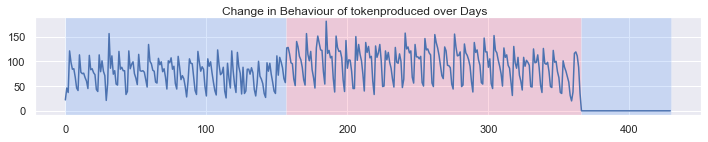

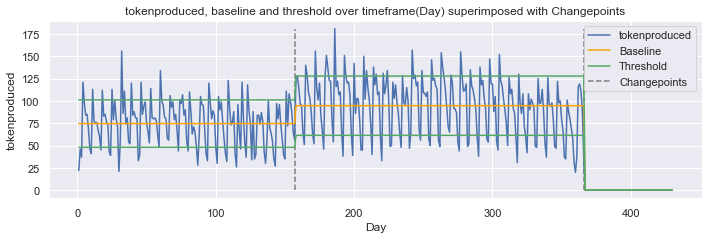

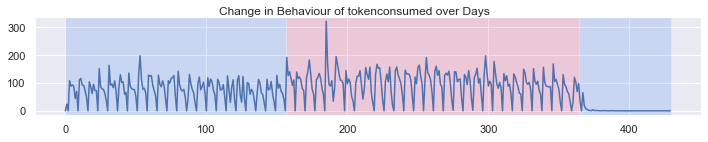

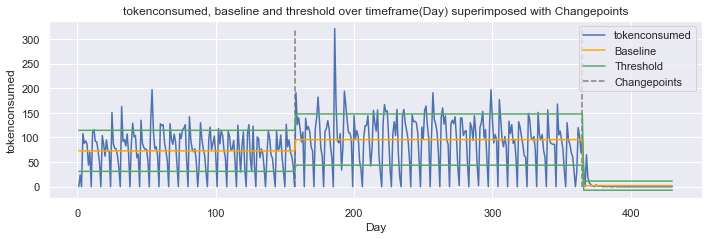

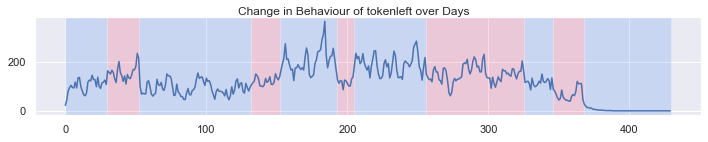

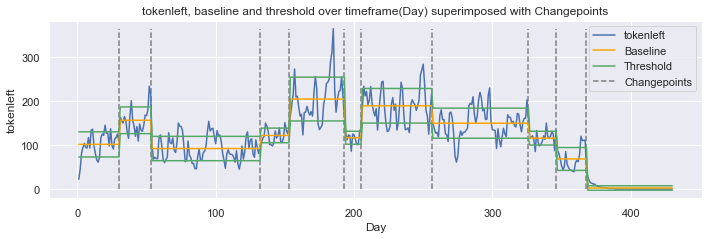

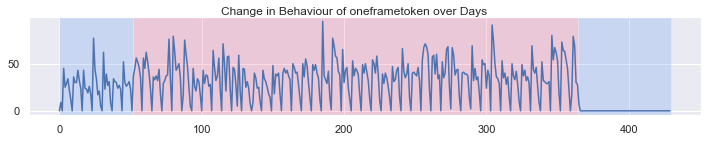

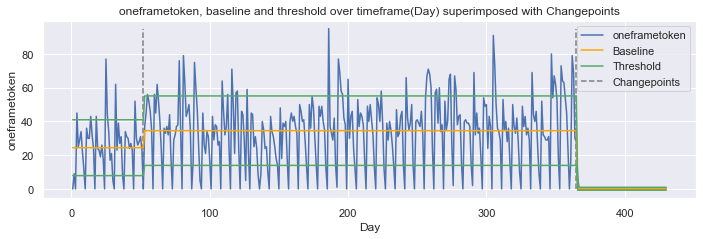

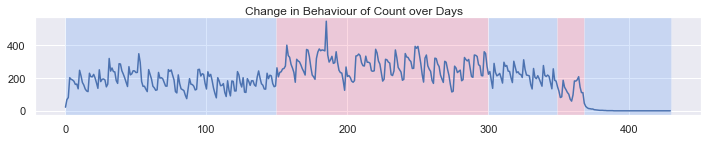

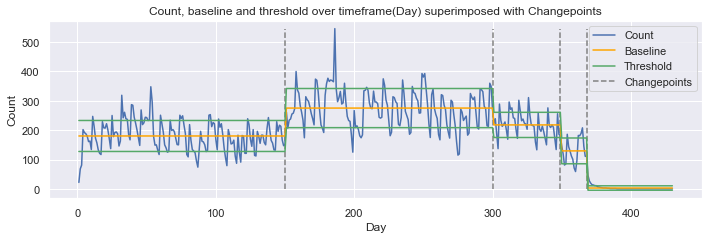

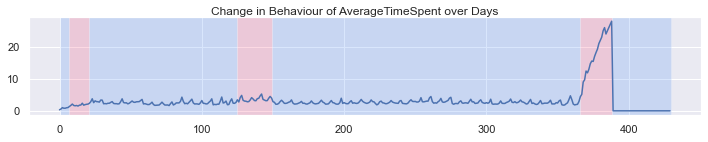

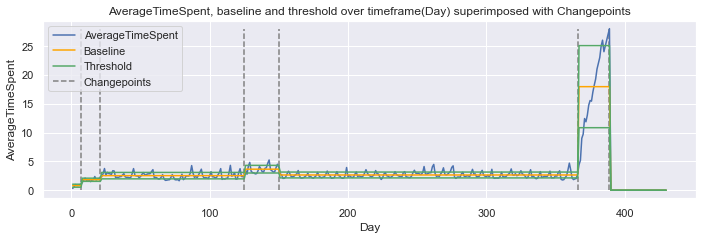

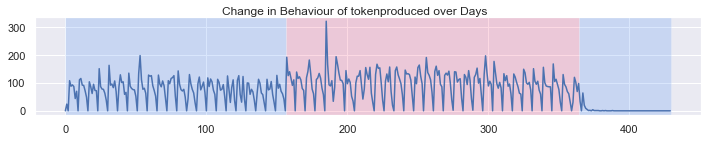

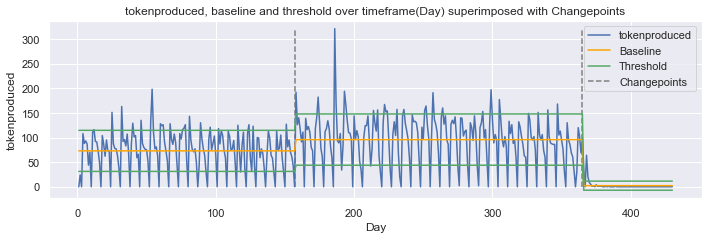

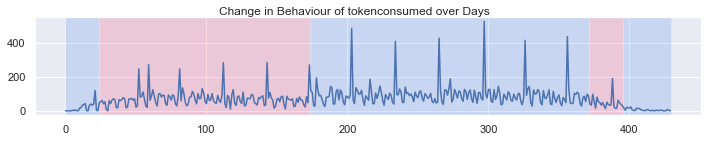

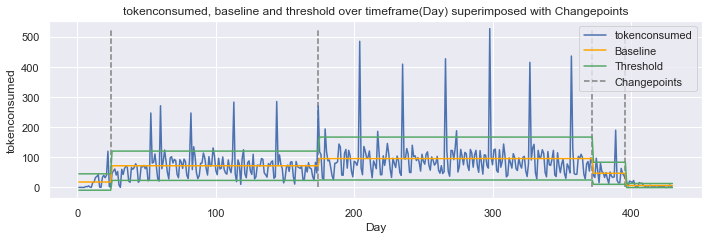

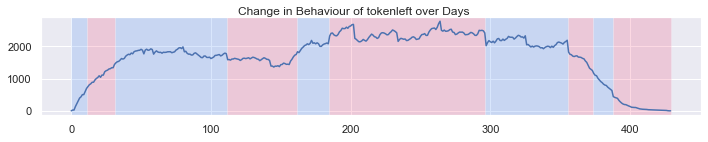

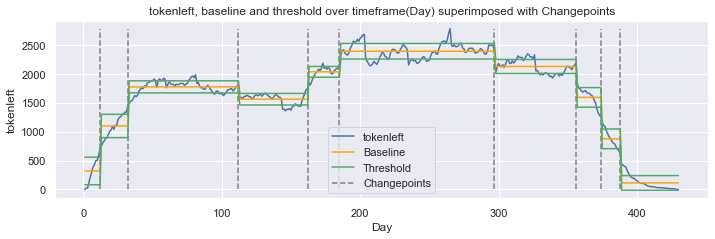

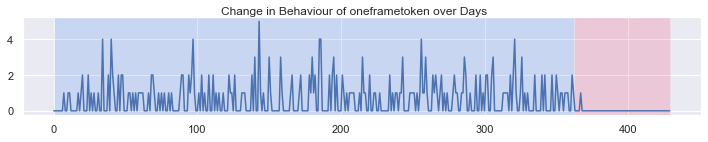

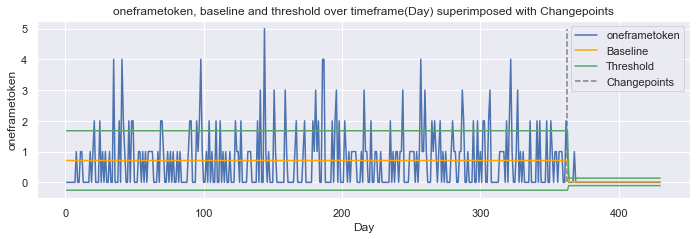

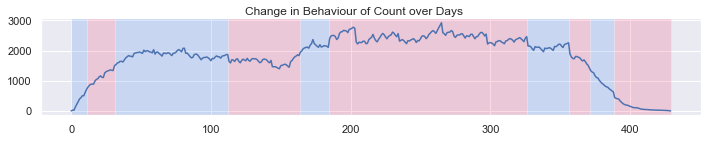

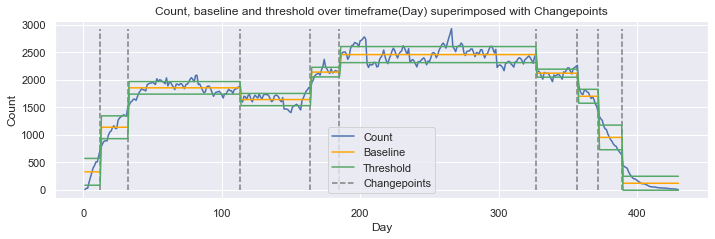

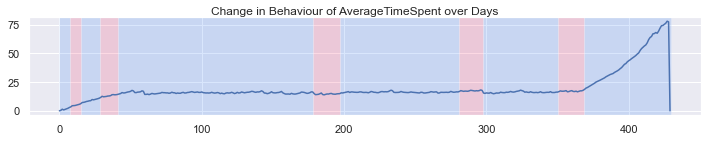

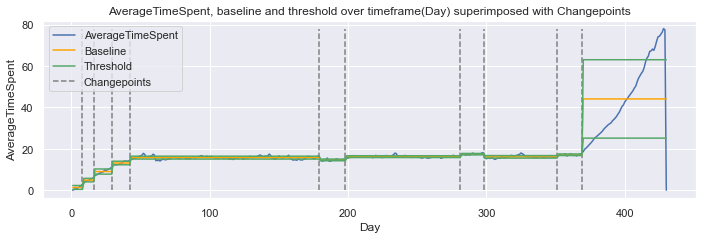

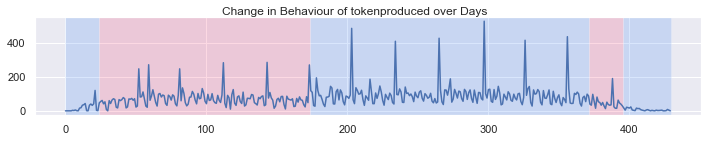

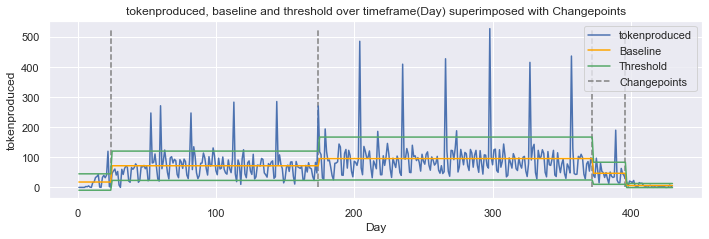

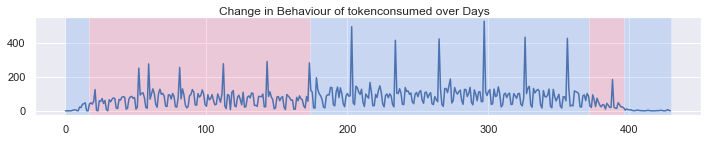

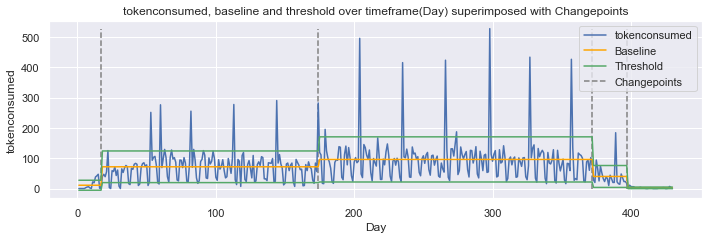

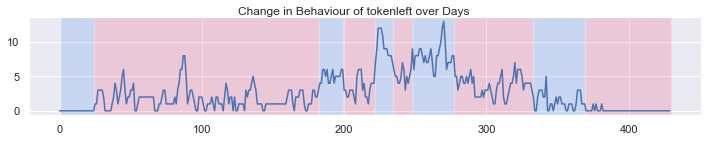

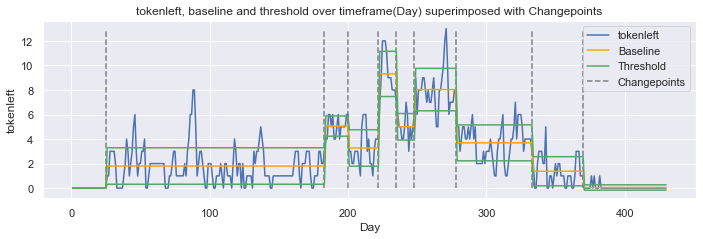

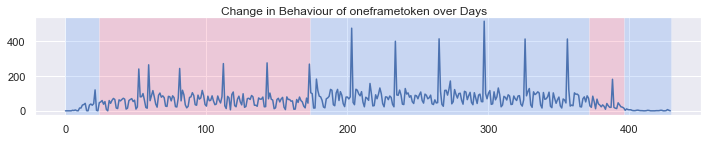

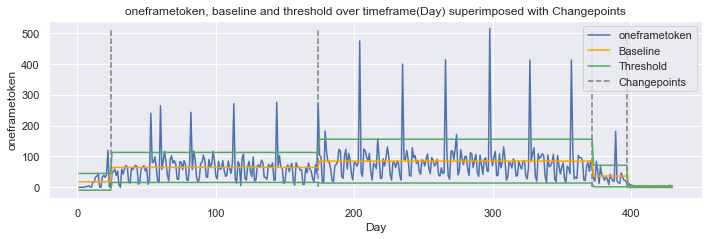

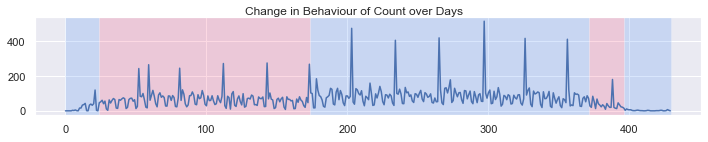

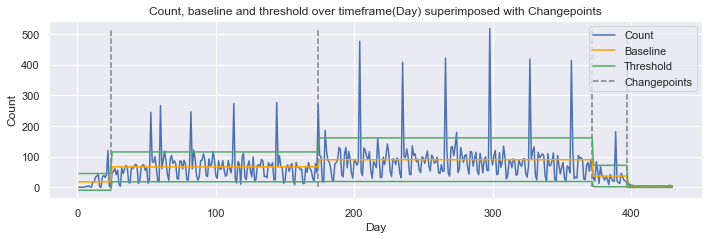

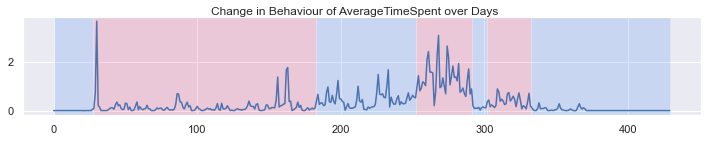

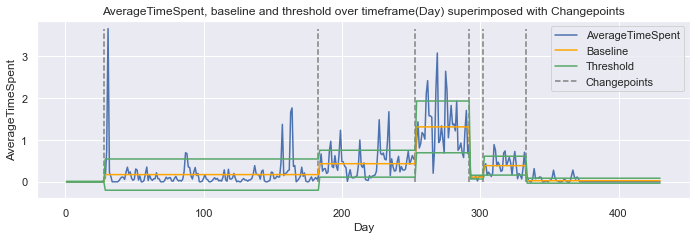

In [15]:
import warnings
warnings.filterwarnings('ignore')
if timeFrame=='H':
    timeFrameValue='Hour'
if timeFrame=='D':
    timeFrameValue='Day'
if timeFrame=='W':
    timeFrameValue='Week'
if timeFrame=='M':
    timeFrameValue='Month'

process(CreateLoanApplicationZoneDF)
process(ProcessZoneDF)
process(DecisionZoneDF)


featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']
CreateLoanApplicationZoneDF.name = 'Create Loan Application Zone'
ProcessZoneDF.name = 'Process Zone'
DecisionZoneDF.name = 'Offer Zone'
targetzonelist=[CreateLoanApplicationZoneDF,ProcessZoneDF,DecisionZoneDF]
pen=4

for zone in targetzonelist:
    AnalyzeZone(zone,featurelist,pen,True)

zonelist=[]
for zone in targetzonelist:
    newzone=zone.iloc[:, :-6].copy()
    zonelist.append(newzone)
    

index already exists
index already exists
index already exists
Process Zone tokenproduced [157, 365]
Process Zone tokenconsumed [24, 174, 372, 396]


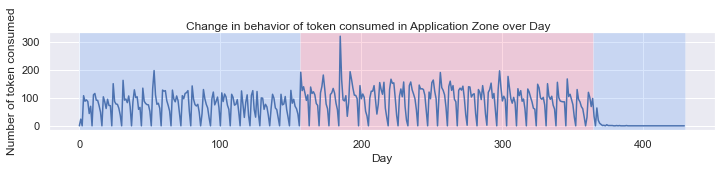

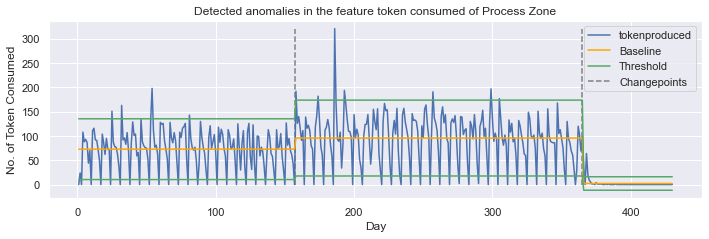

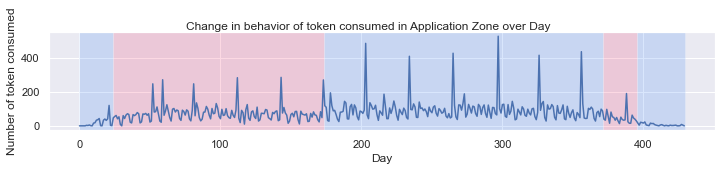

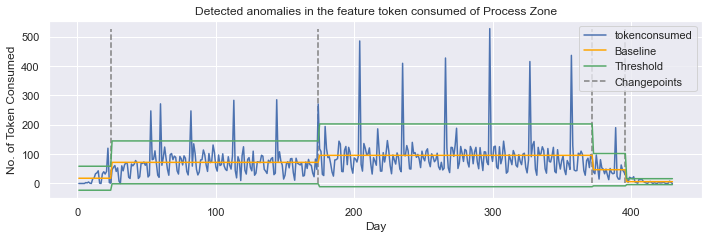

In [51]:
# with better names and title
import warnings
warnings.filterwarnings('ignore')
if timeFrame=='H':
    timeFrameValue='Hour'
if timeFrame=='D':
    timeFrameValue='Day'
if timeFrame=='W':
    timeFrameValue='Week'
if timeFrame=='M':
    timeFrameValue='Month'

process(CreateLoanApplicationZoneDF)
process(ProcessZoneDF)
process(DecisionZoneDF)


featurelist=['tokenproduced', 'tokenconsumed']
CreateLoanApplicationZoneDF.name = 'Create Loan Application Zone'
ProcessZoneDF.name = 'Process Zone'
DecisionZoneDF.name = 'Decsion Zone'
targetzonelist=[ProcessZoneDF]
pen=4

for zone in targetzonelist:
    AnalyzeZone(zone,featurelist,pen,True)

zonelist=[]
for zone in targetzonelist:
    newzone=zone.iloc[:, :-6].copy()
    zonelist.append(newzone)
    

# Task 2- Analysis of Interconnections

In [19]:
zonelist=[CreateLoanApplicationZoneDF,ProcessZoneDF,DecisionZoneDF]
featurelist=['tokenproduced', 'tokenconsumed', 'tokenleft','oneframetoken', 'Count', 'AverageTimeSpent']

CreateLoanApplicationZoneDF.name = 'Create Loan Application Zone'
ProcessZoneDF.name = 'Process Zone'
DecisionZoneDF.name = 'Decision Zone'

Corrdataframe=pd.DataFrame(columns= ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])     
for targetZone in zonelist:
    for targetFeature in featurelist:
        for zone in zonelist:
            lagsum=0
            for feature in featurelist:
                maxlag,maxcorr = max_lag(targetZone[targetFeature].dropna(),zone[feature].dropna())
                corrow_df = pd.DataFrame([[targetZone.name, targetFeature,zone.name, feature, maxlag,maxcorr]],columns=  ['targetZone','targetFeature','sourceZone','sourceFeature','lag','MaxCorr'])
                Corrdataframe = pd.concat([corrow_df, Corrdataframe], ignore_index=True)
Data=Corrdataframe[Corrdataframe['MaxCorr']>0.7].sort_values(by='lag', ascending=False)

In [24]:
Data[Data['lag']>0].sort_values(by=['MaxCorr'], ascending=False)

targetZone     targetFeature  \
135                  Process Zone             Count   
249  Create Loan Application Zone             Count   
120                  Process Zone  AverageTimeSpent   
139                  Process Zone             Count   
175                  Process Zone         tokenleft   
141                  Process Zone             Count   
177                  Process Zone         tokenleft   
143                  Process Zone             Count   
179                  Process Zone         tokenleft   
321  Create Loan Application Zone     tokenproduced   

                       sourceZone     sourceFeature lag   MaxCorr  
135                  Process Zone         tokenleft   1  0.997998  
249  Create Loan Application Zone         tokenleft   1  0.958642  
120  Create Loan Application Zone  AverageTimeSpent  40  0.857748  
139  Create Loan Application Zone             Count  14  0.841578  
175  Create Loan Application Zone             Count  15  0.836492  
141  Create Loan Application Zone         tokenleft  17  0.804954  
177  Create Loan Application Zone         tokenleft  17  0.803713  
143  Create Loan Application Zone     tokenproduced  14  0.735708  
179  Create Loan Application Zone     tokenproduced  15  0.724062  
321  Create Loan Application Zone         tokenleft   1  0.724038

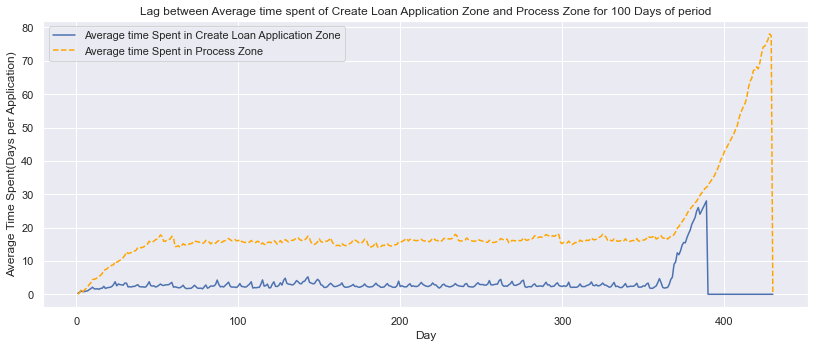

In [27]:
sns.set(rc={'figure.figsize':(13.7,5.27)})
sns.lineplot(data=CreateLoanApplicationZoneDF, x='index', y='AverageTimeSpent', color='b',label='Average time Spent in Create Loan Application Zone').set(title='Lag between Average time spent of Create Loan Application Zone and Process Zone for 100 Days of period')
sns.lineplot(data=ProcessZoneDF, x='index', y='AverageTimeSpent',linestyle='--',color='orange', label="Average time Spent in Process Zone")
plt.xlabel(timeFrameValue)
plt.ylabel('Average Time Spent(Days per Application)')
plt.show()

# Task 3- Prediction 

Create Loan Application Zone
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.09322033898305085
Mean Squared error LR- 0.3053200599093529
Accuracy: 0.9067796610169492
F1: 0.8892018779342723
Precision: 0.9074866310160428
Recall: 0.8759868421052632


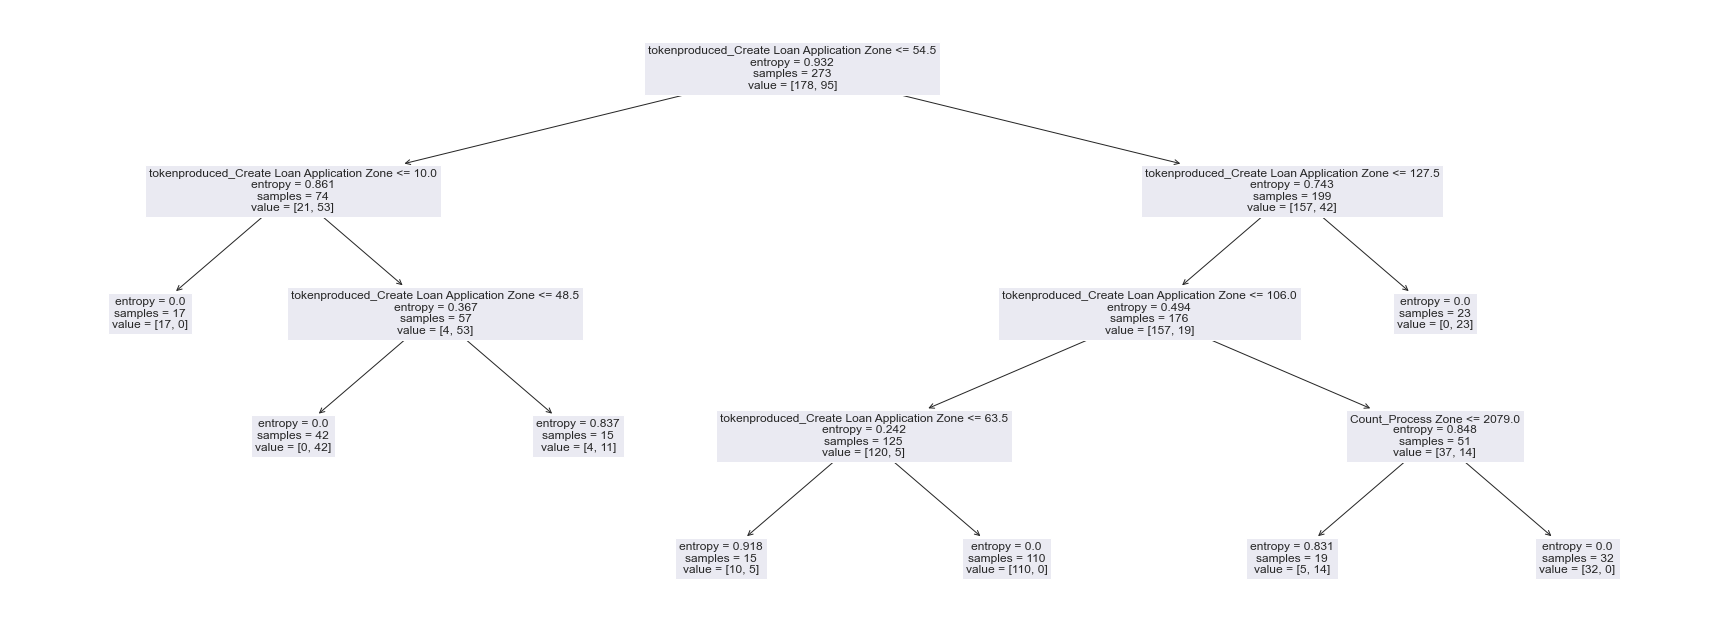

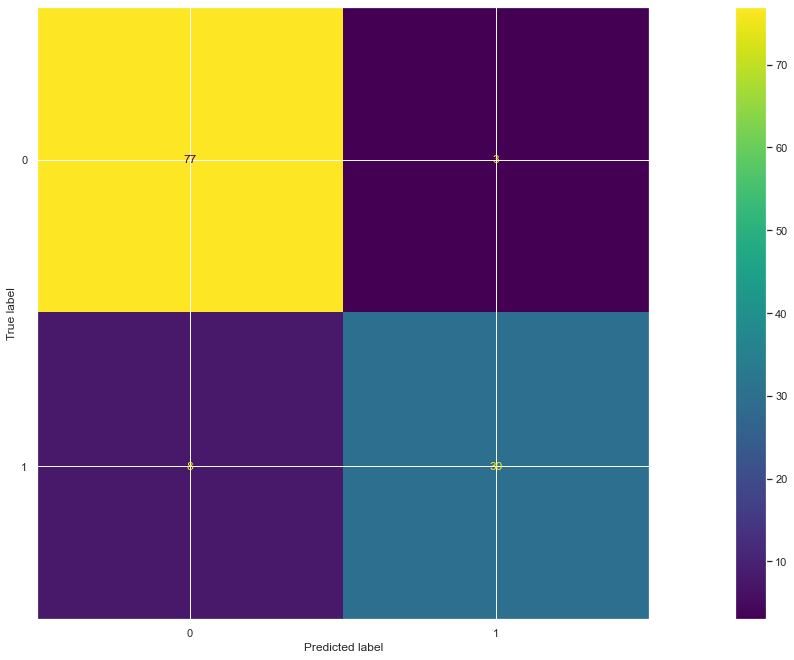

feature- Strange_tokenproduced :  Day : 8
Mean absolute error LR- 0.1864406779661017
Mean Squared error LR- 0.4317877695883728
Accuracy: 0.8135593220338984
F1: 0.7834501167834501
Precision: 0.7990196078431373
Recall: 0.7737179487179487


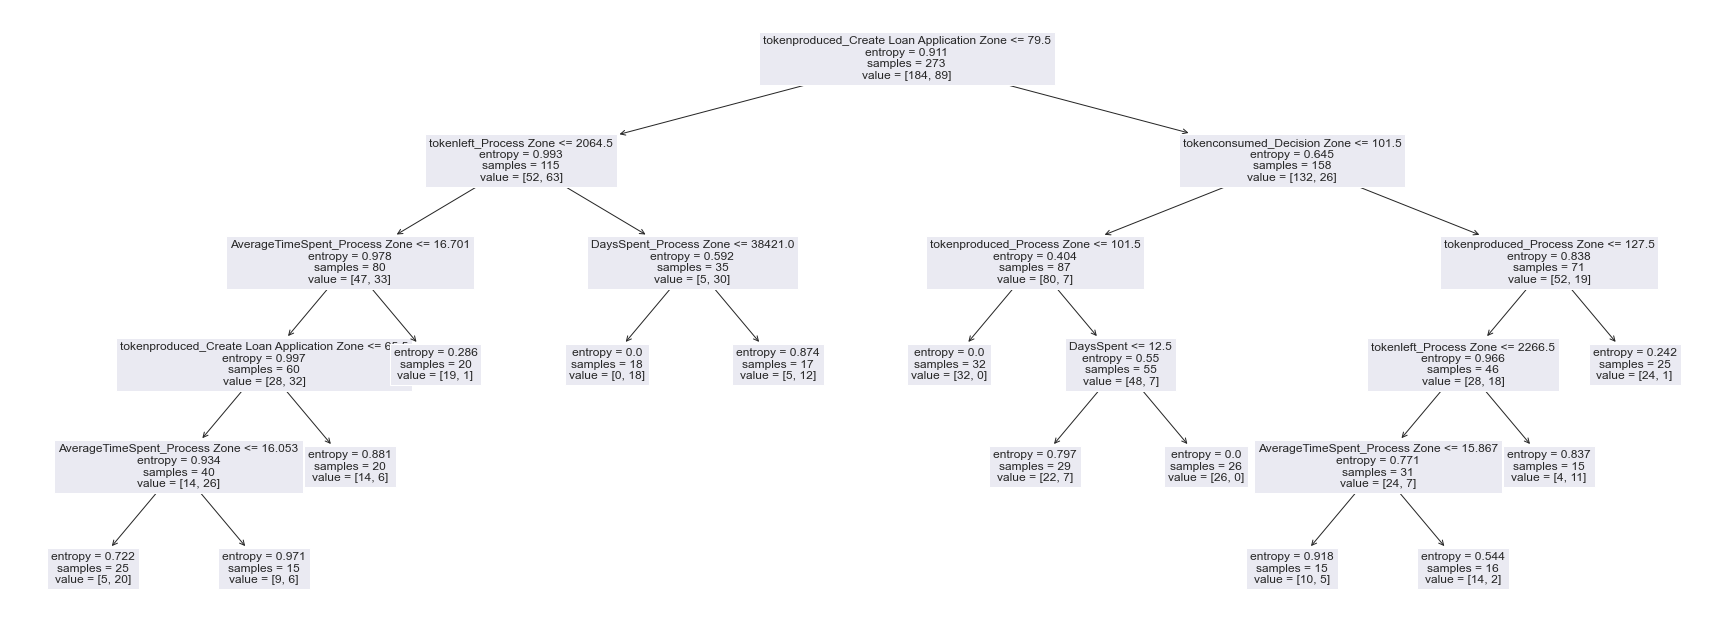

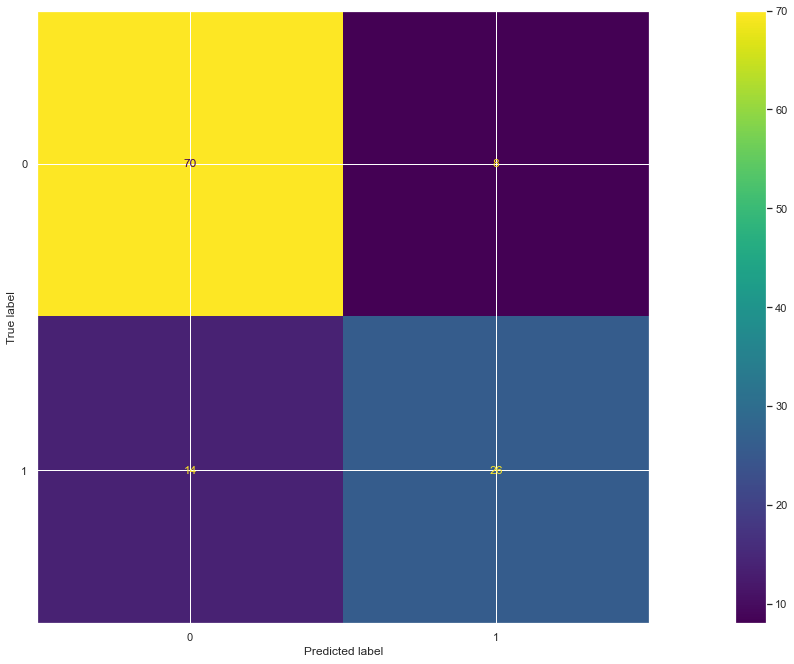

feature- Strange_tokenproduced :  Day : 14
Mean absolute error LR- 0.1864406779661017
Mean Squared error LR- 0.4317877695883728
Accuracy: 0.8135593220338984
F1: 0.764171511627907
Precision: 0.7593582887700534
Recall: 0.7697441601779755


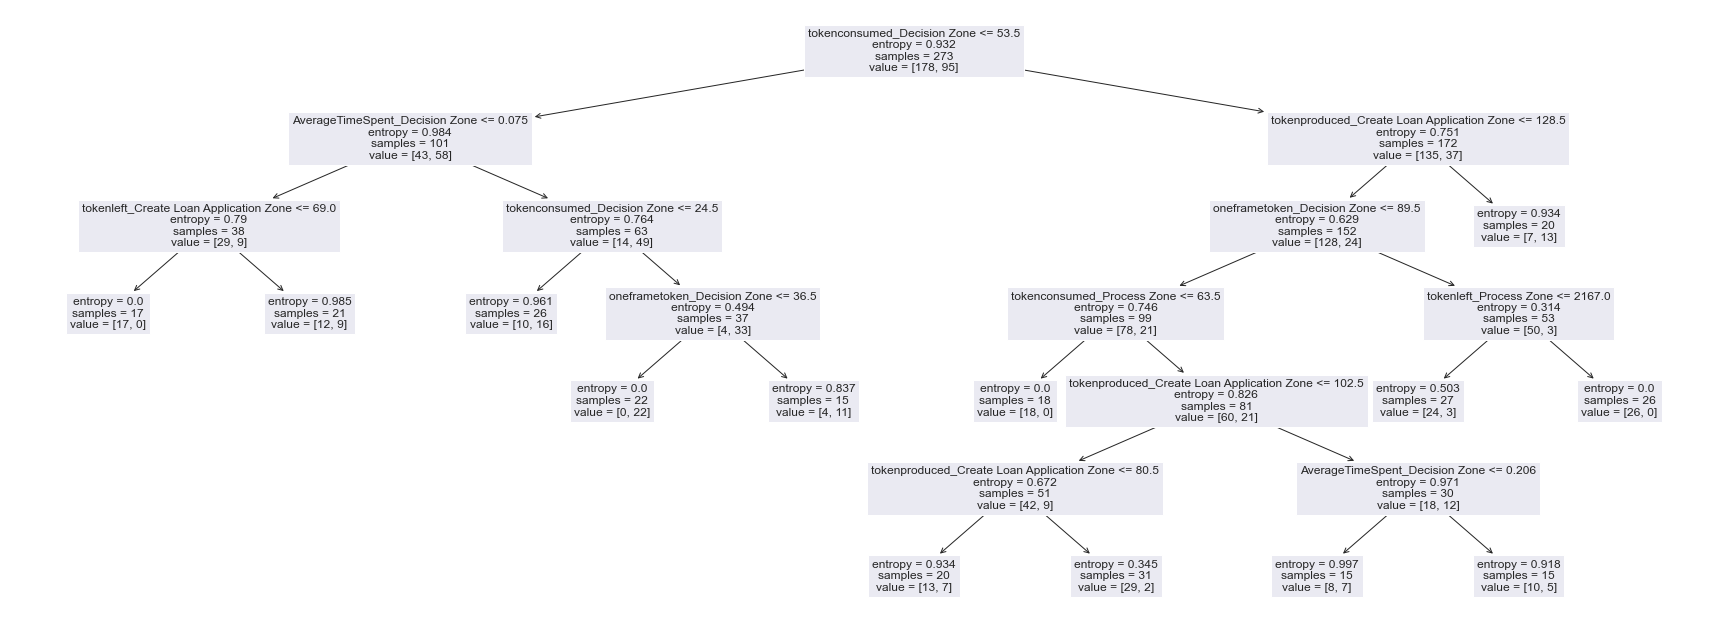

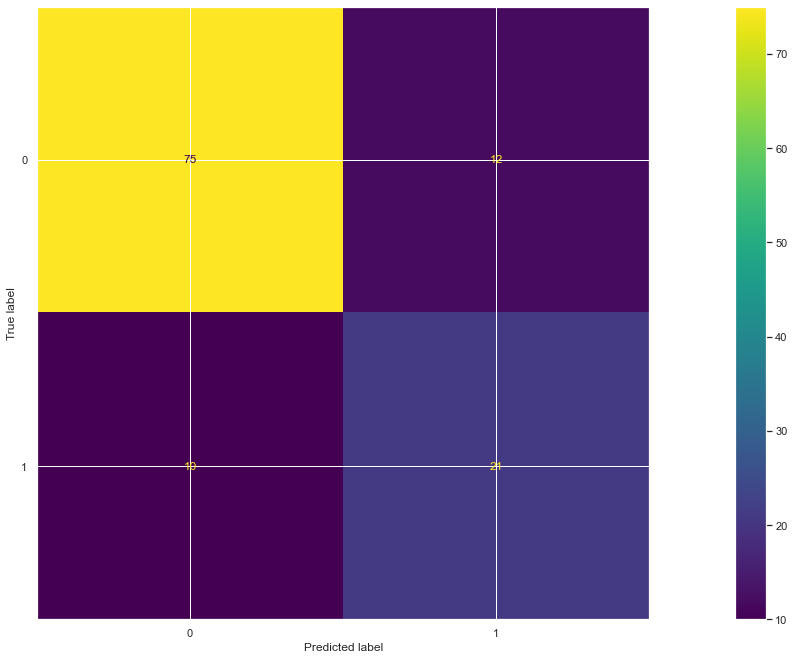

feature- Strange_tokenproduced :  Day : 28
Mean absolute error LR- 0.1694915254237288
Mean Squared error LR- 0.41169348479630913
Accuracy: 0.8305084745762712
F1: 0.7765151515151515
Precision: 0.7904761904761906
Recall: 0.7659883720930232


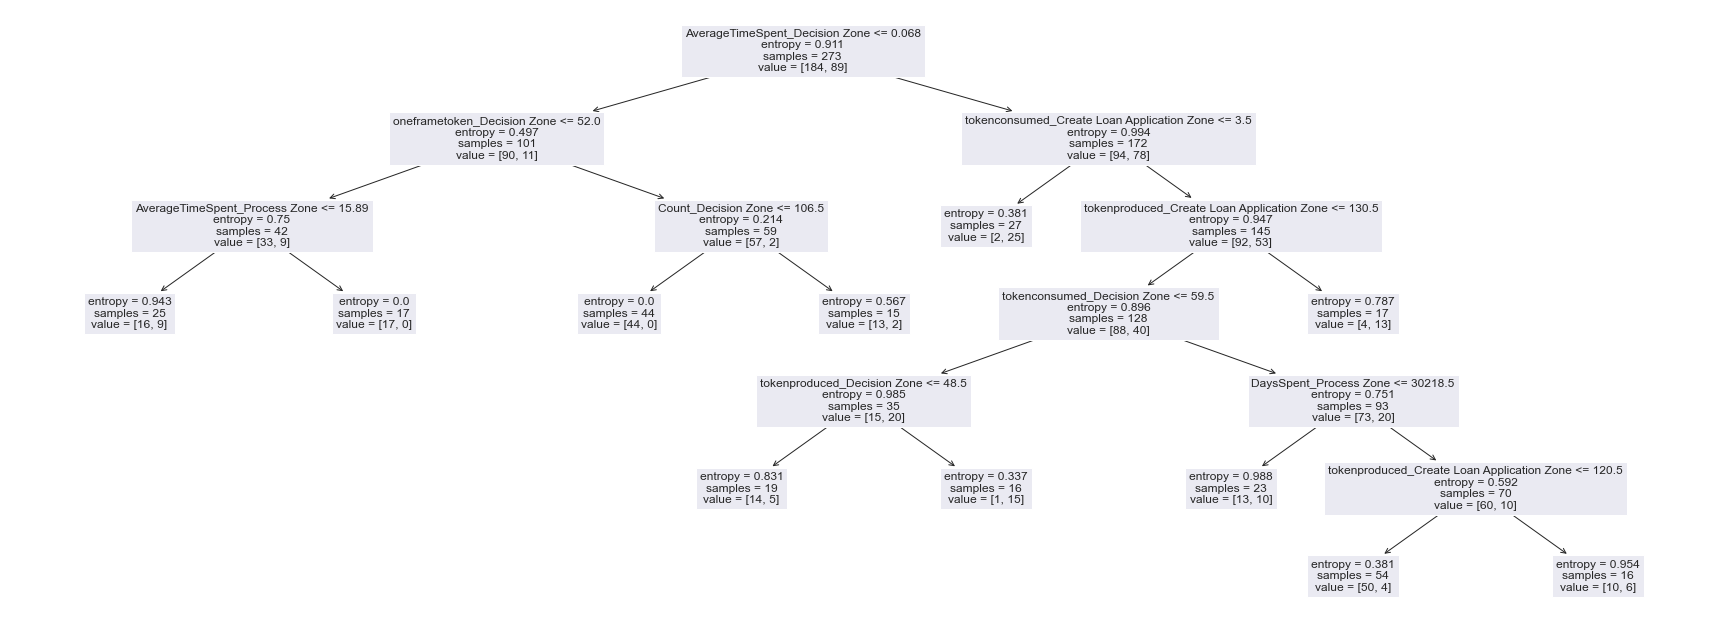

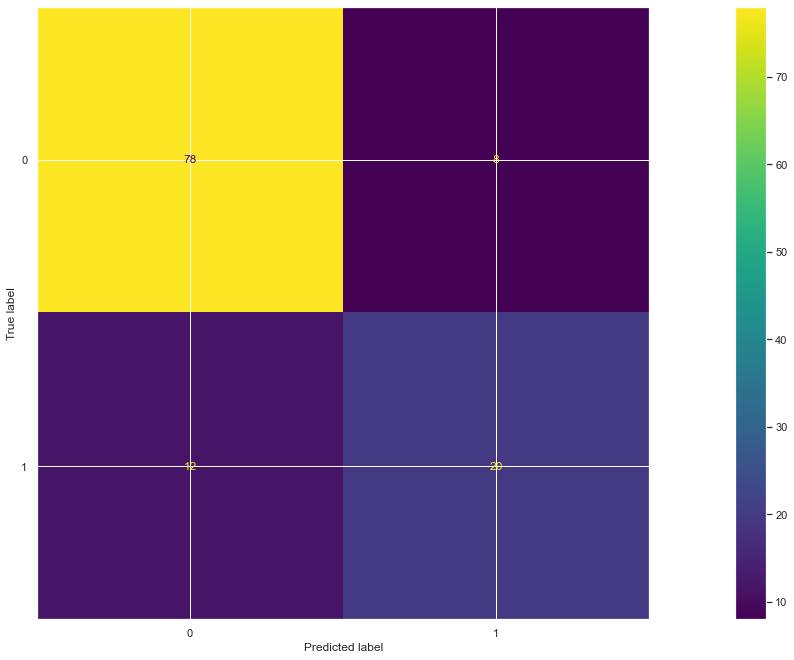

feature- Strange_tokenproduced :  Day : 33
Mean absolute error LR- 0.19491525423728814
Mean Squared error LR- 0.4414920772078341
Accuracy: 0.8050847457627118
F1: 0.7719136061853937
Precision: 0.7740514905149052
Recall: 0.7699366032699366


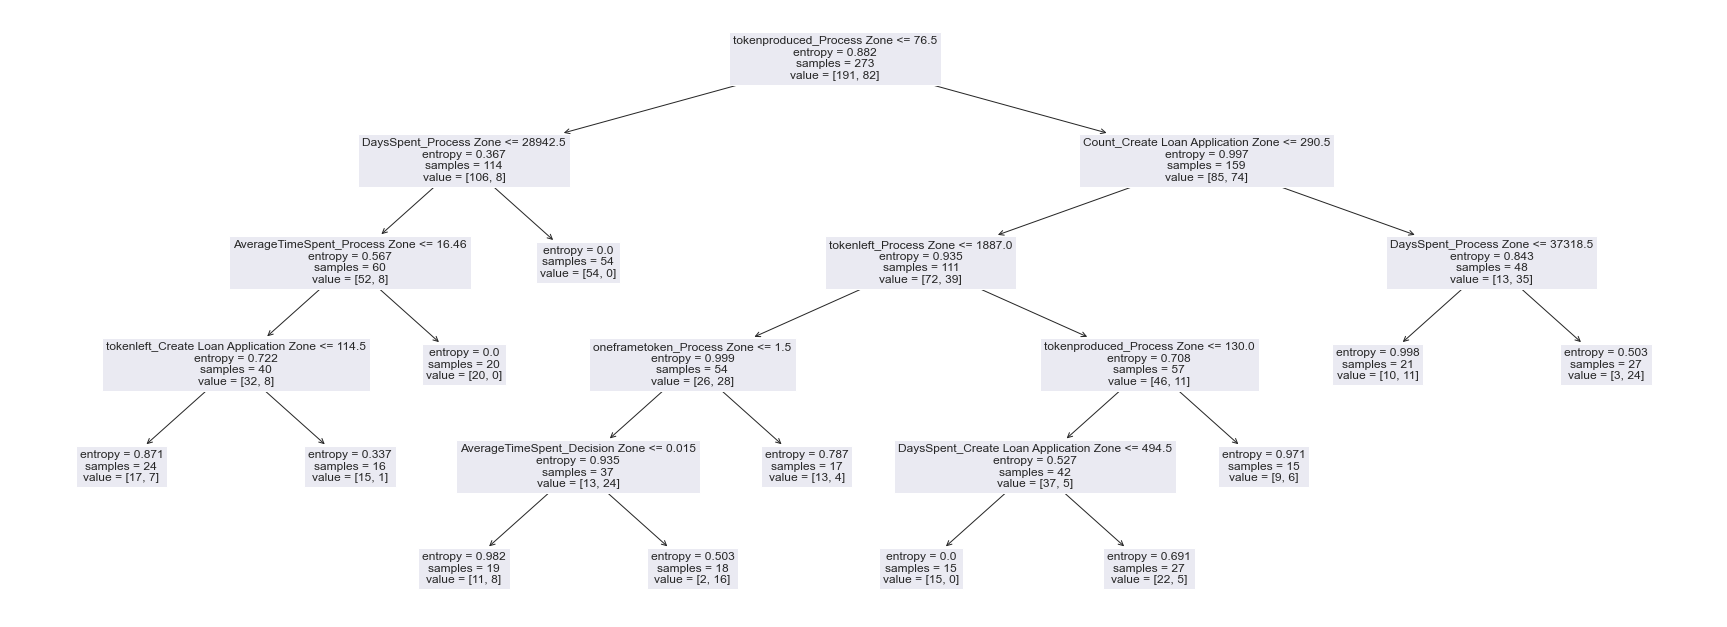

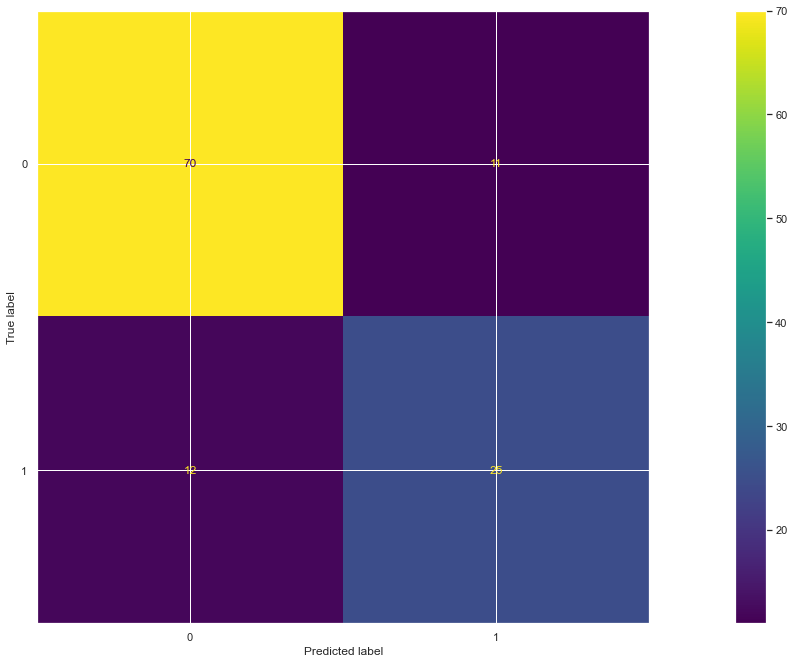

feature- Strange_tokenconsumed :  Day : 17
Mean absolute error LR- 0.19811320754716982
Mean Squared error LR- 0.4450990985692622
Accuracy: 0.8018867924528302
F1: 0.7422119281991895
Precision: 0.759753086419753
Recall: 0.7307017543859649


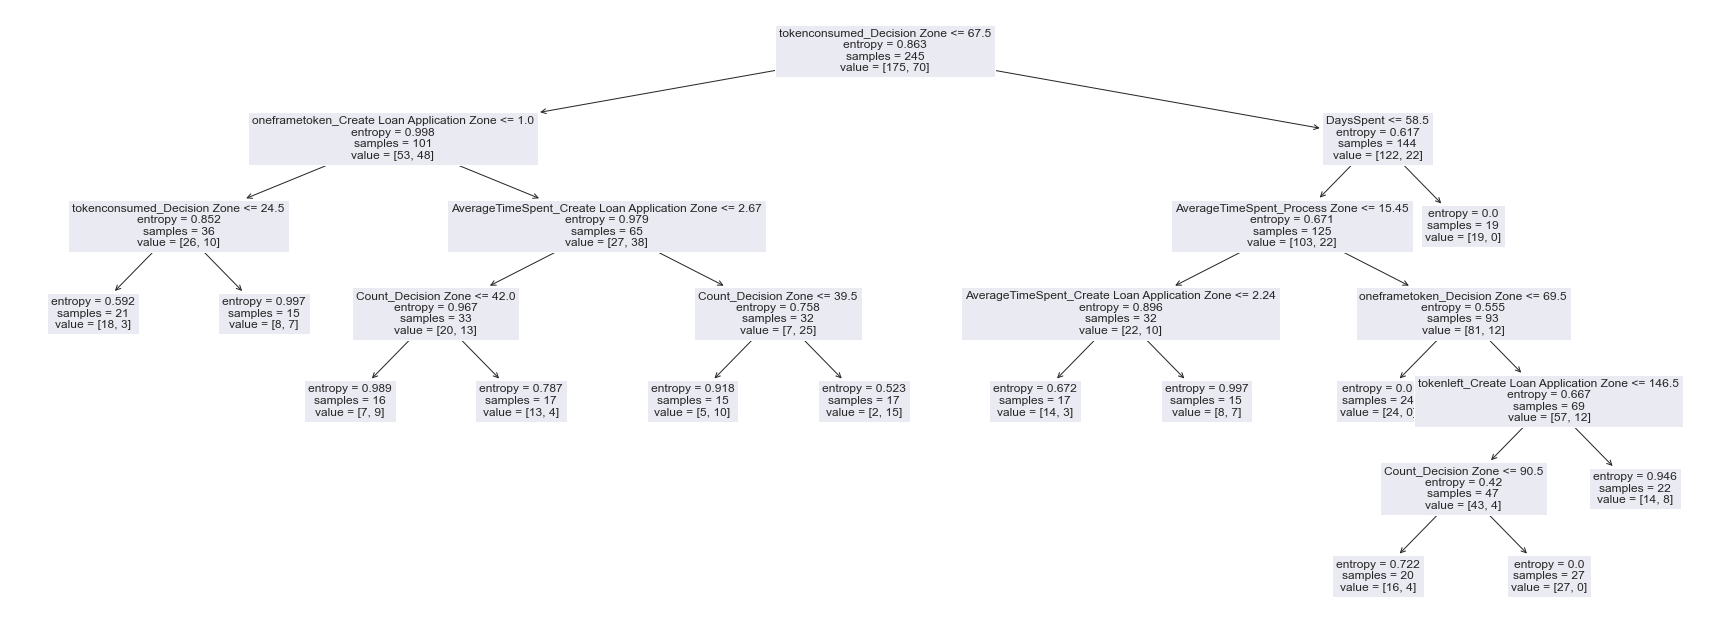

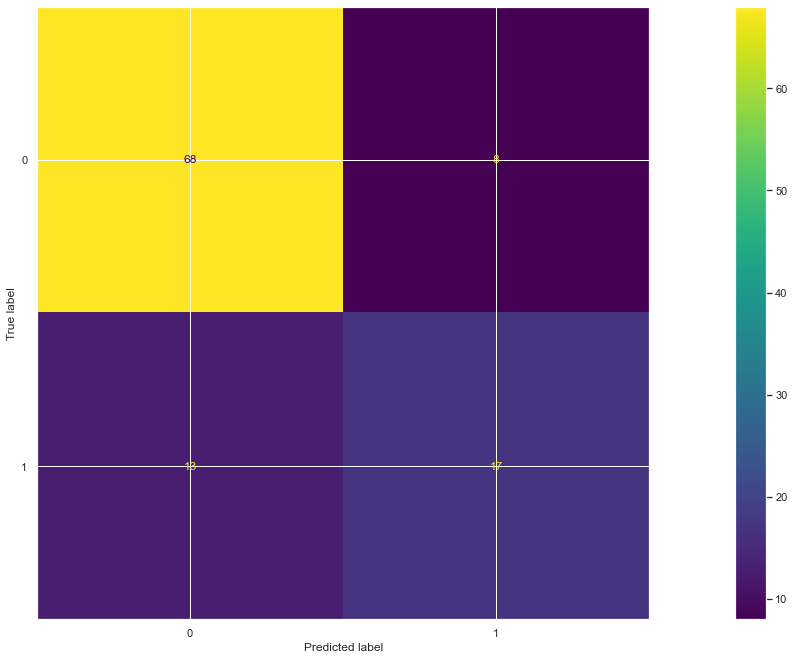

feature- Strange_tokenconsumed :  Day : 23
Mean absolute error LR- 0.1509433962264151
Mean Squared error LR- 0.38851434494290565
Accuracy: 0.8490566037735849
F1: 0.7778941854374017
Precision: 0.8625247851949769
Recall: 0.7456336766681595


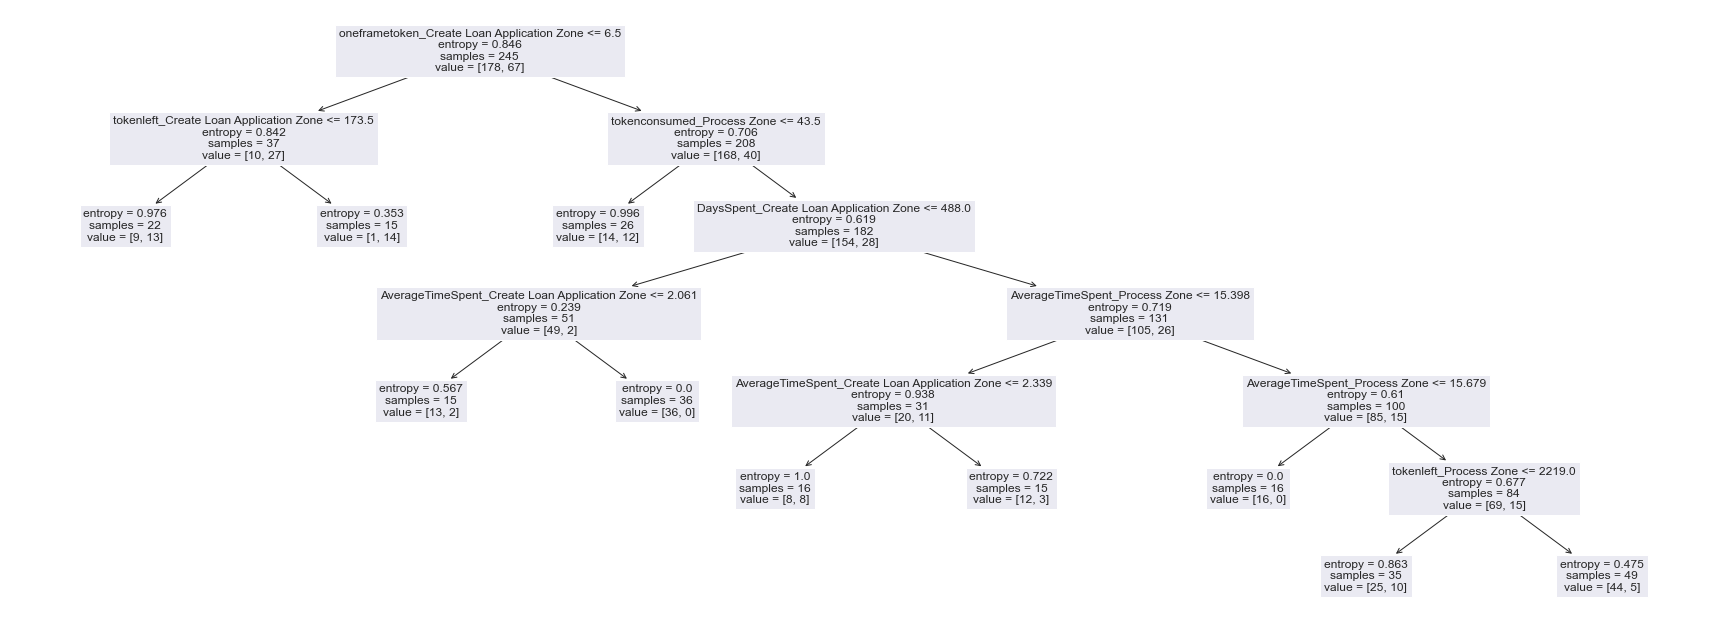

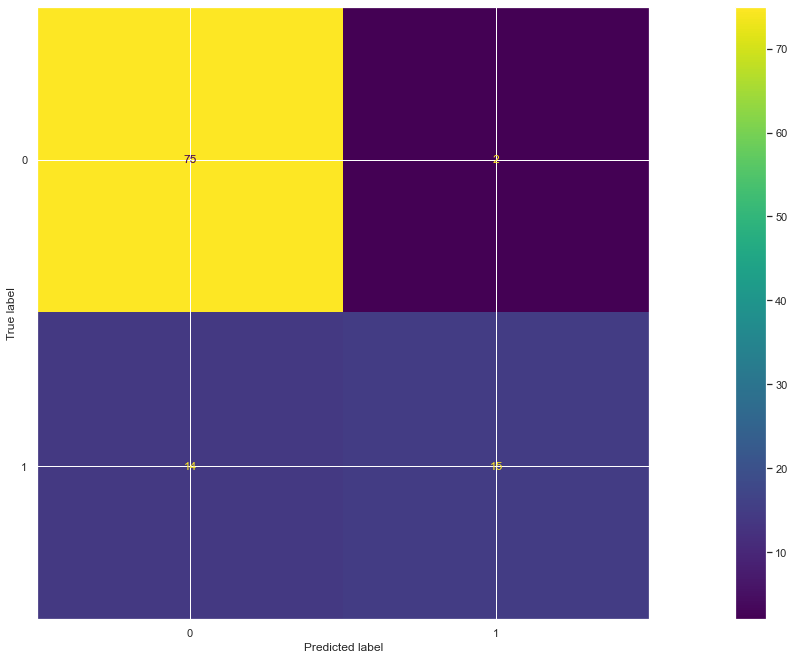

feature- Strange_tokenconsumed :  Day : 30
Mean absolute error LR- 0.1792452830188679
Mean Squared error LR- 0.42337369193050706
Accuracy: 0.8207547169811321
F1: 0.761006289308176
Precision: 0.7809959349593496
Recall: 0.7476489028213166


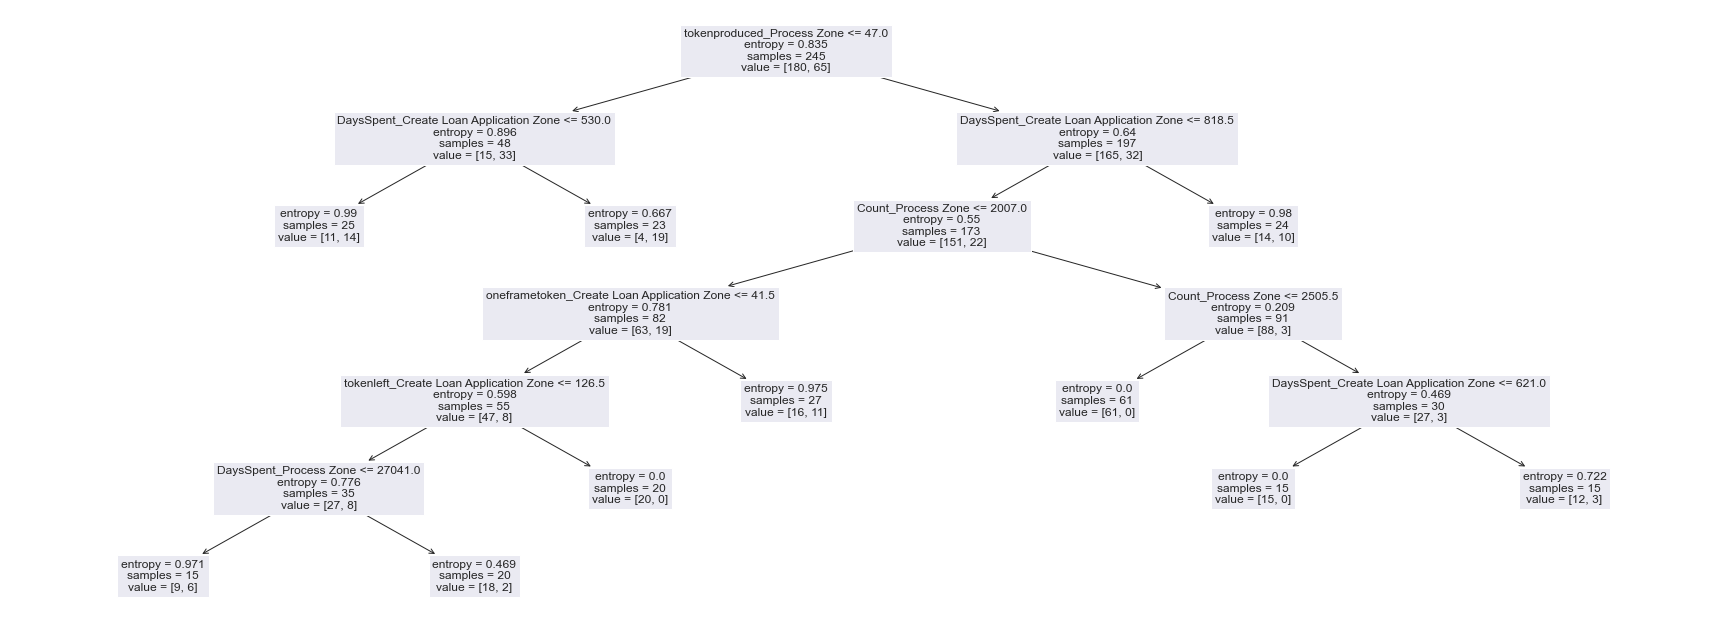

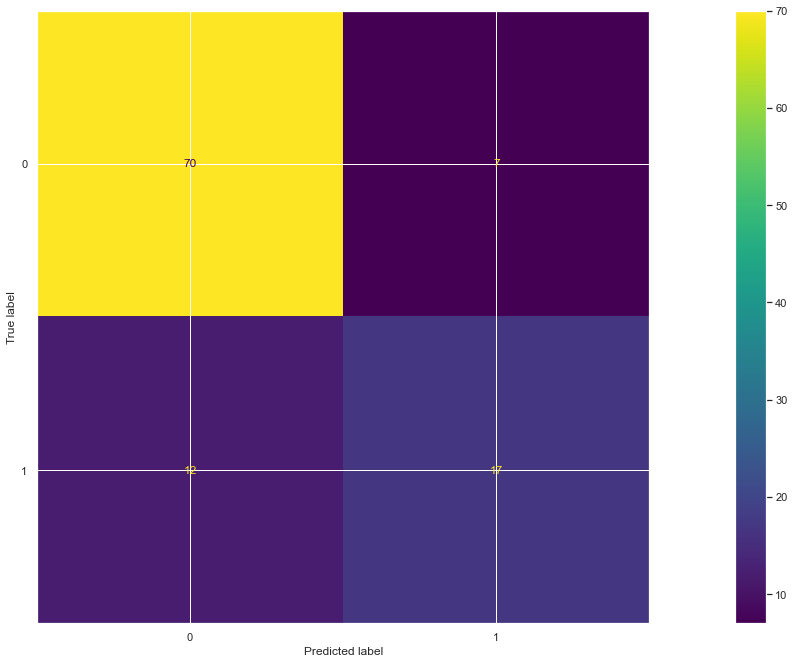

feature- Strange_oneframetoken :  Day : 34
Mean absolute error LR- 0.1951219512195122
Mean Squared error LR- 0.4417261042993862
Accuracy: 0.8048780487804879
F1: 0.7031674208144796
Precision: 0.740546218487395
Recall: 0.6846774193548387


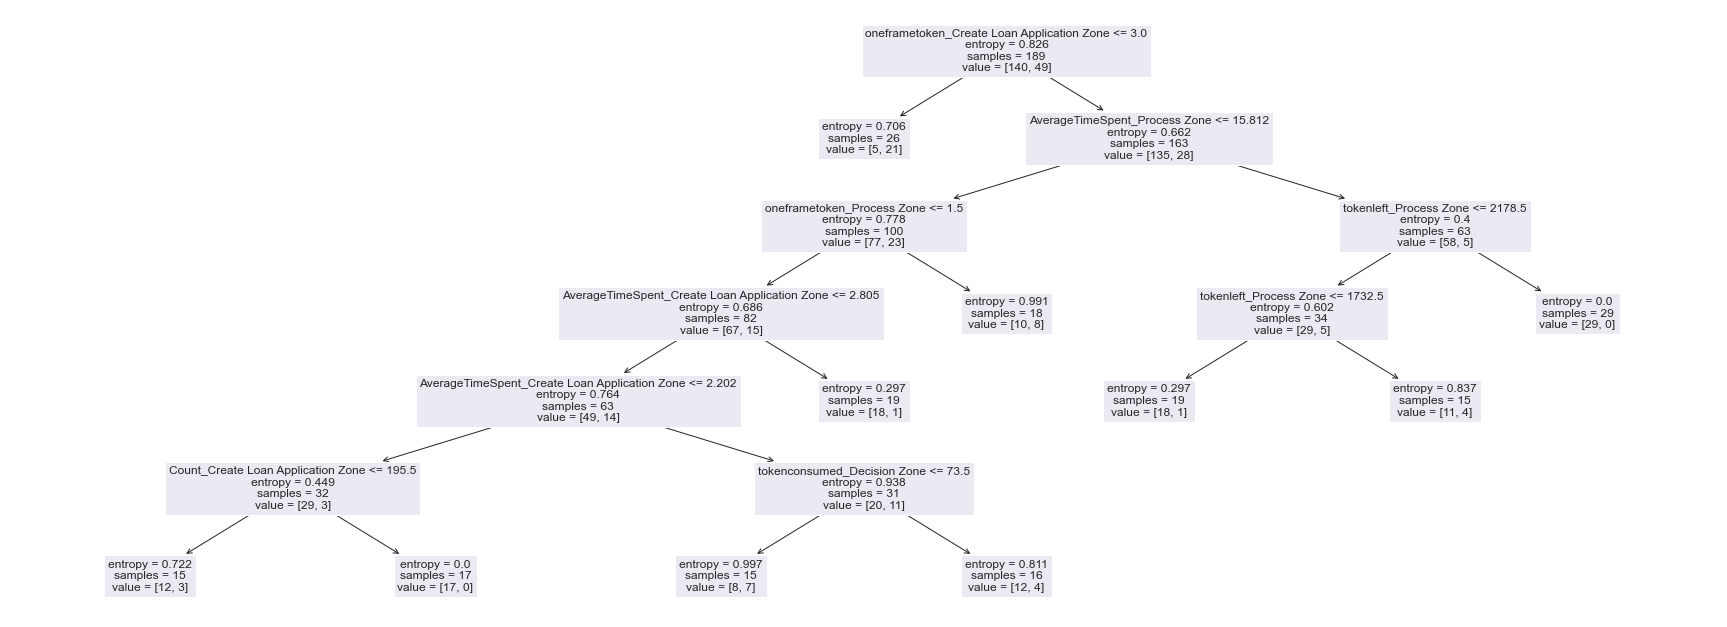

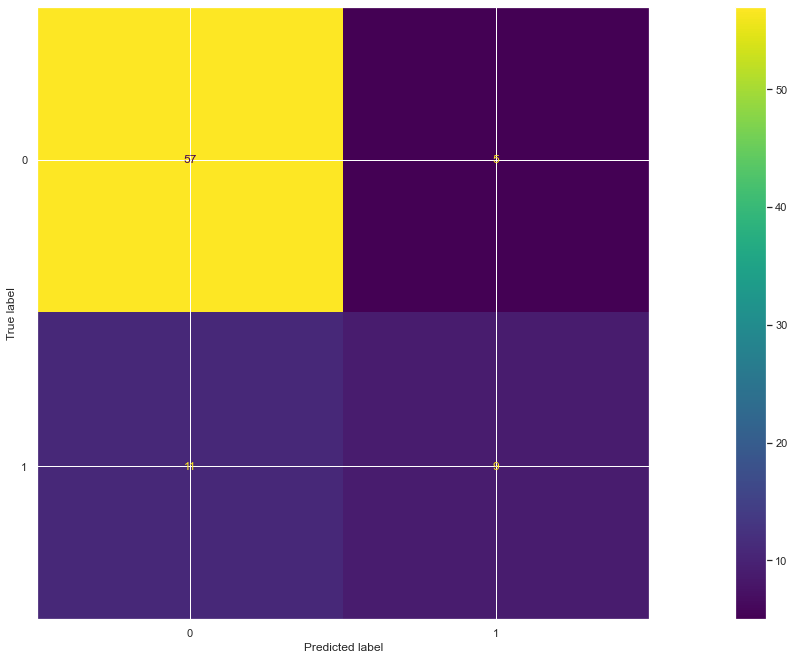

feature- Strange_oneframetoken :  Day : 35
Mean absolute error LR- 0.15853658536585366
Mean Squared error LR- 0.39816652969059774
Accuracy: 0.8414634146341463
F1: 0.7118140037848066
Precision: 0.7805555555555556
Recall: 0.6828054298642534


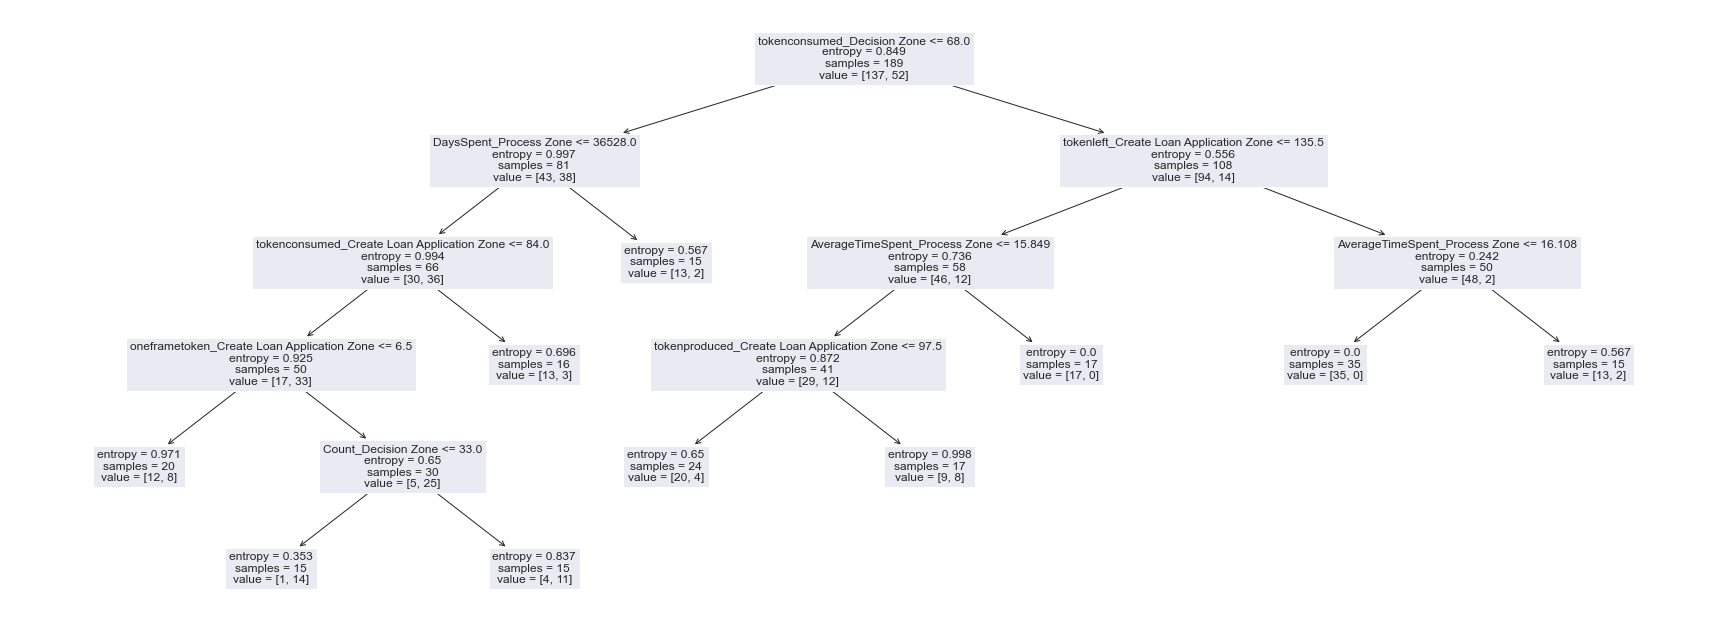

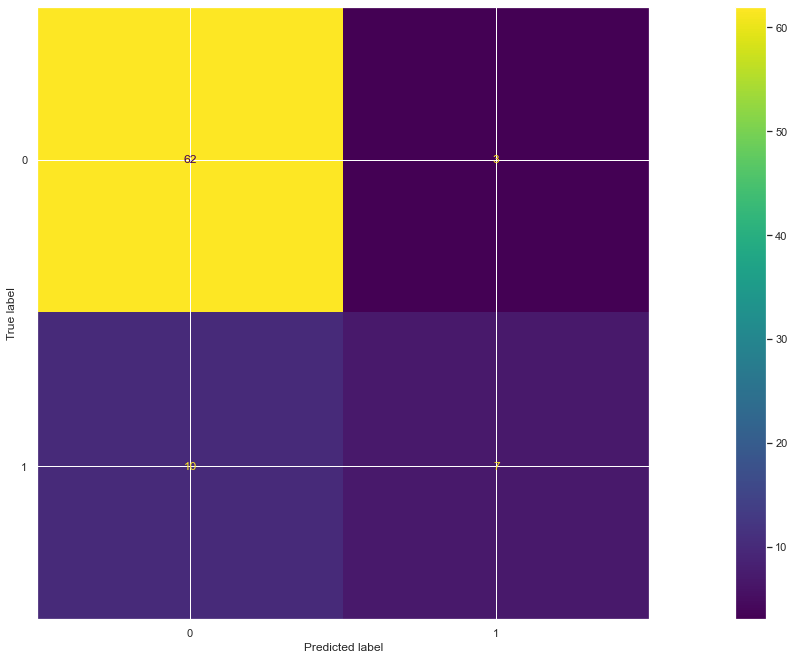

feature- Strange_AverageTimeSpent :  Day : 17
Mean absolute error LR- 0.1896551724137931
Mean Squared error LR- 0.4354941703556927
Accuracy: 0.8103448275862069
F1: 0.7017297802711546
Precision: 0.7517006802721089
Recall: 0.6801948051948051


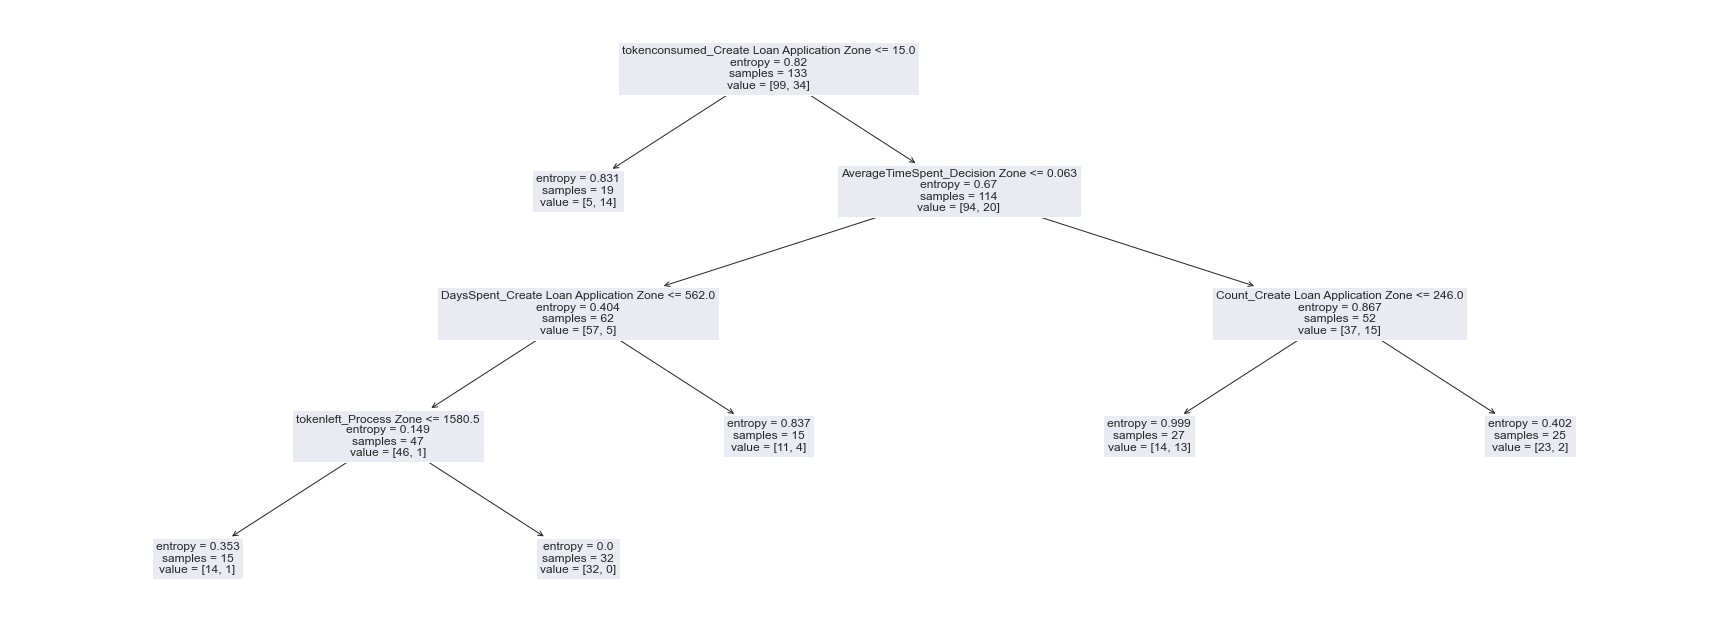

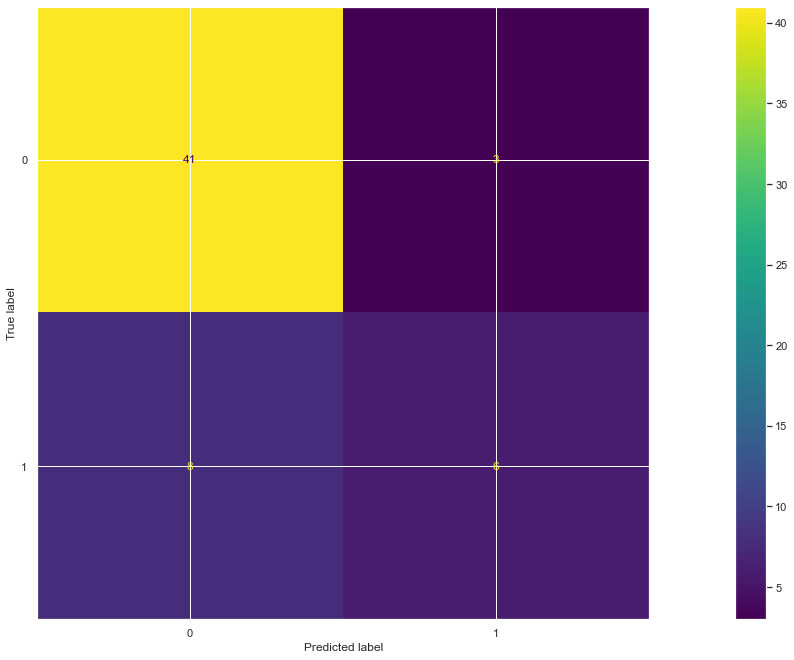

feature- Strange_AverageTimeSpent :  Day : 30
Mean absolute error LR- 0.13793103448275862
Mean Squared error LR- 0.3713906763541037
Accuracy: 0.8620689655172413
F1: 0.7898550724637681
Precision: 0.7743589743589744
Recall: 0.8104448742746615


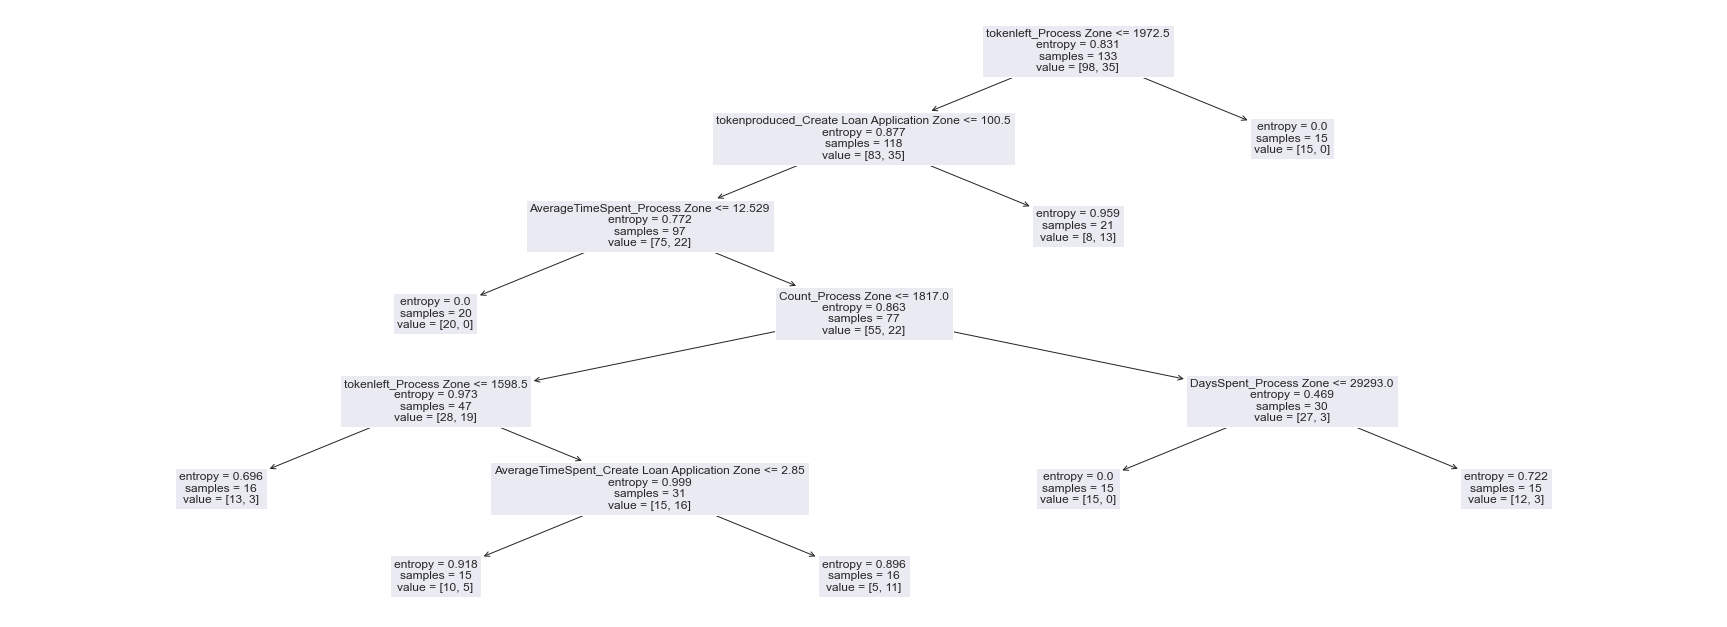

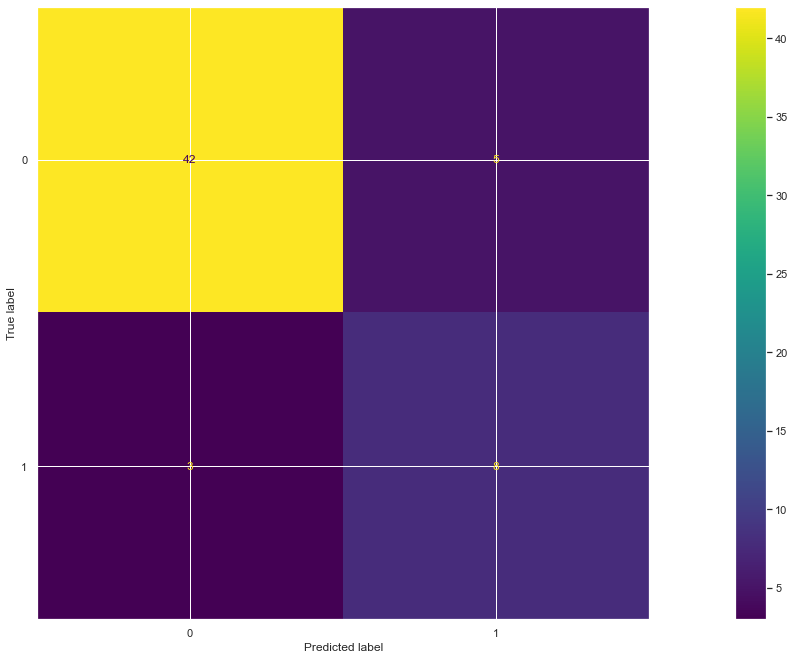

Process Zone
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.0847457627118644
Mean Squared error LR- 0.291111254869791
Accuracy: 0.9152542372881356
F1: 0.9029605263157894
Precision: 0.8862781954887218
Recall: 0.9317226890756303


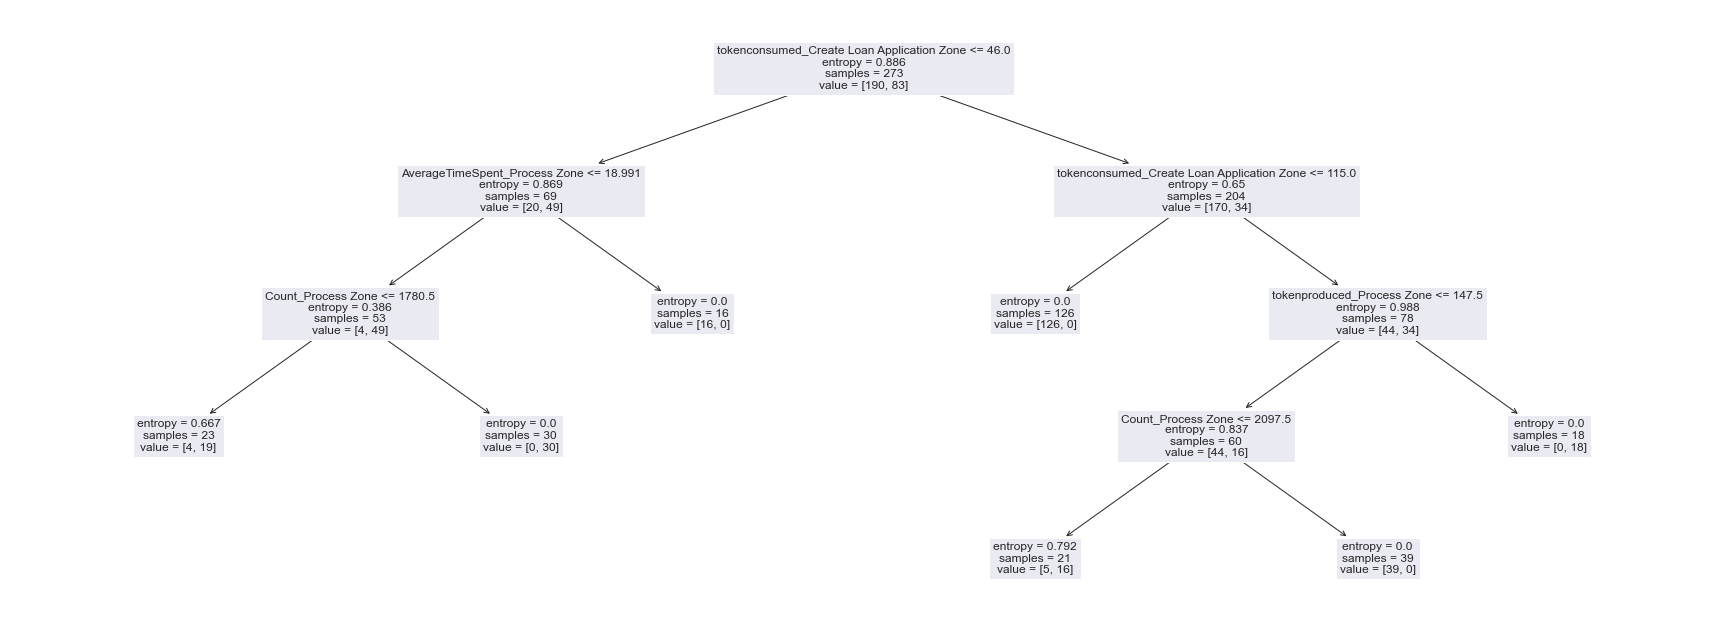

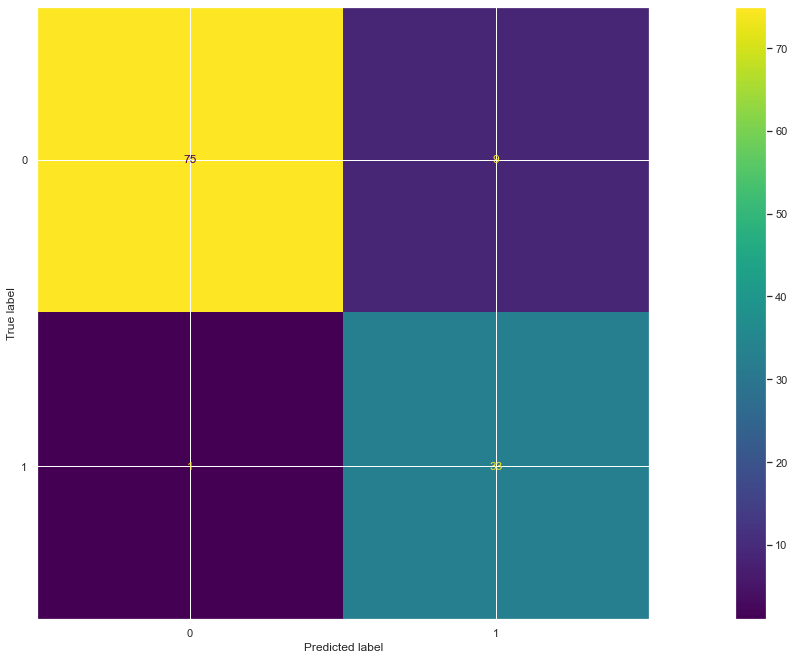

feature- Strange_tokenproduced :  Day : 1
Mean absolute error LR- 0.19491525423728814
Mean Squared error LR- 0.4414920772078341
Accuracy: 0.8050847457627118
F1: 0.7783223066241935
Precision: 0.7733974358974359
Recall: 0.7846179512846179


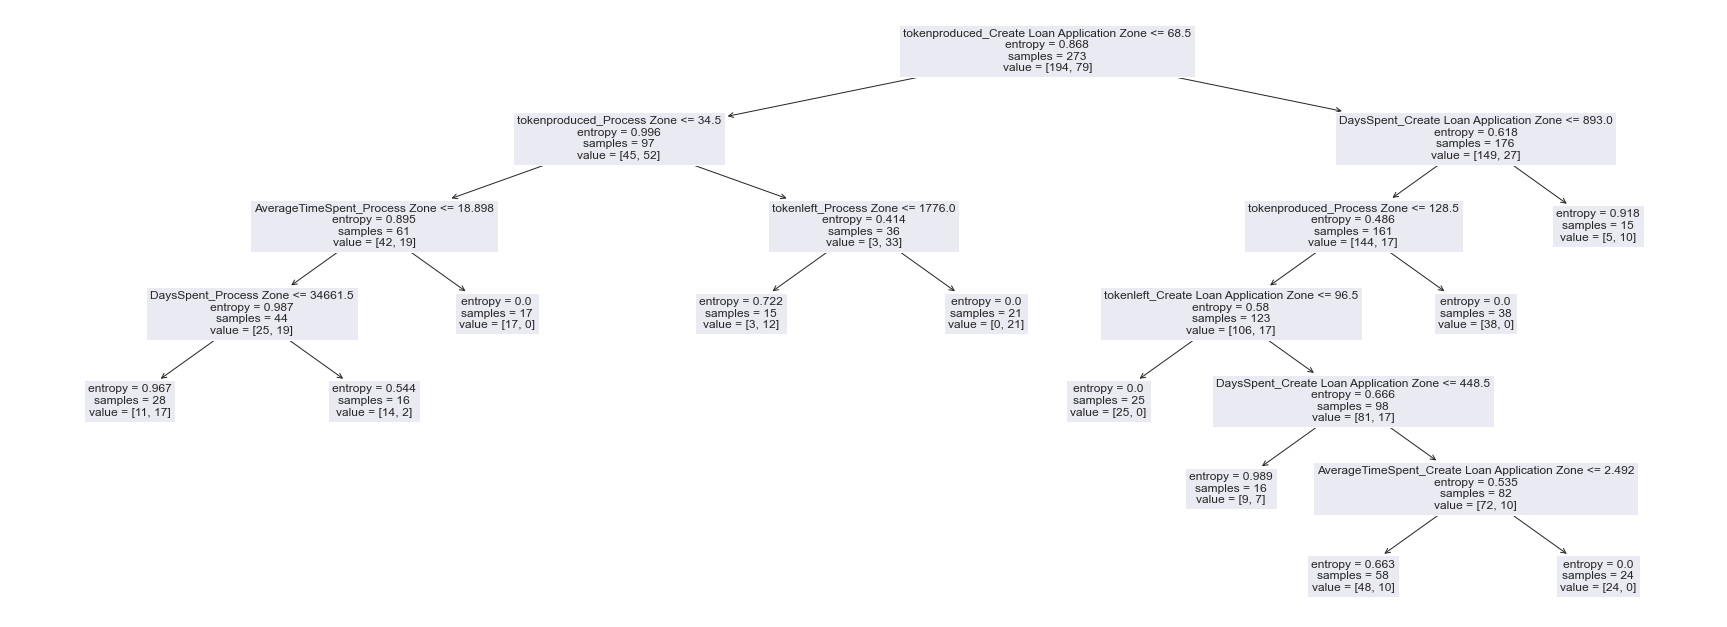

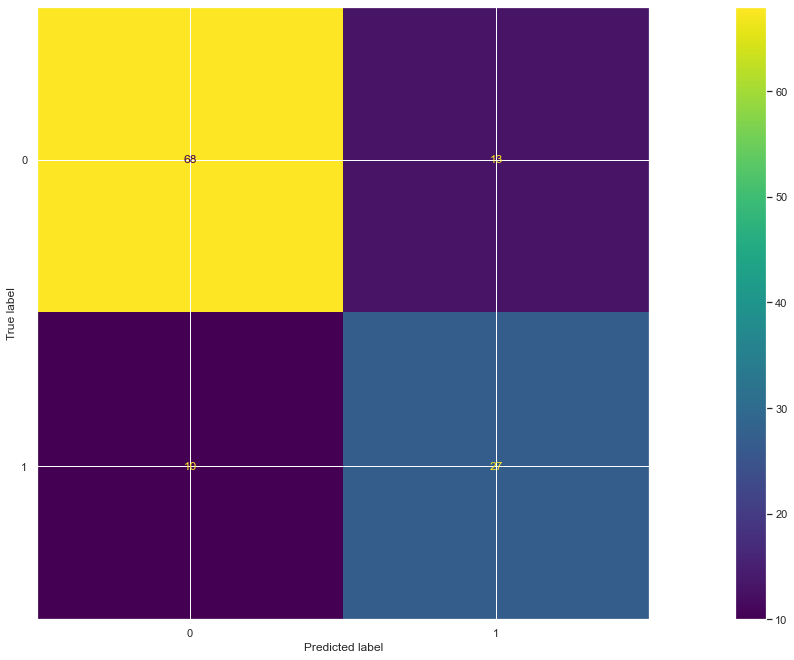

Decision Zone
feature- Strange_tokenproduced :  Day : 0
Mean absolute error LR- 0.03389830508474576
Mean Squared error LR- 0.18411492357966466
Accuracy: 0.9661016949152542
F1: 0.8481338481338481
Precision: 0.9032738095238095
Recall: 0.8079545454545455


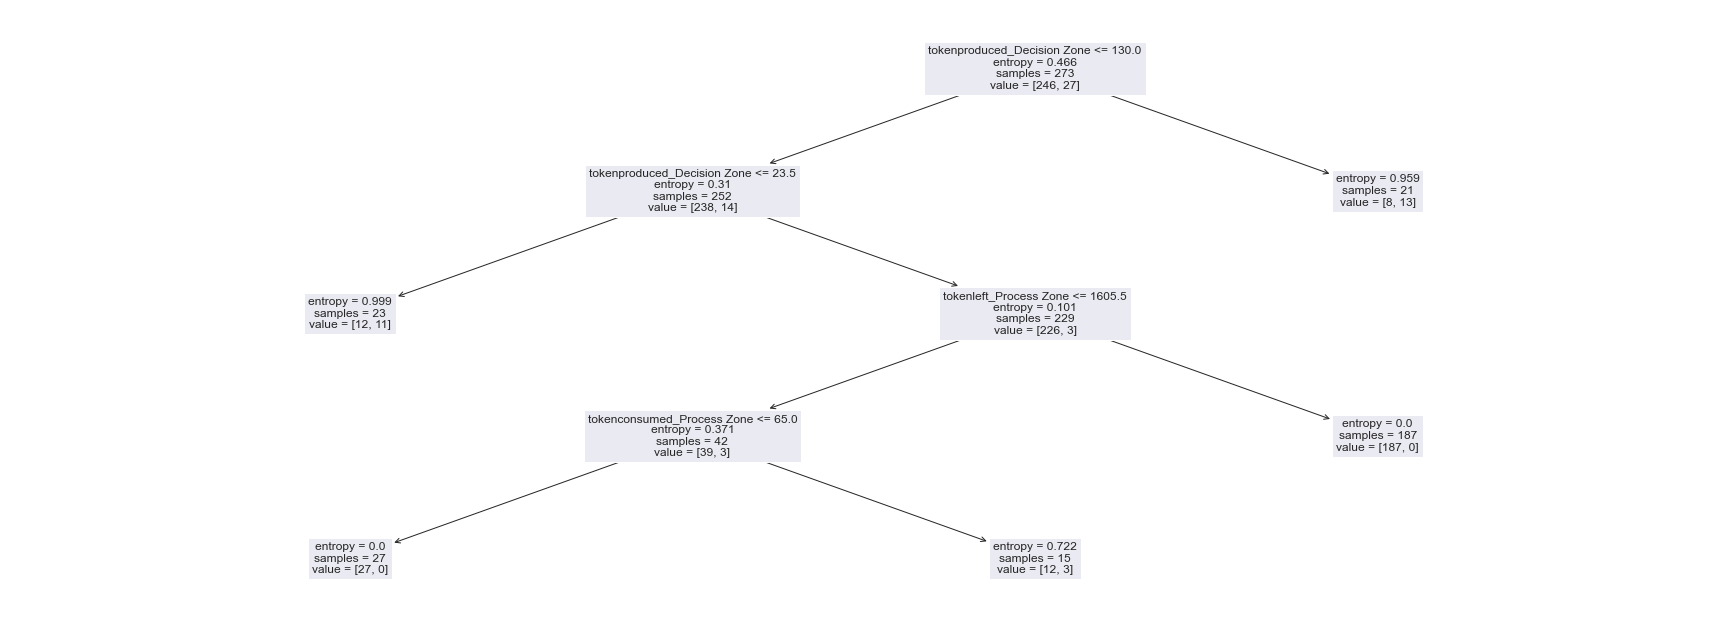

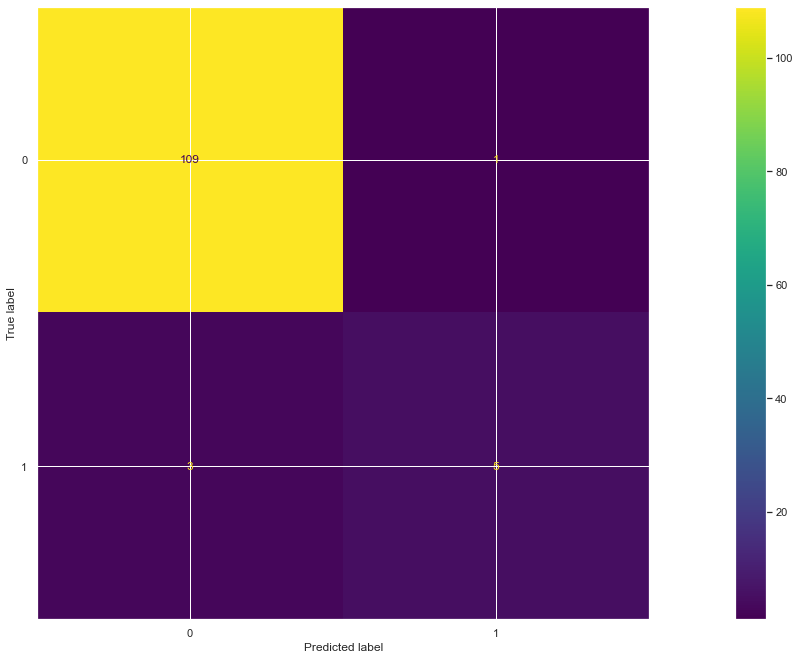

In [42]:
predictionDelay=40
targetfeaturelist=['Strange_tokenproduced', 'Strange_tokenconsumed', 'Strange_tokenleft','Strange_oneframetoken', 
             'Strange_Count', 'Strange_AverageTimeSpent']

for targetZone in targetzonelist:
    print(targetZone.name)
    predict(targetZone.copy(),zonelist.copy(),targetfeaturelist,predictionDelay)

# Appendix (Additional test and analysis)
Creating the combined dataframe

In [255]:
import datetime
from functools import reduce
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression
from sklearn import tree,metrics

sns.set(rc={'figure.figsize':(7.7,7.27)})
def traindtmultiple(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5)
    clf = tree.DecisionTreeRegressor(max_depth=10)
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    #tree.plot_tree(clf,feature_names=['tokenproduced_x', 'tokenconsumed_x', 'tokenleft_x',
    #              'oneframetoken_x', 'Count_x', 'DaysSpent_x', 'AverageTimeSpent_x','tokenproduced_y',
    #              'tokenconsumed_y', 'tokenleft_y', 'oneframetoken_y','Count_y', 'DaysSpent_y', 'AverageTimeSpent_y',
    #              'tokenproduced','tokenconsumed', 'tokenleft', 'oneframetoken','Count', 'DaysSpent',
    #              'AverageTimeSpent'])
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    if accuracy_score(y_test, Y_test_pred)>0.7 and f1_score(y_test, Y_test_pred, average="macro")>0.7:
        print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
        metrics.mean_squared_error(y_test, Y_test_pred)
        print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
        print("Accuracy:",accuracy_score(y_test, Y_test_pred))
        print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
        print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
        print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
        cm = confusion_matrix(y_test, Y_test_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        plt.show()



def predict(target,predictorZone,featurelist,predictionDelay):
    for feature in featurelist:
        combineddata = reduce(lambda  left,right: pd.merge(left,right,on=['date'],how='left'), predictorZone)
        def categorise(row,numdays):   
            return row['date'] -  datetime.timedelta(days=1)
        for j in range (predictionDelay):
            combineddata=combineddata.merge(targetZone[['date',feature]].rename({feature: feature+'_'+str(j)}, axis=1), on='date', how='left')
            targetZone['date'] = targetZone.apply(lambda row: categorise(row,j), axis=1)
        combineddata=combineddata.dropna()
        combineddata[feature+'_'+str(i)] = combineddata[feature+'_'+str(i)].astype(int)
        
        columnlist=[]
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('token')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('oneframetoken')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('DaysSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('AverageTimeSpent')].columns)
        columnlist.extend(combineddata.loc[:, combineddata.columns.str.startswith('Count')].columns)
        x = combineddata[columnlist]
   
        for i in range(predictionDelay):
            print('feature-',feature,':',combineddata[feature].sum(),' Day :',i)
            y = combineddata[feature+'_'+str(i)].fillna(0)
            traindtmultiple(x,y)


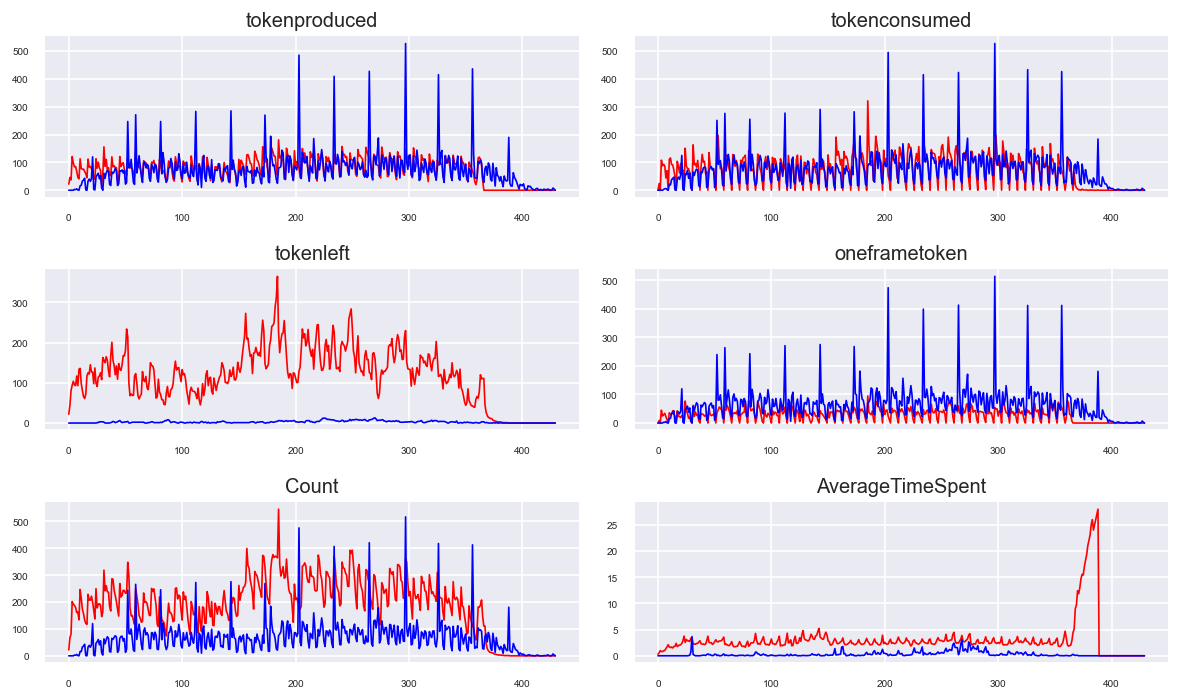

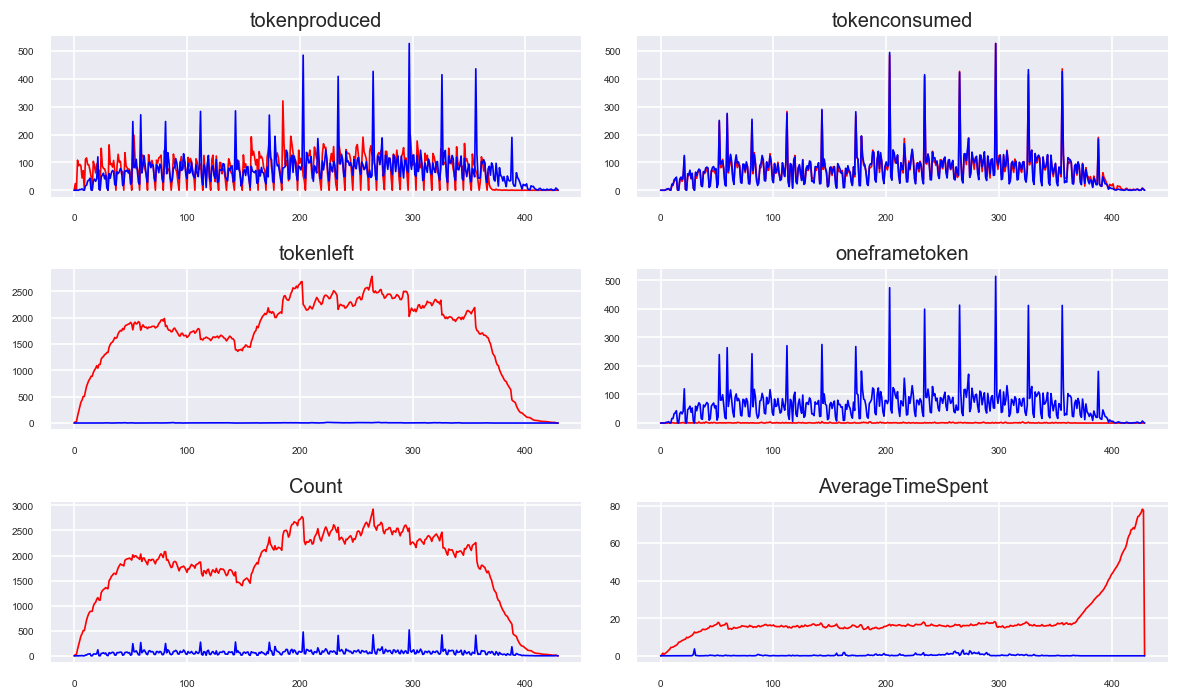

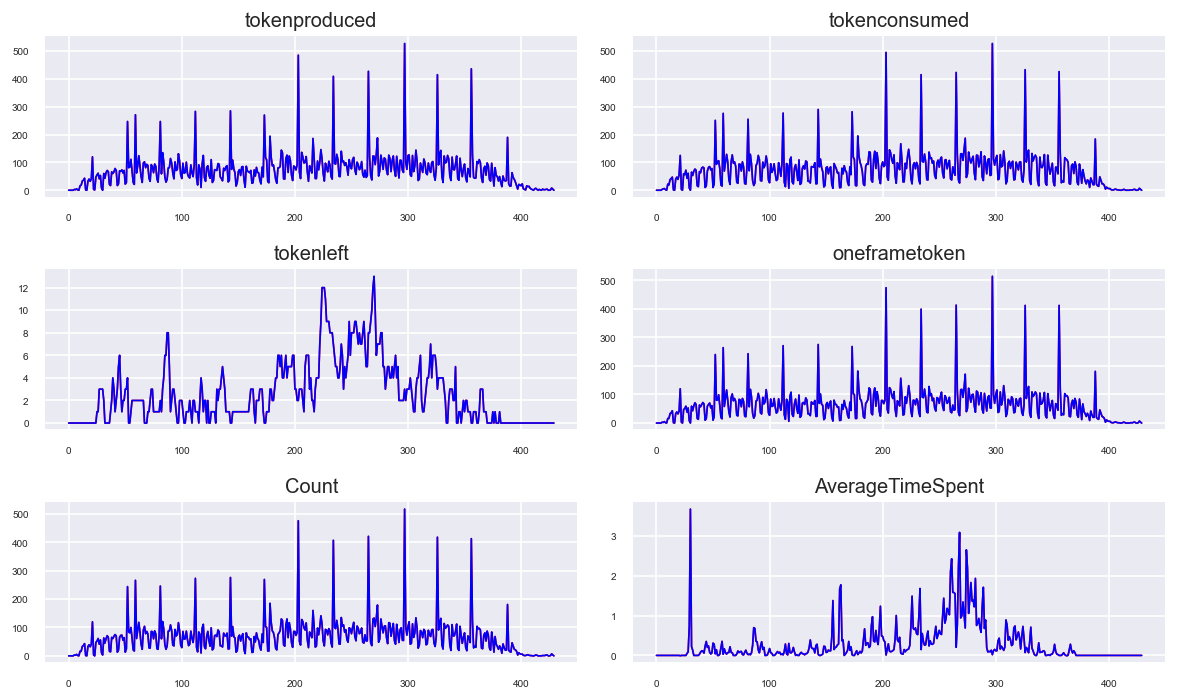

In [18]:

for zone in targetzonelist:
    fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
    for i, ax in enumerate(axes.flatten()):
        feature=featurelist[i]
        data = zone[feature]
        ax.plot(data, color='red', linewidth=1)
        ax.plot(DecisionZoneDF[feature], color='blue', linewidth=1)
        
        # Decorations
        ax.set_title(feature)
        ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('none')
        ax.spines["top"].set_alpha(0)
        ax.tick_params(labelsize=6)
    plt.tight_layout();
     